In [1]:
# https://data.bls.gov/pdq/SurveyOutputServlet

# importing all the necessary libraries!

import os
import warnings
import json
from datetime import datetime 
import pandas as pd
import numpy as np
from math import sqrt
from numpy.random import seed
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from keras.regularizers import L1L2
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasRegressor

import mlflow
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
plt.rcParams['figure.facecolor'] = 'white'
warnings.simplefilter('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2022-11-12 15:45:20.421016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-12 15:45:20.540969: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-12 15:45:20.540989: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-12 15:45:20.565981: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-12 15:45:21.129570: W tensorflow/stream_executor/platform/de

In [2]:
# function to create all the necessary directory!

def create_dir(path):
        isExist = os.path.exists(path)
        if not isExist:
            os.makedirs(path, exist_ok = False)
            print("New directory is created")


# dumping all the hyperparameters to json file!
def hyperparms(dictionary):
    # Serializing json
    json_object = json.dumps(dictionary, indent=4)
    
    # Writing to sample.json
    with open(path_metrics +'/'+ 'hyperparm.json', "w") as outfile:
        outfile.write(json_object)

#load and format data

class DataFormatting():
      
    def __init__(self):
       
        self.df_data = None
        self.df_datetime = None

    def dataset(df):

        # converting time colum from object type to datetime format
        df['date'] = pd.to_datetime(df['date'],dayfirst = True, format = '%Y-%m-%d')
        # creating a ema feature
        #df['SMA_10'] = df[['close']].rolling(10).mean().shift(1)
        #df['SMA_50'] = df[['close']].rolling(50).mean().shift(1)
        #df['SMA_200'] = df[['close']].rolling(200).mean().shift(1)
        df = df.dropna()
        # splitting the dataframe in to X and y 
        df_data = df[['open','high','low','close','CPI','INTEREST_RATE']] #'high','low',,'CRUDE_OIL_CLOSE','US500_CLOSE','open','EXCHANGE_RATE',
        df_datetime =df[['date']]

        return df_data, df_datetime


# Data transformation (changing data shape to model requirement)

def data_transformation(data, lags = 5, n_fut = 1):
    
    """ this function transforms dataframe to required input shape for the model.
    It required 2 input arguments:
    1. data: this will be the pandas dataframe
    2. lags: how many previous price points to be used to predict the next future value, in
    this case the default is set to 5 for 'XAUUSD' commodity"""

    # initialize lists to store the dataset
    X_data = []
    y_data = []
    
    for i in range(lags, len(data)- n_fut +1):
        X_data.append(data[i-lags: i, 0: data.shape[1]])
        y_data.append(data[i+ n_fut-1:i+n_fut,3]) # extracts close price with specific lag as price to be predicted.

    # convert the list to numpy array

    X_data = np.array(X_data)
    y_data = np.array(y_data)

    return X_data, y_data

class LSTM_model():
    

    def __init__(self,n_hidden_layers, units, dropout, train_data_X, train_data_y, epochs, reg):

        self.n_hidden_layers = n_hidden_layers
        self.units = units
        self.dropout = dropout
        self.train_data_X = train_data_X
        self.train_data_y = train_data_y
        self.epochs = epochs
        self.reg = reg

    def build_model(self):
        
        model = Sequential()
        # first lstm layer
        model.add(LSTM(self.units, activation='tanh', input_shape=(self.train_data_X.shape[1], self.train_data_X.shape[2]), kernel_regularizer=self.reg, return_sequences=True))

        if self.n_hidden_layers !=1:

            # building hidden layers
            for i in range(1, self.n_hidden_layers):
                # for the last layer as the return sequence is False
                if i == self.n_hidden_layers -1:
                    model.add(LSTM(int(self.units/(2**i)),  activation='tanh', return_sequences=False))
                else:
                    model.add(LSTM(int(self.units/(2**i)),  activation='tanh', return_sequences=True))

        else:
            model.add(LSTM(int(self.units/2),  activation='tanh', return_sequences=False))

        # adding dropout layer
        model.add(Dropout(self.dropout))
        # final layer
        model.add(Dense(self.train_data_y.shape[1]))

        return model

# def build_model(space): #train_data_X.shape[1], train_data_X.shape[2]

#     with mlflow.start_run():
#         mlflow.set_tag('model','lstm')
#         mlflow.log_params(space)
        
#         model = Sequential()
#             # first lstm layer
#         model.add(LSTM(units = space['units'], activation='tanh', input_shape=(train_data_X.shape[1],train_data_X.shape[2]), kernel_regularizer=L1L2(l1=space['l1'], l2=space['l2']), return_sequences=True))

#         if space['layers'] !=1:

#             # building hidden layers
#             for i in range(1, space['layers']):
#                 # for the last layer as the return sequence is False
#                 if i == space['layers'] -1:
#                     model.add(LSTM(int(space['units']/(2**i)),  activation='tanh', return_sequences=False))
#                 else:
#                     model.add(LSTM(int(space['units']/(2**i)),  activation='tanh', return_sequences=True))

#         else:
#             model.add(LSTM(int(space['units']/2),  activation='tanh', return_sequences=False))

#         # adding dropout layer
#         model.add(Dropout(space['dropout']))
#         # final layer
#         model.add(Dense(train_data_y.shape[1])) #train_data_y.shape[1]
#         # metrics for evaluating the model
#         metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanAbsolutePercentageError()]

#         # model compiler
#         model.compile(optimizer=Adam(learning_rate = space['rate']), loss='mse', metrics = metrics)

#         # setting the callback function
#         cb = [
#             tf.keras.callbacks.ModelCheckpoint(path_checkpoint),
#             tf.keras.callbacks.CSVLogger(path_metrics+'/'+'data.csv')]

#         # model fitting protocol
#         history = model.fit(train_data_X,train_data_y, 
#                             epochs = 500, 
#                             batch_size = space['batch_size'],  
#                             validation_split=0.1,
#                             verbose = 1,
#                             callbacks=[cb],
#                             shuffle= False,
#                             workers = 8,
#                             use_multiprocessing = True)
        
#         # training dataset
#         train_loss, RMSE, MAE, MAPE = model.evaluate(train_data_X,train_data_y)
#         print('\n','Evaluation of Training dataset:','\n''\n','train_loss:',round(train_loss,3),'\n','RMSE:',round(RMSE,3),'\n', 'MAE:',round(MAE,3),'\n','MAPE:',round(MAPE,3))
#         mlflow.log_metric('train_loss',train_loss)
#         mlflow.log_metric('RMSE', RMSE)
#         mlflow.log_metric('MAE', MAE)
#         mlflow.log_metric('MAPE',MAPE)

    
#         return {'loss': MAPE, 'status': STATUS_OK, 'model': model, 'space':space}


class Bi_LSTM_model():
    

    def __init__(self,n_hidden_layers, units, dropout, train_data_X, train_data_y, epochs, reg):

        self.n_hidden_layers = n_hidden_layers
        self.units = units
        self.dropout = dropout
        self.train_data_X = train_data_X
        self.train_data_y = train_data_y
        self.epochs = epochs
        self.reg = reg

    def build_model(self):
        
        model = Sequential()
        # first lstm layer
        model.add(Bidirectional(LSTM(self.units, activation='tanh', input_shape=(self.train_data_X.shape[1], self.train_data_X.shape[2]), kernel_regularizer=self.reg, return_sequences=True)))
        # building hidden layers
        
        if self.n_hidden_layers !=1:

            for i in range(1, self.n_hidden_layers):
                # for the last layer as the return sequence is False
                if i == self.n_hidden_layers -1:
                    model.add(Bidirectional(LSTM(int(self.units/(2**i)),  activation='tanh', return_sequences=False)))
                else:
                    model.add(Bidirectional(LSTM(int(self.units/(2**i)),  activation='tanh', return_sequences=True)))

        else:
            model.add(Bidirectional(LSTM(int(self.units/2),  activation='tanh', return_sequences=False)))
        
        # adding dropout layer
        model.add(Dropout(self.dropout))
        # final layer
        model.add(Dense(self.train_data_y.shape[1]))
    
        return model

def metricplot(df, xlab, ylab_1,ylab_2, path):
    
    """
    This function plots metric curves and saves it
    to respective folder
    inputs: df : pandas dataframe 
            xlab: x-axis
            ylab_1 : yaxis_1
            ylab_2 : yaxis_2
            path: full path for saving the plot
            """
    plt.figure()
    sns.set_theme(style="darkgrid")
    sns.lineplot(x = df[xlab], y = df[ylab_1])
    sns.lineplot(x = df[xlab], y = df[ylab_2])
    plt.xlabel('Epochs',fontsize = 12)
    plt.ylabel(ylab_1,fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend([ylab_1,ylab_2], prop={"size":12})
    plt.savefig(path+'/'+ ylab_1)

In [3]:
#DATEBASE_NAME = input('Enter new database name:')
mlflow.set_tracking_uri("sqlite:///lstm.db")
mlflow.set_experiment("Gold_Price_Forecasting")
mlflow.keras.autolog()
with mlflow.start_run():
    mlflow.set_tag('mleng','Jayesh')
    # loading the dataset!
    data = pd.read_csv('../data/macro_data/Gold_Macor_Data.csv',index_col=[0]) 

    #mlflow.log_param('train_data','../data/macro_data/Gold_Macor_Data.csv')
    # dropping rows iteratively from bottom for forecasting
    #data.drop(index=data.index[-j:],axis=0, inplace=True) 
    seed(42)
    tf.random.set_seed(42) 
    keras.backend.clear_session()

    # hyperparameters
    train_size_percent = 90
    lag = 5
    n_fut = 1
    n_hidden_layers = 3
    batch_size = 128 #256
    units = 192 
    dropout = 0
    epochs = 700
    learning_rate = 1.22556185e-05
    l1 = 0.001758323799832654
    l2 = 0.04727729600605428
    reg = L1L2(l1=l1, l2=l2)

    # creating main folder
    today = datetime.now()
    today  = today.strftime('%Y_%m_%d')
    path = '../Model_Outputs/'+ today
    create_dir(path)

    # Which model to run: 
# MODEL_NAME = input('Enter the name LSTM or BILSTM:')
    # creating directory to save model and its output
    EXPERIMENT_NAME = input('Enter new Experiment name:')
    print('\n')
    print('A folder with',EXPERIMENT_NAME,'name has be created to store all the model details!')
    print('\n')
    folder = EXPERIMENT_NAME
    path_main = path + '/'+ folder
    create_dir(path_main)

    # creating directory to save model and its output
    folder = 'model_Bilstm'#+ str(units) + '_' + str(n_hidden_layers)
    path_dir = path_main + '/'+ folder
    create_dir(path_dir)

    # creating directory to save all the metric data
    folder = 'metrics'
    path_metrics = path_dir +'/'+ folder
    create_dir(path_metrics)

    # creating folder to save model.h5 file
    folder = 'model'
    path_model = path_dir +'/'+ folder
    create_dir(path_model)

    # creating folder to save model.h5 file
    folder = 'model_checkpoint'
    path_checkpoint = path_dir +'/'+ folder
    create_dir(path_checkpoint)

    # creating folder to save model.h5 file
    folder = 'forecasting_resutls'
    path_forecast = path_dir +'/'+ folder
    create_dir(path_forecast)




A folder with final_run1 name has be created to store all the model details!


New directory is created
New directory is created
New directory is created
New directory is created
New directory is created
New directory is created


In [4]:

# initializing DataFormatting class
data_init = DataFormatting()
df_data, df_datetime = DataFormatting.dataset(data)
print('\n')
print('Displaying top 5 rows of the dataset:')
print('\n')
print(df_data.head())
print(df_data.shape)
print(df_data.columns)
df_colnames = list(df_data.columns)
# normalize train, val and test dataset

# initialize StandartScaler()
scaler = StandardScaler()
scaler = scaler.fit(df_data)
data_fit_transformed = scaler.transform(df_data)


print('\n')
print('Displaying top 5 rows of all the scaled dataset:')
print('\n')
#print('The train dateset:','\n''\n',data_fit_transformed[0:5],'\n''\n', 'The validation dataset:','\n''\n',val_transformed[0:5],'\n''\n','The test dataset:','\n''\n',test_transformed[0:5])
print('The train dateset:','\n''\n',data_fit_transformed[0:10])

# changing shape of the data to match the model requirement!

X_data, y_data = data_transformation(data_fit_transformed, lags = lag, n_fut = n_fut)
print('\n')
print('Displaying the shape of the dataset required by the model:')
print('\n')
print(f' Input shape X:',X_data.shape, f'Input shape y:',y_data.shape)
print('\n')
#print(X_data)
print(y_data[0:10])
#setting the model file name
model_name = 'lstm_'+ str(units)+'.h5'


train_data_X = X_data
train_data_y = y_data

# split train and test

# traininig 
size_df = X_data.shape[0]
train_size_percent = train_size_percent/100
train_size = int(round(size_df*train_size_percent,0))
x_train = X_data[:train_size,:]
y_train = y_data[:train_size,:]

# testing

x_test = X_data[train_size:,:]
y_test = y_data[train_size:,:]

print(x_test.shape)
print(y_test.shape)
#cross validation


# for train_index, test_index in tscv.split(train_data_X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     x_train, x_test = train_data_X[train_index], train_data_X[test_index]
#     y_train, y_test = y_data[train_index], y_data[test_index]
# hyperparameters to dictionary
dictionary = {
"lags": lag,
"n_fut": n_fut,
"n_hidden_layers": n_hidden_layers,
"batch_size": batch_size,
"units": units,
"dropout": dropout,
"epochs": epochs,
"learning_rate": learning_rate,
"reg_l1": l1,
"reg_l2": l2,
"features":df_colnames,  
}
mlflow.log_param('dict',dictionary)

print('The hyperparameters for the current experiments:')
print(dictionary)
# dump all the hyperparameters in to a dictionary and save to .json file
hyperparms(dictionary)



Displaying top 5 rows of the dataset:


      open    high     low  close       CPI  INTEREST_RATE
612  272.5  274.00  272.10  274.0  0.000000           6.51
613  273.8  279.10  272.70  278.2  0.000000           6.65
614  277.5  278.50  275.00  277.0  0.520833           6.52
616  276.8  278.00  274.40  276.1  0.520833           6.61
617  275.4  277.15  273.05  275.0  0.520833           6.56
(5498, 6)
Index(['open', 'high', 'low', 'close', 'CPI', 'INTEREST_RATE'], dtype='object')


Displaying top 5 rows of all the scaled dataset:


The train dateset: 

 [[-1.54572002 -1.54918924 -1.54182803 -1.54400445 -0.51972519  2.92119717]
 [-1.54316228 -1.53921829 -1.54063858 -1.5357376  -0.51972519  3.00245611]
 [-1.53588254 -1.54039134 -1.53607902 -1.53809955  0.80059587  2.92700138]
 [-1.53725979 -1.54136889 -1.53726847 -1.53987102  0.80059587  2.97923927]
 [-1.54001428 -1.54303071 -1.53994473 -1.54203615  0.80059587  2.95021822]
 [-1.54237528 -1.5471364  -1.54202627 -1.54380762  0.80059587  2

In [5]:
#if MODEL_NAME == 'LSTM':

# initializing model
model_init = LSTM_model(n_hidden_layers, units, dropout, x_train, y_train, epochs, reg)

# calling the model
model = model_init.build_model()
model.build((x_train.shape[0],x_train.shape[1], x_train.shape[2]))
print(model.summary())

2022-11-12 15:45:28.312112: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-12 15:45:28.312141: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-12 15:45:28.312155: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (deeplearning): /proc/driver/nvidia/version does not exist
2022-11-12 15:45:28.312364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 192)            152832    
                                                                 
 lstm_1 (LSTM)               (None, 5, 96)             110976    
                                                                 
 lstm_2 (LSTM)               (None, 48)                27840     
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 1)                 49        
                                                                 
Total params: 291,697
Trainable params: 291,697
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
#metrics for evaluating the model



metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanAbsolutePercentageError()]

# model compiler
model.compile(optimizer=Adam(learning_rate = learning_rate), loss='mse', metrics = metrics)
print(model.summary())


#setting the callback function
cb = [
    tf.keras.callbacks.ModelCheckpoint(path_checkpoint),
    tf.keras.callbacks.CSVLogger(path_metrics+'/'+'data.csv')]
    #tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=, restore_best_weights=False)]




# model fitting protocol
history = model.fit(x_train, y_train,
                    epochs = epochs, 
                    batch_size = batch_size,  
                    validation_data=(x_test, y_test),
                    verbose = 1,
                    callbacks=[cb],
                    shuffle= False,
                    workers = 8,
                    use_multiprocessing = True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 192)            152832    
                                                                 
 lstm_1 (LSTM)               (None, 5, 96)             110976    
                                                                 
 lstm_2 (LSTM)               (None, 48)                27840     
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 1)                 49        
                                                                 
Total params: 291,697
Trainable params: 291,697
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/700
37/39 [==========================

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 16s 289ms/step - loss: 1.7701 - root_mean_squared_error: 0.9209 - mean_absolute_error: 0.7917 - mean_absolute_percentage_error: 99.8031 - val_loss: 3.2053 - val_root_mean_squared_error: 1.5129 - val_mean_absolute_error: 1.5061 - val_mean_absolute_percentage_error: 98.7890
Epoch 2/700
39/39 [==============================] - ETA: 0s - loss: 1.7296 - root_mean_squared_error: 0.9046 - mean_absolute_error: 0.7776 - mean_absolute_percentage_error: 97.8985

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 197ms/step - loss: 1.7296 - root_mean_squared_error: 0.9046 - mean_absolute_error: 0.7776 - mean_absolute_percentage_error: 97.8985 - val_loss: 3.1235 - val_root_mean_squared_error: 1.4892 - val_mean_absolute_error: 1.4824 - val_mean_absolute_percentage_error: 97.2347
Epoch 3/700
36/39 [==========================>...] - ETA: 0s - loss: 1.6979 - root_mean_squared_error: 0.8926 - mean_absolute_error: 0.7616 - mean_absolute_percentage_error: 95.8683

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 202ms/step - loss: 1.6890 - root_mean_squared_error: 0.8878 - mean_absolute_error: 0.7628 - mean_absolute_percentage_error: 95.9336 - val_loss: 3.0387 - val_root_mean_squared_error: 1.4640 - val_mean_absolute_error: 1.4573 - val_mean_absolute_percentage_error: 95.5810
Epoch 4/700
38/39 [============================>.] - ETA: 0s - loss: 1.6401 - root_mean_squared_error: 0.8657 - mean_absolute_error: 0.7416 - mean_absolute_percentage_error: 93.8637

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 197ms/step - loss: 1.6472 - root_mean_squared_error: 0.8699 - mean_absolute_error: 0.7471 - mean_absolute_percentage_error: 93.8685 - val_loss: 2.9507 - val_root_mean_squared_error: 1.4372 - val_mean_absolute_error: 1.4305 - val_mean_absolute_percentage_error: 93.8229
Epoch 5/700
37/39 [===========================>..] - ETA: 0s - loss: 1.5988 - root_mean_squared_error: 0.8474 - mean_absolute_error: 0.7224 - mean_absolute_percentage_error: 91.6401

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 225ms/step - loss: 1.6040 - root_mean_squared_error: 0.8506 - mean_absolute_error: 0.7302 - mean_absolute_percentage_error: 91.6838 - val_loss: 2.8590 - val_root_mean_squared_error: 1.4085 - val_mean_absolute_error: 1.4019 - val_mean_absolute_percentage_error: 91.9389
Epoch 6/700
36/39 [==========================>...] - ETA: 0s - loss: 1.5661 - root_mean_squared_error: 0.8338 - mean_absolute_error: 0.7101 - mean_absolute_percentage_error: 89.1881

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 210ms/step - loss: 1.5590 - root_mean_squared_error: 0.8298 - mean_absolute_error: 0.7118 - mean_absolute_percentage_error: 89.3509 - val_loss: 2.7630 - val_root_mean_squared_error: 1.3775 - val_mean_absolute_error: 1.3710 - val_mean_absolute_percentage_error: 89.9056
Epoch 7/700
36/39 [==========================>...] - ETA: 0s - loss: 1.5182 - root_mean_squared_error: 0.8106 - mean_absolute_error: 0.6896 - mean_absolute_percentage_error: 86.6460

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 232ms/step - loss: 1.5117 - root_mean_squared_error: 0.8068 - mean_absolute_error: 0.6916 - mean_absolute_percentage_error: 86.8407 - val_loss: 2.6621 - val_root_mean_squared_error: 1.3440 - val_mean_absolute_error: 1.3375 - val_mean_absolute_percentage_error: 87.7010
Epoch 8/700
36/39 [==========================>...] - ETA: 0s - loss: 1.4676 - root_mean_squared_error: 0.7848 - mean_absolute_error: 0.6670 - mean_absolute_percentage_error: 83.8732

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 198ms/step - loss: 1.4619 - root_mean_squared_error: 0.7814 - mean_absolute_error: 0.6692 - mean_absolute_percentage_error: 84.1013 - val_loss: 2.5562 - val_root_mean_squared_error: 1.3076 - val_mean_absolute_error: 1.3011 - val_mean_absolute_percentage_error: 85.3068
Epoch 9/700
37/39 [===========================>..] - ETA: 0s - loss: 1.4044 - root_mean_squared_error: 0.7497 - mean_absolute_error: 0.6367 - mean_absolute_percentage_error: 80.9842

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 198ms/step - loss: 1.4093 - root_mean_squared_error: 0.7531 - mean_absolute_error: 0.6442 - mean_absolute_percentage_error: 81.0768 - val_loss: 2.4454 - val_root_mean_squared_error: 1.2681 - val_mean_absolute_error: 1.2616 - val_mean_absolute_percentage_error: 82.7102
Epoch 10/700
37/39 [===========================>..] - ETA: 0s - loss: 1.3489 - root_mean_squared_error: 0.7181 - mean_absolute_error: 0.6089 - mean_absolute_percentage_error: 77.6346

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 201ms/step - loss: 1.3537 - root_mean_squared_error: 0.7216 - mean_absolute_error: 0.6163 - mean_absolute_percentage_error: 77.7433 - val_loss: 2.3303 - val_root_mean_squared_error: 1.2256 - val_mean_absolute_error: 1.2191 - val_mean_absolute_percentage_error: 79.9070
Epoch 11/700
37/39 [===========================>..] - ETA: 0s - loss: 1.2905 - root_mean_squared_error: 0.6827 - mean_absolute_error: 0.5778 - mean_absolute_percentage_error: 73.9411

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 1.2953 - root_mean_squared_error: 0.6864 - mean_absolute_error: 0.5852 - mean_absolute_percentage_error: 74.0693 - val_loss: 2.2120 - val_root_mean_squared_error: 1.1800 - val_mean_absolute_error: 1.1735 - val_mean_absolute_percentage_error: 76.9049
Epoch 12/700
37/39 [===========================>..] - ETA: 0s - loss: 1.2299 - root_mean_squared_error: 0.6435 - mean_absolute_error: 0.5433 - mean_absolute_percentage_error: 69.9392

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 200ms/step - loss: 1.2347 - root_mean_squared_error: 0.6474 - mean_absolute_error: 0.5507 - mean_absolute_percentage_error: 70.0893 - val_loss: 2.0921 - val_root_mean_squared_error: 1.1318 - val_mean_absolute_error: 1.1252 - val_mean_absolute_percentage_error: 73.7261
Epoch 13/700
39/39 [==============================] - ETA: 0s - loss: 1.1726 - root_mean_squared_error: 0.6045 - mean_absolute_error: 0.5128 - mean_absolute_percentage_error: 65.8366

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 184ms/step - loss: 1.1726 - root_mean_squared_error: 0.6045 - mean_absolute_error: 0.5128 - mean_absolute_percentage_error: 65.8366 - val_loss: 1.9726 - val_root_mean_squared_error: 1.0816 - val_mean_absolute_error: 1.0749 - val_mean_absolute_percentage_error: 70.4100
Epoch 14/700
37/39 [===========================>..] - ETA: 0s - loss: 1.1052 - root_mean_squared_error: 0.5534 - mean_absolute_error: 0.4639 - mean_absolute_percentage_error: 61.1144

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 199ms/step - loss: 1.1102 - root_mean_squared_error: 0.5580 - mean_absolute_error: 0.4716 - mean_absolute_percentage_error: 61.3167 - val_loss: 1.8558 - val_root_mean_squared_error: 1.0302 - val_mean_absolute_error: 1.0234 - val_mean_absolute_percentage_error: 67.0121
Epoch 15/700
38/39 [============================>.] - ETA: 0s - loss: 1.0452 - root_mean_squared_error: 0.5045 - mean_absolute_error: 0.4230 - mean_absolute_percentage_error: 56.5438

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 203ms/step - loss: 1.0493 - root_mean_squared_error: 0.5086 - mean_absolute_error: 0.4275 - mean_absolute_percentage_error: 56.6165 - val_loss: 1.7442 - val_root_mean_squared_error: 0.9787 - val_mean_absolute_error: 0.9717 - val_mean_absolute_percentage_error: 63.6007
Epoch 16/700
37/39 [===========================>..] - ETA: 0s - loss: 0.9864 - root_mean_squared_error: 0.4513 - mean_absolute_error: 0.3734 - mean_absolute_percentage_error: 51.6106

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 185ms/step - loss: 0.9917 - root_mean_squared_error: 0.4573 - mean_absolute_error: 0.3816 - mean_absolute_percentage_error: 51.8764 - val_loss: 1.6398 - val_root_mean_squared_error: 0.9282 - val_mean_absolute_error: 0.9209 - val_mean_absolute_percentage_error: 60.2515
Epoch 17/700
37/39 [===========================>..] - ETA: 0s - loss: 0.9339 - root_mean_squared_error: 0.3990 - mean_absolute_error: 0.3266 - mean_absolute_percentage_error: 46.9335

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 206ms/step - loss: 0.9393 - root_mean_squared_error: 0.4059 - mean_absolute_error: 0.3352 - mean_absolute_percentage_error: 47.2305 - val_loss: 1.5442 - val_root_mean_squared_error: 0.8798 - val_mean_absolute_error: 0.8722 - val_mean_absolute_percentage_error: 57.0385
Epoch 18/700
37/39 [===========================>..] - ETA: 0s - loss: 0.8883 - root_mean_squared_error: 0.3487 - mean_absolute_error: 0.2811 - mean_absolute_percentage_error: 42.5560

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 185ms/step - loss: 0.8936 - root_mean_squared_error: 0.3565 - mean_absolute_error: 0.2900 - mean_absolute_percentage_error: 42.8787 - val_loss: 1.4585 - val_root_mean_squared_error: 0.8344 - val_mean_absolute_error: 0.8266 - val_mean_absolute_percentage_error: 54.0245
Epoch 19/700
38/39 [============================>.] - ETA: 0s - loss: 0.8523 - root_mean_squared_error: 0.3062 - mean_absolute_error: 0.2453 - mean_absolute_percentage_error: 39.1609

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 227ms/step - loss: 0.8556 - root_mean_squared_error: 0.3116 - mean_absolute_error: 0.2500 - mean_absolute_percentage_error: 39.2802 - val_loss: 1.3827 - val_root_mean_squared_error: 0.7927 - val_mean_absolute_error: 0.7846 - val_mean_absolute_percentage_error: 51.2526
Epoch 20/700
36/39 [==========================>...] - ETA: 0s - loss: 0.8202 - root_mean_squared_error: 0.2636 - mean_absolute_error: 0.2077 - mean_absolute_percentage_error: 36.0315

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.8251 - root_mean_squared_error: 0.2732 - mean_absolute_error: 0.2183 - mean_absolute_percentage_error: 36.6898 - val_loss: 1.3162 - val_root_mean_squared_error: 0.7550 - val_mean_absolute_error: 0.7466 - val_mean_absolute_percentage_error: 48.7392
Epoch 21/700
37/39 [===========================>..] - ETA: 0s - loss: 0.7965 - root_mean_squared_error: 0.2322 - mean_absolute_error: 0.1840 - mean_absolute_percentage_error: 34.5159

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.8011 - root_mean_squared_error: 0.2424 - mean_absolute_error: 0.1931 - mean_absolute_percentage_error: 34.7702 - val_loss: 1.2580 - val_root_mean_squared_error: 0.7210 - val_mean_absolute_error: 0.7123 - val_mean_absolute_percentage_error: 46.4759
Epoch 22/700
36/39 [==========================>...] - ETA: 0s - loss: 0.7778 - root_mean_squared_error: 0.2081 - mean_absolute_error: 0.1621 - mean_absolute_percentage_error: 32.7909

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 184ms/step - loss: 0.7822 - root_mean_squared_error: 0.2190 - mean_absolute_error: 0.1727 - mean_absolute_percentage_error: 33.2655 - val_loss: 1.2066 - val_root_mean_squared_error: 0.6904 - val_mean_absolute_error: 0.6814 - val_mean_absolute_percentage_error: 44.4348
Epoch 23/700
38/39 [============================>.] - ETA: 0s - loss: 0.7644 - root_mean_squared_error: 0.1956 - mean_absolute_error: 0.1520 - mean_absolute_percentage_error: 32.0002

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 207ms/step - loss: 0.7668 - root_mean_squared_error: 0.2017 - mean_absolute_error: 0.1564 - mean_absolute_percentage_error: 32.0692 - val_loss: 1.1607 - val_root_mean_squared_error: 0.6625 - val_mean_absolute_error: 0.6533 - val_mean_absolute_percentage_error: 42.5787
Epoch 24/700
37/39 [===========================>..] - ETA: 0s - loss: 0.7500 - root_mean_squared_error: 0.1788 - mean_absolute_error: 0.1355 - mean_absolute_percentage_error: 31.0088

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 232ms/step - loss: 0.7535 - root_mean_squared_error: 0.1887 - mean_absolute_error: 0.1438 - mean_absolute_percentage_error: 31.1109 - val_loss: 1.1192 - val_root_mean_squared_error: 0.6369 - val_mean_absolute_error: 0.6274 - val_mean_absolute_percentage_error: 40.8700
Epoch 25/700
38/39 [============================>.] - ETA: 0s - loss: 0.7395 - root_mean_squared_error: 0.1726 - mean_absolute_error: 0.1298 - mean_absolute_percentage_error: 30.2698

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 247ms/step - loss: 0.7415 - root_mean_squared_error: 0.1783 - mean_absolute_error: 0.1339 - mean_absolute_percentage_error: 30.3055 - val_loss: 1.0811 - val_root_mean_squared_error: 0.6129 - val_mean_absolute_error: 0.6032 - val_mean_absolute_percentage_error: 39.2762
Epoch 26/700
37/39 [===========================>..] - ETA: 0s - loss: 0.7275 - root_mean_squared_error: 0.1608 - mean_absolute_error: 0.1187 - mean_absolute_percentage_error: 29.6296

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 176ms/step - loss: 0.7303 - root_mean_squared_error: 0.1695 - mean_absolute_error: 0.1261 - mean_absolute_percentage_error: 29.6293 - val_loss: 1.0458 - val_root_mean_squared_error: 0.5904 - val_mean_absolute_error: 0.5804 - val_mean_absolute_percentage_error: 37.7735
Epoch 27/700
38/39 [============================>.] - ETA: 0s - loss: 0.7180 - root_mean_squared_error: 0.1565 - mean_absolute_error: 0.1159 - mean_absolute_percentage_error: 29.0154

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 198ms/step - loss: 0.7195 - root_mean_squared_error: 0.1617 - mean_absolute_error: 0.1195 - mean_absolute_percentage_error: 29.0181 - val_loss: 1.0129 - val_root_mean_squared_error: 0.5689 - val_mean_absolute_error: 0.5588 - val_mean_absolute_percentage_error: 36.3451
Epoch 28/700
37/39 [===========================>..] - ETA: 0s - loss: 0.7071 - root_mean_squared_error: 0.1470 - mean_absolute_error: 0.1072 - mean_absolute_percentage_error: 28.5464

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 191ms/step - loss: 0.7092 - root_mean_squared_error: 0.1546 - mean_absolute_error: 0.1138 - mean_absolute_percentage_error: 28.4498 - val_loss: 0.9819 - val_root_mean_squared_error: 0.5485 - val_mean_absolute_error: 0.5381 - val_mean_absolute_percentage_error: 34.9806
Epoch 29/700
37/39 [===========================>..] - ETA: 0s - loss: 0.6973 - root_mean_squared_error: 0.1409 - mean_absolute_error: 0.1025 - mean_absolute_percentage_error: 28.0606

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 200ms/step - loss: 0.6991 - root_mean_squared_error: 0.1479 - mean_absolute_error: 0.1086 - mean_absolute_percentage_error: 27.9188 - val_loss: 0.9528 - val_root_mean_squared_error: 0.5289 - val_mean_absolute_error: 0.5182 - val_mean_absolute_percentage_error: 33.6739
Epoch 30/700
37/39 [===========================>..] - ETA: 0s - loss: 0.6877 - root_mean_squared_error: 0.1352 - mean_absolute_error: 0.0983 - mean_absolute_percentage_error: 27.6003

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 185ms/step - loss: 0.6893 - root_mean_squared_error: 0.1417 - mean_absolute_error: 0.1040 - mean_absolute_percentage_error: 27.4153 - val_loss: 0.9254 - val_root_mean_squared_error: 0.5101 - val_mean_absolute_error: 0.4993 - val_mean_absolute_percentage_error: 32.4232
Epoch 31/700
38/39 [============================>.] - ETA: 0s - loss: 0.6787 - root_mean_squared_error: 0.1317 - mean_absolute_error: 0.0969 - mean_absolute_percentage_error: 26.9905

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 219ms/step - loss: 0.6798 - root_mean_squared_error: 0.1359 - mean_absolute_error: 0.0998 - mean_absolute_percentage_error: 26.9352 - val_loss: 0.8995 - val_root_mean_squared_error: 0.4922 - val_mean_absolute_error: 0.4811 - val_mean_absolute_percentage_error: 31.2279
Epoch 32/700
37/39 [===========================>..] - ETA: 0s - loss: 0.6692 - root_mean_squared_error: 0.1249 - mean_absolute_error: 0.0914 - mean_absolute_percentage_error: 26.7520

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 208ms/step - loss: 0.6705 - root_mean_squared_error: 0.1305 - mean_absolute_error: 0.0962 - mean_absolute_percentage_error: 26.4883 - val_loss: 0.8752 - val_root_mean_squared_error: 0.4752 - val_mean_absolute_error: 0.4638 - val_mean_absolute_percentage_error: 30.0886
Epoch 33/700
38/39 [============================>.] - ETA: 0s - loss: 0.6605 - root_mean_squared_error: 0.1217 - mean_absolute_error: 0.0904 - mean_absolute_percentage_error: 26.1401

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 206ms/step - loss: 0.6613 - root_mean_squared_error: 0.1254 - mean_absolute_error: 0.0930 - mean_absolute_percentage_error: 26.0633 - val_loss: 0.8523 - val_root_mean_squared_error: 0.4590 - val_mean_absolute_error: 0.4474 - val_mean_absolute_percentage_error: 29.0064
Epoch 34/700
37/39 [===========================>..] - ETA: 0s - loss: 0.6515 - root_mean_squared_error: 0.1161 - mean_absolute_error: 0.0860 - mean_absolute_percentage_error: 25.9774

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 184ms/step - loss: 0.6524 - root_mean_squared_error: 0.1208 - mean_absolute_error: 0.0901 - mean_absolute_percentage_error: 25.6462 - val_loss: 0.8307 - val_root_mean_squared_error: 0.4437 - val_mean_absolute_error: 0.4319 - val_mean_absolute_percentage_error: 27.9836
Epoch 35/700
37/39 [===========================>..] - ETA: 0s - loss: 0.6429 - root_mean_squared_error: 0.1122 - mean_absolute_error: 0.0837 - mean_absolute_percentage_error: 25.5921

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 207ms/step - loss: 0.6437 - root_mean_squared_error: 0.1165 - mean_absolute_error: 0.0874 - mean_absolute_percentage_error: 25.2315 - val_loss: 0.8105 - val_root_mean_squared_error: 0.4293 - val_mean_absolute_error: 0.4172 - val_mean_absolute_percentage_error: 27.0198
Epoch 36/700
37/39 [===========================>..] - ETA: 0s - loss: 0.6345 - root_mean_squared_error: 0.1087 - mean_absolute_error: 0.0816 - mean_absolute_percentage_error: 25.2043

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 10s 254ms/step - loss: 0.6352 - root_mean_squared_error: 0.1126 - mean_absolute_error: 0.0850 - mean_absolute_percentage_error: 24.8178 - val_loss: 0.7915 - val_root_mean_squared_error: 0.4158 - val_mean_absolute_error: 0.4035 - val_mean_absolute_percentage_error: 26.1153
Epoch 37/700
37/39 [===========================>..] - ETA: 0s - loss: 0.6262 - root_mean_squared_error: 0.1054 - mean_absolute_error: 0.0796 - mean_absolute_percentage_error: 24.8314

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 191ms/step - loss: 0.6268 - root_mean_squared_error: 0.1090 - mean_absolute_error: 0.0828 - mean_absolute_percentage_error: 24.4211 - val_loss: 0.7736 - val_root_mean_squared_error: 0.4032 - val_mean_absolute_error: 0.3906 - val_mean_absolute_percentage_error: 25.2698
Epoch 38/700
38/39 [============================>.] - ETA: 0s - loss: 0.6180 - root_mean_squared_error: 0.1029 - mean_absolute_error: 0.0787 - mean_absolute_percentage_error: 24.1299

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.6185 - root_mean_squared_error: 0.1057 - mean_absolute_error: 0.0807 - mean_absolute_percentage_error: 24.0187 - val_loss: 0.7567 - val_root_mean_squared_error: 0.3915 - val_mean_absolute_error: 0.3787 - val_mean_absolute_percentage_error: 24.4826
Epoch 39/700
37/39 [===========================>..] - ETA: 0s - loss: 0.6100 - root_mean_squared_error: 0.0998 - mean_absolute_error: 0.0762 - mean_absolute_percentage_error: 24.0639

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 191ms/step - loss: 0.6104 - root_mean_squared_error: 0.1028 - mean_absolute_error: 0.0788 - mean_absolute_percentage_error: 23.6156 - val_loss: 0.7409 - val_root_mean_squared_error: 0.3806 - val_mean_absolute_error: 0.3676 - val_mean_absolute_percentage_error: 23.7524
Epoch 40/700
38/39 [============================>.] - ETA: 0s - loss: 0.6020 - root_mean_squared_error: 0.0975 - mean_absolute_error: 0.0752 - mean_absolute_percentage_error: 23.3238

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 10s 256ms/step - loss: 0.6025 - root_mean_squared_error: 0.1000 - mean_absolute_error: 0.0771 - mean_absolute_percentage_error: 23.2055 - val_loss: 0.7260 - val_root_mean_squared_error: 0.3706 - val_mean_absolute_error: 0.3573 - val_mean_absolute_percentage_error: 23.0771
Epoch 41/700
38/39 [============================>.] - ETA: 0s - loss: 0.5942 - root_mean_squared_error: 0.0951 - mean_absolute_error: 0.0737 - mean_absolute_percentage_error: 22.9100

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 197ms/step - loss: 0.5946 - root_mean_squared_error: 0.0976 - mean_absolute_error: 0.0754 - mean_absolute_percentage_error: 22.7898 - val_loss: 0.7118 - val_root_mean_squared_error: 0.3613 - val_mean_absolute_error: 0.3479 - val_mean_absolute_percentage_error: 22.4545
Epoch 42/700
36/39 [==========================>...] - ETA: 0s - loss: 0.5869 - root_mean_squared_error: 0.0939 - mean_absolute_error: 0.0728 - mean_absolute_percentage_error: 23.2751

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 172ms/step - loss: 0.5869 - root_mean_squared_error: 0.0953 - mean_absolute_error: 0.0739 - mean_absolute_percentage_error: 22.3685 - val_loss: 0.6985 - val_root_mean_squared_error: 0.3528 - val_mean_absolute_error: 0.3391 - val_mean_absolute_percentage_error: 21.8810
Epoch 43/700
36/39 [==========================>...] - ETA: 0s - loss: 0.5793 - root_mean_squared_error: 0.0920 - mean_absolute_error: 0.0716 - mean_absolute_percentage_error: 22.8587

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.5792 - root_mean_squared_error: 0.0932 - mean_absolute_error: 0.0725 - mean_absolute_percentage_error: 21.9430 - val_loss: 0.6858 - val_root_mean_squared_error: 0.3450 - val_mean_absolute_error: 0.3311 - val_mean_absolute_percentage_error: 21.3537
Epoch 44/700
37/39 [===========================>..] - ETA: 0s - loss: 0.5715 - root_mean_squared_error: 0.0893 - mean_absolute_error: 0.0695 - mean_absolute_percentage_error: 22.0103

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 182ms/step - loss: 0.5717 - root_mean_squared_error: 0.0913 - mean_absolute_error: 0.0711 - mean_absolute_percentage_error: 21.5214 - val_loss: 0.6737 - val_root_mean_squared_error: 0.3378 - val_mean_absolute_error: 0.3237 - val_mean_absolute_percentage_error: 20.8685
Epoch 45/700
37/39 [===========================>..] - ETA: 0s - loss: 0.5641 - root_mean_squared_error: 0.0877 - mean_absolute_error: 0.0684 - mean_absolute_percentage_error: 21.5924

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.5642 - root_mean_squared_error: 0.0896 - mean_absolute_error: 0.0699 - mean_absolute_percentage_error: 21.1026 - val_loss: 0.6622 - val_root_mean_squared_error: 0.3311 - val_mean_absolute_error: 0.3169 - val_mean_absolute_percentage_error: 20.4225
Epoch 46/700
36/39 [==========================>...] - ETA: 0s - loss: 0.5570 - root_mean_squared_error: 0.0871 - mean_absolute_error: 0.0683 - mean_absolute_percentage_error: 21.6030

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 172ms/step - loss: 0.5569 - root_mean_squared_error: 0.0880 - mean_absolute_error: 0.0687 - mean_absolute_percentage_error: 20.6844 - val_loss: 0.6511 - val_root_mean_squared_error: 0.3250 - val_mean_absolute_error: 0.3107 - val_mean_absolute_percentage_error: 20.0129
Epoch 47/700
37/39 [===========================>..] - ETA: 0s - loss: 0.5495 - root_mean_squared_error: 0.0848 - mean_absolute_error: 0.0663 - mean_absolute_percentage_error: 20.7563

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.5496 - root_mean_squared_error: 0.0865 - mean_absolute_error: 0.0675 - mean_absolute_percentage_error: 20.2696 - val_loss: 0.6405 - val_root_mean_squared_error: 0.3194 - val_mean_absolute_error: 0.3050 - val_mean_absolute_percentage_error: 19.6356
Epoch 48/700
37/39 [===========================>..] - ETA: 0s - loss: 0.5423 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0653 - mean_absolute_percentage_error: 20.3434

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 171ms/step - loss: 0.5424 - root_mean_squared_error: 0.0851 - mean_absolute_error: 0.0664 - mean_absolute_percentage_error: 19.8602 - val_loss: 0.6303 - val_root_mean_squared_error: 0.3143 - val_mean_absolute_error: 0.2997 - val_mean_absolute_percentage_error: 19.2873
Epoch 49/700
37/39 [===========================>..] - ETA: 0s - loss: 0.5352 - root_mean_squared_error: 0.0823 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 19.9359

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 197ms/step - loss: 0.5353 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0654 - mean_absolute_percentage_error: 19.4574 - val_loss: 0.6205 - val_root_mean_squared_error: 0.3095 - val_mean_absolute_error: 0.2948 - val_mean_absolute_percentage_error: 18.9654
Epoch 50/700
38/39 [============================>.] - ETA: 0s - loss: 0.5280 - root_mean_squared_error: 0.0808 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 19.2271

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 173ms/step - loss: 0.5282 - root_mean_squared_error: 0.0826 - mean_absolute_error: 0.0645 - mean_absolute_percentage_error: 19.1170 - val_loss: 0.6109 - val_root_mean_squared_error: 0.3050 - val_mean_absolute_error: 0.2902 - val_mean_absolute_percentage_error: 18.6668
Epoch 51/700
37/39 [===========================>..] - ETA: 0s - loss: 0.5212 - root_mean_squared_error: 0.0802 - mean_absolute_error: 0.0626 - mean_absolute_percentage_error: 19.2609

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 234ms/step - loss: 0.5213 - root_mean_squared_error: 0.0815 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 18.7898 - val_loss: 0.6016 - val_root_mean_squared_error: 0.3009 - val_mean_absolute_error: 0.2860 - val_mean_absolute_percentage_error: 18.3892
Epoch 52/700
37/39 [===========================>..] - ETA: 0s - loss: 0.5143 - root_mean_squared_error: 0.0792 - mean_absolute_error: 0.0618 - mean_absolute_percentage_error: 18.9371

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 172ms/step - loss: 0.5144 - root_mean_squared_error: 0.0805 - mean_absolute_error: 0.0627 - mean_absolute_percentage_error: 18.4707 - val_loss: 0.5926 - val_root_mean_squared_error: 0.2970 - val_mean_absolute_error: 0.2820 - val_mean_absolute_percentage_error: 18.1308
Epoch 53/700
37/39 [===========================>..] - ETA: 0s - loss: 0.5075 - root_mean_squared_error: 0.0783 - mean_absolute_error: 0.0610 - mean_absolute_percentage_error: 18.6232

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 190ms/step - loss: 0.5075 - root_mean_squared_error: 0.0796 - mean_absolute_error: 0.0619 - mean_absolute_percentage_error: 18.1619 - val_loss: 0.5839 - val_root_mean_squared_error: 0.2934 - val_mean_absolute_error: 0.2783 - val_mean_absolute_percentage_error: 17.8895
Epoch 54/700
37/39 [===========================>..] - ETA: 0s - loss: 0.5007 - root_mean_squared_error: 0.0774 - mean_absolute_error: 0.0603 - mean_absolute_percentage_error: 18.3321

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.5008 - root_mean_squared_error: 0.0787 - mean_absolute_error: 0.0611 - mean_absolute_percentage_error: 17.8758 - val_loss: 0.5753 - val_root_mean_squared_error: 0.2901 - val_mean_absolute_error: 0.2749 - val_mean_absolute_percentage_error: 17.6628
Epoch 55/700
37/39 [===========================>..] - ETA: 0s - loss: 0.4940 - root_mean_squared_error: 0.0766 - mean_absolute_error: 0.0596 - mean_absolute_percentage_error: 18.0524

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 173ms/step - loss: 0.4941 - root_mean_squared_error: 0.0778 - mean_absolute_error: 0.0604 - mean_absolute_percentage_error: 17.6017 - val_loss: 0.5669 - val_root_mean_squared_error: 0.2869 - val_mean_absolute_error: 0.2716 - val_mean_absolute_percentage_error: 17.4492
Epoch 56/700
37/39 [===========================>..] - ETA: 0s - loss: 0.4874 - root_mean_squared_error: 0.0759 - mean_absolute_error: 0.0590 - mean_absolute_percentage_error: 17.7858

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 190ms/step - loss: 0.4874 - root_mean_squared_error: 0.0771 - mean_absolute_error: 0.0597 - mean_absolute_percentage_error: 17.3405 - val_loss: 0.5587 - val_root_mean_squared_error: 0.2838 - val_mean_absolute_error: 0.2685 - val_mean_absolute_percentage_error: 17.2469
Epoch 57/700
36/39 [==========================>...] - ETA: 0s - loss: 0.4811 - root_mean_squared_error: 0.0760 - mean_absolute_error: 0.0592 - mean_absolute_percentage_error: 17.8670

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.4809 - root_mean_squared_error: 0.0763 - mean_absolute_error: 0.0591 - mean_absolute_percentage_error: 17.0934 - val_loss: 0.5507 - val_root_mean_squared_error: 0.2810 - val_mean_absolute_error: 0.2656 - val_mean_absolute_percentage_error: 17.0545
Epoch 58/700
36/39 [==========================>...] - ETA: 0s - loss: 0.4746 - root_mean_squared_error: 0.0753 - mean_absolute_error: 0.0586 - mean_absolute_percentage_error: 17.6168

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 173ms/step - loss: 0.4744 - root_mean_squared_error: 0.0756 - mean_absolute_error: 0.0585 - mean_absolute_percentage_error: 16.8586 - val_loss: 0.5428 - val_root_mean_squared_error: 0.2782 - val_mean_absolute_error: 0.2628 - val_mean_absolute_percentage_error: 16.8712
Epoch 59/700
37/39 [===========================>..] - ETA: 0s - loss: 0.4679 - root_mean_squared_error: 0.0739 - mean_absolute_error: 0.0573 - mean_absolute_percentage_error: 17.0642

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 192ms/step - loss: 0.4680 - root_mean_squared_error: 0.0750 - mean_absolute_error: 0.0579 - mean_absolute_percentage_error: 16.6354 - val_loss: 0.5350 - val_root_mean_squared_error: 0.2756 - val_mean_absolute_error: 0.2601 - val_mean_absolute_percentage_error: 16.6962
Epoch 60/700
37/39 [===========================>..] - ETA: 0s - loss: 0.4616 - root_mean_squared_error: 0.0733 - mean_absolute_error: 0.0567 - mean_absolute_percentage_error: 16.8449

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 184ms/step - loss: 0.4616 - root_mean_squared_error: 0.0744 - mean_absolute_error: 0.0574 - mean_absolute_percentage_error: 16.4215 - val_loss: 0.5274 - val_root_mean_squared_error: 0.2731 - val_mean_absolute_error: 0.2575 - val_mean_absolute_percentage_error: 16.5281
Epoch 61/700
36/39 [==========================>...] - ETA: 0s - loss: 0.4555 - root_mean_squared_error: 0.0735 - mean_absolute_error: 0.0570 - mean_absolute_percentage_error: 16.9332

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.4553 - root_mean_squared_error: 0.0738 - mean_absolute_error: 0.0569 - mean_absolute_percentage_error: 16.2182 - val_loss: 0.5199 - val_root_mean_squared_error: 0.2706 - val_mean_absolute_error: 0.2550 - val_mean_absolute_percentage_error: 16.3659
Epoch 62/700
39/39 [==============================] - ETA: 0s - loss: 0.4491 - root_mean_squared_error: 0.0733 - mean_absolute_error: 0.0564 - mean_absolute_percentage_error: 16.0264

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 174ms/step - loss: 0.4491 - root_mean_squared_error: 0.0733 - mean_absolute_error: 0.0564 - mean_absolute_percentage_error: 16.0264 - val_loss: 0.5125 - val_root_mean_squared_error: 0.2683 - val_mean_absolute_error: 0.2527 - val_mean_absolute_percentage_error: 16.2100
Epoch 63/700
37/39 [===========================>..] - ETA: 0s - loss: 0.4429 - root_mean_squared_error: 0.0718 - mean_absolute_error: 0.0553 - mean_absolute_percentage_error: 16.2513

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.4429 - root_mean_squared_error: 0.0728 - mean_absolute_error: 0.0559 - mean_absolute_percentage_error: 15.8433 - val_loss: 0.5052 - val_root_mean_squared_error: 0.2660 - val_mean_absolute_error: 0.2503 - val_mean_absolute_percentage_error: 16.0588
Epoch 64/700
39/39 [==============================] - ETA: 0s - loss: 0.4368 - root_mean_squared_error: 0.0723 - mean_absolute_error: 0.0555 - mean_absolute_percentage_error: 15.6741

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 170ms/step - loss: 0.4368 - root_mean_squared_error: 0.0723 - mean_absolute_error: 0.0555 - mean_absolute_percentage_error: 15.6741 - val_loss: 0.4980 - val_root_mean_squared_error: 0.2638 - val_mean_absolute_error: 0.2481 - val_mean_absolute_percentage_error: 15.9119
Epoch 65/700
37/39 [===========================>..] - ETA: 0s - loss: 0.4307 - root_mean_squared_error: 0.0709 - mean_absolute_error: 0.0545 - mean_absolute_percentage_error: 15.9143

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 206ms/step - loss: 0.4307 - root_mean_squared_error: 0.0719 - mean_absolute_error: 0.0551 - mean_absolute_percentage_error: 15.5154 - val_loss: 0.4909 - val_root_mean_squared_error: 0.2617 - val_mean_absolute_error: 0.2459 - val_mean_absolute_percentage_error: 15.7690
Epoch 66/700
36/39 [==========================>...] - ETA: 0s - loss: 0.4249 - root_mean_squared_error: 0.0711 - mean_absolute_error: 0.0548 - mean_absolute_percentage_error: 16.0260

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 221ms/step - loss: 0.4247 - root_mean_squared_error: 0.0715 - mean_absolute_error: 0.0547 - mean_absolute_percentage_error: 15.3703 - val_loss: 0.4839 - val_root_mean_squared_error: 0.2596 - val_mean_absolute_error: 0.2438 - val_mean_absolute_percentage_error: 15.6303
Epoch 67/700
37/39 [===========================>..] - ETA: 0s - loss: 0.4188 - root_mean_squared_error: 0.0701 - mean_absolute_error: 0.0538 - mean_absolute_percentage_error: 15.6376

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 209ms/step - loss: 0.4188 - root_mean_squared_error: 0.0710 - mean_absolute_error: 0.0543 - mean_absolute_percentage_error: 15.2459 - val_loss: 0.4770 - val_root_mean_squared_error: 0.2575 - val_mean_absolute_error: 0.2417 - val_mean_absolute_percentage_error: 15.4945
Epoch 68/700
37/39 [===========================>..] - ETA: 0s - loss: 0.4129 - root_mean_squared_error: 0.0697 - mean_absolute_error: 0.0535 - mean_absolute_percentage_error: 15.5171

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 170ms/step - loss: 0.4129 - root_mean_squared_error: 0.0707 - mean_absolute_error: 0.0540 - mean_absolute_percentage_error: 15.1285 - val_loss: 0.4702 - val_root_mean_squared_error: 0.2556 - val_mean_absolute_error: 0.2396 - val_mean_absolute_percentage_error: 15.3620
Epoch 69/700
37/39 [===========================>..] - ETA: 0s - loss: 0.4071 - root_mean_squared_error: 0.0694 - mean_absolute_error: 0.0531 - mean_absolute_percentage_error: 15.4032

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.4071 - root_mean_squared_error: 0.0703 - mean_absolute_error: 0.0537 - mean_absolute_percentage_error: 15.0176 - val_loss: 0.4635 - val_root_mean_squared_error: 0.2536 - val_mean_absolute_error: 0.2377 - val_mean_absolute_percentage_error: 15.2324
Epoch 70/700
39/39 [==============================] - ETA: 0s - loss: 0.4013 - root_mean_squared_error: 0.0699 - mean_absolute_error: 0.0534 - mean_absolute_percentage_error: 14.9129

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.4013 - root_mean_squared_error: 0.0699 - mean_absolute_error: 0.0534 - mean_absolute_percentage_error: 14.9129 - val_loss: 0.4568 - val_root_mean_squared_error: 0.2517 - val_mean_absolute_error: 0.2357 - val_mean_absolute_percentage_error: 15.1049
Epoch 71/700
37/39 [===========================>..] - ETA: 0s - loss: 0.3956 - root_mean_squared_error: 0.0687 - mean_absolute_error: 0.0525 - mean_absolute_percentage_error: 15.1937

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 170ms/step - loss: 0.3956 - root_mean_squared_error: 0.0696 - mean_absolute_error: 0.0531 - mean_absolute_percentage_error: 14.8137 - val_loss: 0.4502 - val_root_mean_squared_error: 0.2498 - val_mean_absolute_error: 0.2338 - val_mean_absolute_percentage_error: 14.9799
Epoch 72/700
37/39 [===========================>..] - ETA: 0s - loss: 0.3899 - root_mean_squared_error: 0.0684 - mean_absolute_error: 0.0523 - mean_absolute_percentage_error: 15.0957

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 190ms/step - loss: 0.3899 - root_mean_squared_error: 0.0693 - mean_absolute_error: 0.0528 - mean_absolute_percentage_error: 14.7184 - val_loss: 0.4437 - val_root_mean_squared_error: 0.2480 - val_mean_absolute_error: 0.2319 - val_mean_absolute_percentage_error: 14.8578
Epoch 73/700
36/39 [==========================>...] - ETA: 0s - loss: 0.3845 - root_mean_squared_error: 0.0686 - mean_absolute_error: 0.0525 - mean_absolute_percentage_error: 15.2305

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 10s 267ms/step - loss: 0.3843 - root_mean_squared_error: 0.0689 - mean_absolute_error: 0.0525 - mean_absolute_percentage_error: 14.6272 - val_loss: 0.4373 - val_root_mean_squared_error: 0.2462 - val_mean_absolute_error: 0.2301 - val_mean_absolute_percentage_error: 14.7379
Epoch 74/700
37/39 [===========================>..] - ETA: 0s - loss: 0.3788 - root_mean_squared_error: 0.0677 - mean_absolute_error: 0.0517 - mean_absolute_percentage_error: 14.9127

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 171ms/step - loss: 0.3788 - root_mean_squared_error: 0.0686 - mean_absolute_error: 0.0522 - mean_absolute_percentage_error: 14.5405 - val_loss: 0.4309 - val_root_mean_squared_error: 0.2444 - val_mean_absolute_error: 0.2283 - val_mean_absolute_percentage_error: 14.6203
Epoch 75/700
37/39 [===========================>..] - ETA: 0s - loss: 0.3733 - root_mean_squared_error: 0.0675 - mean_absolute_error: 0.0515 - mean_absolute_percentage_error: 14.8290

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.3733 - root_mean_squared_error: 0.0683 - mean_absolute_error: 0.0520 - mean_absolute_percentage_error: 14.4593 - val_loss: 0.4247 - val_root_mean_squared_error: 0.2426 - val_mean_absolute_error: 0.2265 - val_mean_absolute_percentage_error: 14.5048
Epoch 76/700
39/39 [==============================] - ETA: 0s - loss: 0.3679 - root_mean_squared_error: 0.0680 - mean_absolute_error: 0.0517 - mean_absolute_percentage_error: 14.3988

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 181ms/step - loss: 0.3679 - root_mean_squared_error: 0.0680 - mean_absolute_error: 0.0517 - mean_absolute_percentage_error: 14.3988 - val_loss: 0.4185 - val_root_mean_squared_error: 0.2409 - val_mean_absolute_error: 0.2247 - val_mean_absolute_percentage_error: 14.3914
Epoch 77/700
37/39 [===========================>..] - ETA: 0s - loss: 0.3625 - root_mean_squared_error: 0.0669 - mean_absolute_error: 0.0510 - mean_absolute_percentage_error: 14.7510

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 10s 272ms/step - loss: 0.3625 - root_mean_squared_error: 0.0678 - mean_absolute_error: 0.0515 - mean_absolute_percentage_error: 14.3827 - val_loss: 0.4123 - val_root_mean_squared_error: 0.2392 - val_mean_absolute_error: 0.2230 - val_mean_absolute_percentage_error: 14.2793
Epoch 78/700
39/39 [==============================] - ETA: 0s - loss: 0.3571 - root_mean_squared_error: 0.0675 - mean_absolute_error: 0.0513 - mean_absolute_percentage_error: 14.3667

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 248ms/step - loss: 0.3571 - root_mean_squared_error: 0.0675 - mean_absolute_error: 0.0513 - mean_absolute_percentage_error: 14.3667 - val_loss: 0.4063 - val_root_mean_squared_error: 0.2376 - val_mean_absolute_error: 0.2213 - val_mean_absolute_percentage_error: 14.1687
Epoch 79/700
38/39 [============================>.] - ETA: 0s - loss: 0.3517 - root_mean_squared_error: 0.0658 - mean_absolute_error: 0.0501 - mean_absolute_percentage_error: 14.4302

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 196ms/step - loss: 0.3519 - root_mean_squared_error: 0.0672 - mean_absolute_error: 0.0511 - mean_absolute_percentage_error: 14.3504 - val_loss: 0.4003 - val_root_mean_squared_error: 0.2359 - val_mean_absolute_error: 0.2197 - val_mean_absolute_percentage_error: 14.0604
Epoch 80/700
36/39 [==========================>...] - ETA: 0s - loss: 0.3468 - root_mean_squared_error: 0.0666 - mean_absolute_error: 0.0508 - mean_absolute_percentage_error: 14.9166

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 172ms/step - loss: 0.3466 - root_mean_squared_error: 0.0669 - mean_absolute_error: 0.0508 - mean_absolute_percentage_error: 14.3328 - val_loss: 0.3944 - val_root_mean_squared_error: 0.2343 - val_mean_absolute_error: 0.2180 - val_mean_absolute_percentage_error: 13.9534
Epoch 81/700
37/39 [===========================>..] - ETA: 0s - loss: 0.3415 - root_mean_squared_error: 0.0658 - mean_absolute_error: 0.0501 - mean_absolute_percentage_error: 14.6836

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 192ms/step - loss: 0.3415 - root_mean_squared_error: 0.0667 - mean_absolute_error: 0.0506 - mean_absolute_percentage_error: 14.3147 - val_loss: 0.3885 - val_root_mean_squared_error: 0.2327 - val_mean_absolute_error: 0.2164 - val_mean_absolute_percentage_error: 13.8476
Epoch 82/700
37/39 [===========================>..] - ETA: 0s - loss: 0.3364 - root_mean_squared_error: 0.0656 - mean_absolute_error: 0.0499 - mean_absolute_percentage_error: 14.6658

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 171ms/step - loss: 0.3364 - root_mean_squared_error: 0.0664 - mean_absolute_error: 0.0504 - mean_absolute_percentage_error: 14.2970 - val_loss: 0.3827 - val_root_mean_squared_error: 0.2312 - val_mean_absolute_error: 0.2148 - val_mean_absolute_percentage_error: 13.7437
Epoch 83/700
37/39 [===========================>..] - ETA: 0s - loss: 0.3313 - root_mean_squared_error: 0.0654 - mean_absolute_error: 0.0497 - mean_absolute_percentage_error: 14.6489

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 196ms/step - loss: 0.3313 - root_mean_squared_error: 0.0662 - mean_absolute_error: 0.0502 - mean_absolute_percentage_error: 14.2800 - val_loss: 0.3770 - val_root_mean_squared_error: 0.2296 - val_mean_absolute_error: 0.2132 - val_mean_absolute_percentage_error: 13.6402
Epoch 84/700
37/39 [===========================>..] - ETA: 0s - loss: 0.3263 - root_mean_squared_error: 0.0651 - mean_absolute_error: 0.0495 - mean_absolute_percentage_error: 14.6319

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 171ms/step - loss: 0.3263 - root_mean_squared_error: 0.0660 - mean_absolute_error: 0.0500 - mean_absolute_percentage_error: 14.2631 - val_loss: 0.3714 - val_root_mean_squared_error: 0.2281 - val_mean_absolute_error: 0.2116 - val_mean_absolute_percentage_error: 13.5391
Epoch 85/700
38/39 [============================>.] - ETA: 0s - loss: 0.3212 - root_mean_squared_error: 0.0644 - mean_absolute_error: 0.0489 - mean_absolute_percentage_error: 14.3278

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 191ms/step - loss: 0.3213 - root_mean_squared_error: 0.0657 - mean_absolute_error: 0.0498 - mean_absolute_percentage_error: 14.2452 - val_loss: 0.3658 - val_root_mean_squared_error: 0.2266 - val_mean_absolute_error: 0.2101 - val_mean_absolute_percentage_error: 13.4391
Epoch 86/700
37/39 [===========================>..] - ETA: 0s - loss: 0.3164 - root_mean_squared_error: 0.0646 - mean_absolute_error: 0.0492 - mean_absolute_percentage_error: 14.5962

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 185ms/step - loss: 0.3164 - root_mean_squared_error: 0.0655 - mean_absolute_error: 0.0496 - mean_absolute_percentage_error: 14.2276 - val_loss: 0.3603 - val_root_mean_squared_error: 0.2251 - val_mean_absolute_error: 0.2086 - val_mean_absolute_percentage_error: 13.3406
Epoch 87/700
36/39 [==========================>...] - ETA: 0s - loss: 0.3117 - root_mean_squared_error: 0.0649 - mean_absolute_error: 0.0494 - mean_absolute_percentage_error: 14.7879

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 170ms/step - loss: 0.3116 - root_mean_squared_error: 0.0653 - mean_absolute_error: 0.0495 - mean_absolute_percentage_error: 14.2099 - val_loss: 0.3548 - val_root_mean_squared_error: 0.2236 - val_mean_absolute_error: 0.2071 - val_mean_absolute_percentage_error: 13.2444
Epoch 88/700
37/39 [===========================>..] - ETA: 0s - loss: 0.3068 - root_mean_squared_error: 0.0642 - mean_absolute_error: 0.0488 - mean_absolute_percentage_error: 14.5608

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.3068 - root_mean_squared_error: 0.0650 - mean_absolute_error: 0.0493 - mean_absolute_percentage_error: 14.1925 - val_loss: 0.3495 - val_root_mean_squared_error: 0.2222 - val_mean_absolute_error: 0.2056 - val_mean_absolute_percentage_error: 13.1504
Epoch 89/700
37/39 [===========================>..] - ETA: 0s - loss: 0.3020 - root_mean_squared_error: 0.0640 - mean_absolute_error: 0.0486 - mean_absolute_percentage_error: 14.5427

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 211ms/step - loss: 0.3020 - root_mean_squared_error: 0.0648 - mean_absolute_error: 0.0491 - mean_absolute_percentage_error: 14.1745 - val_loss: 0.3442 - val_root_mean_squared_error: 0.2208 - val_mean_absolute_error: 0.2042 - val_mean_absolute_percentage_error: 13.0567
Epoch 90/700
38/39 [============================>.] - ETA: 0s - loss: 0.2972 - root_mean_squared_error: 0.0633 - mean_absolute_error: 0.0480 - mean_absolute_percentage_error: 14.2403

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 224ms/step - loss: 0.2974 - root_mean_squared_error: 0.0646 - mean_absolute_error: 0.0489 - mean_absolute_percentage_error: 14.1558 - val_loss: 0.3389 - val_root_mean_squared_error: 0.2194 - val_mean_absolute_error: 0.2028 - val_mean_absolute_percentage_error: 12.9635
Epoch 91/700
37/39 [===========================>..] - ETA: 0s - loss: 0.2927 - root_mean_squared_error: 0.0635 - mean_absolute_error: 0.0483 - mean_absolute_percentage_error: 14.5036

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.2927 - root_mean_squared_error: 0.0644 - mean_absolute_error: 0.0488 - mean_absolute_percentage_error: 14.1359 - val_loss: 0.3337 - val_root_mean_squared_error: 0.2180 - val_mean_absolute_error: 0.2013 - val_mean_absolute_percentage_error: 12.8707
Epoch 92/700
37/39 [===========================>..] - ETA: 0s - loss: 0.2881 - root_mean_squared_error: 0.0633 - mean_absolute_error: 0.0481 - mean_absolute_percentage_error: 14.4833

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 180ms/step - loss: 0.2881 - root_mean_squared_error: 0.0642 - mean_absolute_error: 0.0486 - mean_absolute_percentage_error: 14.1158 - val_loss: 0.3286 - val_root_mean_squared_error: 0.2166 - val_mean_absolute_error: 0.1999 - val_mean_absolute_percentage_error: 12.7798
Epoch 93/700
37/39 [===========================>..] - ETA: 0s - loss: 0.2836 - root_mean_squared_error: 0.0631 - mean_absolute_error: 0.0479 - mean_absolute_percentage_error: 14.4624

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.2836 - root_mean_squared_error: 0.0639 - mean_absolute_error: 0.0484 - mean_absolute_percentage_error: 14.0953 - val_loss: 0.3235 - val_root_mean_squared_error: 0.2153 - val_mean_absolute_error: 0.1986 - val_mean_absolute_percentage_error: 12.6899
Epoch 94/700
36/39 [==========================>...] - ETA: 0s - loss: 0.2792 - root_mean_squared_error: 0.0634 - mean_absolute_error: 0.0481 - mean_absolute_percentage_error: 14.6463

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.2791 - root_mean_squared_error: 0.0637 - mean_absolute_error: 0.0482 - mean_absolute_percentage_error: 14.0741 - val_loss: 0.3185 - val_root_mean_squared_error: 0.2139 - val_mean_absolute_error: 0.1972 - val_mean_absolute_percentage_error: 12.6014
Epoch 95/700
37/39 [===========================>..] - ETA: 0s - loss: 0.2746 - root_mean_squared_error: 0.0627 - mean_absolute_error: 0.0476 - mean_absolute_percentage_error: 14.4200

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.2746 - root_mean_squared_error: 0.0635 - mean_absolute_error: 0.0481 - mean_absolute_percentage_error: 14.0535 - val_loss: 0.3135 - val_root_mean_squared_error: 0.2126 - val_mean_absolute_error: 0.1958 - val_mean_absolute_percentage_error: 12.5136
Epoch 96/700
38/39 [============================>.] - ETA: 0s - loss: 0.2701 - root_mean_squared_error: 0.0620 - mean_absolute_error: 0.0471 - mean_absolute_percentage_error: 14.1188

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 170ms/step - loss: 0.2703 - root_mean_squared_error: 0.0633 - mean_absolute_error: 0.0479 - mean_absolute_percentage_error: 14.0328 - val_loss: 0.3086 - val_root_mean_squared_error: 0.2113 - val_mean_absolute_error: 0.1945 - val_mean_absolute_percentage_error: 12.4276
Epoch 97/700
39/39 [==============================] - ETA: 0s - loss: 0.2659 - root_mean_squared_error: 0.0631 - mean_absolute_error: 0.0478 - mean_absolute_percentage_error: 14.0119

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.2659 - root_mean_squared_error: 0.0631 - mean_absolute_error: 0.0478 - mean_absolute_percentage_error: 14.0119 - val_loss: 0.3038 - val_root_mean_squared_error: 0.2101 - val_mean_absolute_error: 0.1932 - val_mean_absolute_percentage_error: 12.3436
Epoch 98/700
38/39 [============================>.] - ETA: 0s - loss: 0.2615 - root_mean_squared_error: 0.0616 - mean_absolute_error: 0.0467 - mean_absolute_percentage_error: 14.0780

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 171ms/step - loss: 0.2616 - root_mean_squared_error: 0.0629 - mean_absolute_error: 0.0476 - mean_absolute_percentage_error: 13.9915 - val_loss: 0.2990 - val_root_mean_squared_error: 0.2088 - val_mean_absolute_error: 0.1919 - val_mean_absolute_percentage_error: 12.2603
Epoch 99/700
36/39 [==========================>...] - ETA: 0s - loss: 0.2575 - root_mean_squared_error: 0.0623 - mean_absolute_error: 0.0473 - mean_absolute_percentage_error: 14.5380

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 11s 280ms/step - loss: 0.2574 - root_mean_squared_error: 0.0627 - mean_absolute_error: 0.0474 - mean_absolute_percentage_error: 13.9701 - val_loss: 0.2943 - val_root_mean_squared_error: 0.2076 - val_mean_absolute_error: 0.1907 - val_mean_absolute_percentage_error: 12.1791
Epoch 100/700
36/39 [==========================>...] - ETA: 0s - loss: 0.2533 - root_mean_squared_error: 0.0621 - mean_absolute_error: 0.0471 - mean_absolute_percentage_error: 14.5159

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 170ms/step - loss: 0.2532 - root_mean_squared_error: 0.0625 - mean_absolute_error: 0.0473 - mean_absolute_percentage_error: 13.9489 - val_loss: 0.2897 - val_root_mean_squared_error: 0.2064 - val_mean_absolute_error: 0.1894 - val_mean_absolute_percentage_error: 12.0989
Epoch 101/700
37/39 [===========================>..] - ETA: 0s - loss: 0.2490 - root_mean_squared_error: 0.0615 - mean_absolute_error: 0.0467 - mean_absolute_percentage_error: 14.2918

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 190ms/step - loss: 0.2490 - root_mean_squared_error: 0.0624 - mean_absolute_error: 0.0471 - mean_absolute_percentage_error: 13.9277 - val_loss: 0.2851 - val_root_mean_squared_error: 0.2052 - val_mean_absolute_error: 0.1882 - val_mean_absolute_percentage_error: 12.0194
Epoch 102/700
36/39 [==========================>...] - ETA: 0s - loss: 0.2450 - root_mean_squared_error: 0.0618 - mean_absolute_error: 0.0468 - mean_absolute_percentage_error: 14.4719

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.2449 - root_mean_squared_error: 0.0622 - mean_absolute_error: 0.0470 - mean_absolute_percentage_error: 13.9067 - val_loss: 0.2805 - val_root_mean_squared_error: 0.2040 - val_mean_absolute_error: 0.1870 - val_mean_absolute_percentage_error: 11.9404
Epoch 103/700
37/39 [===========================>..] - ETA: 0s - loss: 0.2408 - root_mean_squared_error: 0.0611 - mean_absolute_error: 0.0464 - mean_absolute_percentage_error: 14.2476

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 171ms/step - loss: 0.2409 - root_mean_squared_error: 0.0620 - mean_absolute_error: 0.0468 - mean_absolute_percentage_error: 13.8845 - val_loss: 0.2760 - val_root_mean_squared_error: 0.2028 - val_mean_absolute_error: 0.1858 - val_mean_absolute_percentage_error: 11.8620
Epoch 104/700
37/39 [===========================>..] - ETA: 0s - loss: 0.2368 - root_mean_squared_error: 0.0609 - mean_absolute_error: 0.0462 - mean_absolute_percentage_error: 14.2245

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.2369 - root_mean_squared_error: 0.0618 - mean_absolute_error: 0.0467 - mean_absolute_percentage_error: 13.8618 - val_loss: 0.2716 - val_root_mean_squared_error: 0.2016 - val_mean_absolute_error: 0.1846 - val_mean_absolute_percentage_error: 11.7852
Epoch 105/700
36/39 [==========================>...] - ETA: 0s - loss: 0.2330 - root_mean_squared_error: 0.0612 - mean_absolute_error: 0.0464 - mean_absolute_percentage_error: 14.4017

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 191ms/step - loss: 0.2329 - root_mean_squared_error: 0.0616 - mean_absolute_error: 0.0466 - mean_absolute_percentage_error: 13.8397 - val_loss: 0.2672 - val_root_mean_squared_error: 0.2004 - val_mean_absolute_error: 0.1834 - val_mean_absolute_percentage_error: 11.7094
Epoch 106/700
37/39 [===========================>..] - ETA: 0s - loss: 0.2290 - root_mean_squared_error: 0.0606 - mean_absolute_error: 0.0459 - mean_absolute_percentage_error: 14.1798

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 203ms/step - loss: 0.2290 - root_mean_squared_error: 0.0614 - mean_absolute_error: 0.0464 - mean_absolute_percentage_error: 13.8182 - val_loss: 0.2629 - val_root_mean_squared_error: 0.1993 - val_mean_absolute_error: 0.1823 - val_mean_absolute_percentage_error: 11.6338
Epoch 107/700
37/39 [===========================>..] - ETA: 0s - loss: 0.2251 - root_mean_squared_error: 0.0604 - mean_absolute_error: 0.0458 - mean_absolute_percentage_error: 14.1566

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 190ms/step - loss: 0.2251 - root_mean_squared_error: 0.0613 - mean_absolute_error: 0.0463 - mean_absolute_percentage_error: 13.7956 - val_loss: 0.2586 - val_root_mean_squared_error: 0.1981 - val_mean_absolute_error: 0.1811 - val_mean_absolute_percentage_error: 11.5578
Epoch 108/700
37/39 [===========================>..] - ETA: 0s - loss: 0.2213 - root_mean_squared_error: 0.0602 - mean_absolute_error: 0.0457 - mean_absolute_percentage_error: 14.1337

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 208ms/step - loss: 0.2213 - root_mean_squared_error: 0.0611 - mean_absolute_error: 0.0461 - mean_absolute_percentage_error: 13.7732 - val_loss: 0.2544 - val_root_mean_squared_error: 0.1970 - val_mean_absolute_error: 0.1799 - val_mean_absolute_percentage_error: 11.4842
Epoch 109/700
37/39 [===========================>..] - ETA: 0s - loss: 0.2175 - root_mean_squared_error: 0.0600 - mean_absolute_error: 0.0455 - mean_absolute_percentage_error: 14.1117

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 199ms/step - loss: 0.2175 - root_mean_squared_error: 0.0609 - mean_absolute_error: 0.0460 - mean_absolute_percentage_error: 13.7517 - val_loss: 0.2503 - val_root_mean_squared_error: 0.1959 - val_mean_absolute_error: 0.1788 - val_mean_absolute_percentage_error: 11.4121
Epoch 110/700
37/39 [===========================>..] - ETA: 0s - loss: 0.2138 - root_mean_squared_error: 0.0599 - mean_absolute_error: 0.0454 - mean_absolute_percentage_error: 14.0893

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.2138 - root_mean_squared_error: 0.0607 - mean_absolute_error: 0.0459 - mean_absolute_percentage_error: 13.7299 - val_loss: 0.2462 - val_root_mean_squared_error: 0.1948 - val_mean_absolute_error: 0.1777 - val_mean_absolute_percentage_error: 11.3410
Epoch 111/700
36/39 [==========================>...] - ETA: 0s - loss: 0.2102 - root_mean_squared_error: 0.0601 - mean_absolute_error: 0.0455 - mean_absolute_percentage_error: 14.2633

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.2101 - root_mean_squared_error: 0.0606 - mean_absolute_error: 0.0457 - mean_absolute_percentage_error: 13.7077 - val_loss: 0.2421 - val_root_mean_squared_error: 0.1938 - val_mean_absolute_error: 0.1766 - val_mean_absolute_percentage_error: 11.2705
Epoch 112/700
38/39 [============================>.] - ETA: 0s - loss: 0.2064 - root_mean_squared_error: 0.0591 - mean_absolute_error: 0.0448 - mean_absolute_percentage_error: 13.7738

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.2065 - root_mean_squared_error: 0.0604 - mean_absolute_error: 0.0456 - mean_absolute_percentage_error: 13.6862 - val_loss: 0.2381 - val_root_mean_squared_error: 0.1927 - val_mean_absolute_error: 0.1756 - val_mean_absolute_percentage_error: 11.2015
Epoch 113/700
37/39 [===========================>..] - ETA: 0s - loss: 0.2029 - root_mean_squared_error: 0.0594 - mean_absolute_error: 0.0450 - mean_absolute_percentage_error: 14.0211

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.2029 - root_mean_squared_error: 0.0602 - mean_absolute_error: 0.0455 - mean_absolute_percentage_error: 13.6634 - val_loss: 0.2342 - val_root_mean_squared_error: 0.1916 - val_mean_absolute_error: 0.1745 - val_mean_absolute_percentage_error: 11.1321
Epoch 114/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1994 - root_mean_squared_error: 0.0592 - mean_absolute_error: 0.0448 - mean_absolute_percentage_error: 13.9983

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.1994 - root_mean_squared_error: 0.0601 - mean_absolute_error: 0.0453 - mean_absolute_percentage_error: 13.6412 - val_loss: 0.2303 - val_root_mean_squared_error: 0.1906 - val_mean_absolute_error: 0.1734 - val_mean_absolute_percentage_error: 11.0642
Epoch 115/700
39/39 [==============================] - ETA: 0s - loss: 0.1959 - root_mean_squared_error: 0.0599 - mean_absolute_error: 0.0452 - mean_absolute_percentage_error: 13.6176

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.1959 - root_mean_squared_error: 0.0599 - mean_absolute_error: 0.0452 - mean_absolute_percentage_error: 13.6176 - val_loss: 0.2265 - val_root_mean_squared_error: 0.1896 - val_mean_absolute_error: 0.1724 - val_mean_absolute_percentage_error: 10.9975
Epoch 116/700
36/39 [==========================>...] - ETA: 0s - loss: 0.1925 - root_mean_squared_error: 0.0592 - mean_absolute_error: 0.0448 - mean_absolute_percentage_error: 14.1447

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.1925 - root_mean_squared_error: 0.0598 - mean_absolute_error: 0.0451 - mean_absolute_percentage_error: 13.5947 - val_loss: 0.2227 - val_root_mean_squared_error: 0.1886 - val_mean_absolute_error: 0.1714 - val_mean_absolute_percentage_error: 10.9309
Epoch 117/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1890 - root_mean_squared_error: 0.0587 - mean_absolute_error: 0.0445 - mean_absolute_percentage_error: 13.9270

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.1891 - root_mean_squared_error: 0.0596 - mean_absolute_error: 0.0449 - mean_absolute_percentage_error: 13.5720 - val_loss: 0.2189 - val_root_mean_squared_error: 0.1875 - val_mean_absolute_error: 0.1704 - val_mean_absolute_percentage_error: 10.8649
Epoch 118/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1857 - root_mean_squared_error: 0.0585 - mean_absolute_error: 0.0443 - mean_absolute_percentage_error: 13.9040

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.1857 - root_mean_squared_error: 0.0594 - mean_absolute_error: 0.0448 - mean_absolute_percentage_error: 13.5496 - val_loss: 0.2153 - val_root_mean_squared_error: 0.1866 - val_mean_absolute_error: 0.1694 - val_mean_absolute_percentage_error: 10.8009
Epoch 119/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1824 - root_mean_squared_error: 0.0584 - mean_absolute_error: 0.0442 - mean_absolute_percentage_error: 13.8795

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 208ms/step - loss: 0.1824 - root_mean_squared_error: 0.0593 - mean_absolute_error: 0.0447 - mean_absolute_percentage_error: 13.5258 - val_loss: 0.2116 - val_root_mean_squared_error: 0.1856 - val_mean_absolute_error: 0.1684 - val_mean_absolute_percentage_error: 10.7385
Epoch 120/700
36/39 [==========================>...] - ETA: 0s - loss: 0.1792 - root_mean_squared_error: 0.0586 - mean_absolute_error: 0.0443 - mean_absolute_percentage_error: 14.0487

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.1792 - root_mean_squared_error: 0.0591 - mean_absolute_error: 0.0446 - mean_absolute_percentage_error: 13.5035 - val_loss: 0.2081 - val_root_mean_squared_error: 0.1846 - val_mean_absolute_error: 0.1674 - val_mean_absolute_percentage_error: 10.6761
Epoch 121/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1759 - root_mean_squared_error: 0.0581 - mean_absolute_error: 0.0440 - mean_absolute_percentage_error: 13.8329

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.1760 - root_mean_squared_error: 0.0590 - mean_absolute_error: 0.0445 - mean_absolute_percentage_error: 13.4806 - val_loss: 0.2046 - val_root_mean_squared_error: 0.1837 - val_mean_absolute_error: 0.1665 - val_mean_absolute_percentage_error: 10.6150
Epoch 122/700
36/39 [==========================>...] - ETA: 0s - loss: 0.1728 - root_mean_squared_error: 0.0583 - mean_absolute_error: 0.0441 - mean_absolute_percentage_error: 14.0013

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.1728 - root_mean_squared_error: 0.0588 - mean_absolute_error: 0.0443 - mean_absolute_percentage_error: 13.4585 - val_loss: 0.2011 - val_root_mean_squared_error: 0.1828 - val_mean_absolute_error: 0.1655 - val_mean_absolute_percentage_error: 10.5539
Epoch 123/700
39/39 [==============================] - ETA: 0s - loss: 0.1697 - root_mean_squared_error: 0.0587 - mean_absolute_error: 0.0442 - mean_absolute_percentage_error: 13.4352

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 10s 261ms/step - loss: 0.1697 - root_mean_squared_error: 0.0587 - mean_absolute_error: 0.0442 - mean_absolute_percentage_error: 13.4352 - val_loss: 0.1976 - val_root_mean_squared_error: 0.1818 - val_mean_absolute_error: 0.1646 - val_mean_absolute_percentage_error: 10.4936
Epoch 124/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1665 - root_mean_squared_error: 0.0576 - mean_absolute_error: 0.0436 - mean_absolute_percentage_error: 13.7645

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 180ms/step - loss: 0.1666 - root_mean_squared_error: 0.0586 - mean_absolute_error: 0.0441 - mean_absolute_percentage_error: 13.4142 - val_loss: 0.1943 - val_root_mean_squared_error: 0.1809 - val_mean_absolute_error: 0.1637 - val_mean_absolute_percentage_error: 10.4336
Epoch 125/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1635 - root_mean_squared_error: 0.0575 - mean_absolute_error: 0.0435 - mean_absolute_percentage_error: 13.7416

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.1635 - root_mean_squared_error: 0.0584 - mean_absolute_error: 0.0440 - mean_absolute_percentage_error: 13.3920 - val_loss: 0.1909 - val_root_mean_squared_error: 0.1800 - val_mean_absolute_error: 0.1628 - val_mean_absolute_percentage_error: 10.3748
Epoch 126/700
36/39 [==========================>...] - ETA: 0s - loss: 0.1606 - root_mean_squared_error: 0.0577 - mean_absolute_error: 0.0436 - mean_absolute_percentage_error: 13.9086

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.1605 - root_mean_squared_error: 0.0583 - mean_absolute_error: 0.0439 - mean_absolute_percentage_error: 13.3704 - val_loss: 0.1876 - val_root_mean_squared_error: 0.1791 - val_mean_absolute_error: 0.1618 - val_mean_absolute_percentage_error: 10.3155
Epoch 127/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1575 - root_mean_squared_error: 0.0572 - mean_absolute_error: 0.0433 - mean_absolute_percentage_error: 13.6968

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.1576 - root_mean_squared_error: 0.0581 - mean_absolute_error: 0.0438 - mean_absolute_percentage_error: 13.3486 - val_loss: 0.1844 - val_root_mean_squared_error: 0.1782 - val_mean_absolute_error: 0.1609 - val_mean_absolute_percentage_error: 10.2567
Epoch 128/700
38/39 [============================>.] - ETA: 0s - loss: 0.1545 - root_mean_squared_error: 0.0567 - mean_absolute_error: 0.0429 - mean_absolute_percentage_error: 13.4144

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.1546 - root_mean_squared_error: 0.0580 - mean_absolute_error: 0.0437 - mean_absolute_percentage_error: 13.3280 - val_loss: 0.1812 - val_root_mean_squared_error: 0.1773 - val_mean_absolute_error: 0.1600 - val_mean_absolute_percentage_error: 10.1988
Epoch 129/700
38/39 [============================>.] - ETA: 0s - loss: 0.1516 - root_mean_squared_error: 0.0566 - mean_absolute_error: 0.0428 - mean_absolute_percentage_error: 13.3931

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.1518 - root_mean_squared_error: 0.0579 - mean_absolute_error: 0.0435 - mean_absolute_percentage_error: 13.3068 - val_loss: 0.1780 - val_root_mean_squared_error: 0.1764 - val_mean_absolute_error: 0.1591 - val_mean_absolute_percentage_error: 10.1412
Epoch 130/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1489 - root_mean_squared_error: 0.0568 - mean_absolute_error: 0.0429 - mean_absolute_percentage_error: 13.6331

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 181ms/step - loss: 0.1489 - root_mean_squared_error: 0.0577 - mean_absolute_error: 0.0434 - mean_absolute_percentage_error: 13.2868 - val_loss: 0.1749 - val_root_mean_squared_error: 0.1755 - val_mean_absolute_error: 0.1582 - val_mean_absolute_percentage_error: 10.0838
Epoch 131/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1461 - root_mean_squared_error: 0.0567 - mean_absolute_error: 0.0428 - mean_absolute_percentage_error: 13.6118

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.1461 - root_mean_squared_error: 0.0576 - mean_absolute_error: 0.0433 - mean_absolute_percentage_error: 13.2662 - val_loss: 0.1719 - val_root_mean_squared_error: 0.1747 - val_mean_absolute_error: 0.1573 - val_mean_absolute_percentage_error: 10.0262
Epoch 132/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1433 - root_mean_squared_error: 0.0565 - mean_absolute_error: 0.0427 - mean_absolute_percentage_error: 13.5910

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.1434 - root_mean_squared_error: 0.0575 - mean_absolute_error: 0.0432 - mean_absolute_percentage_error: 13.2460 - val_loss: 0.1689 - val_root_mean_squared_error: 0.1738 - val_mean_absolute_error: 0.1565 - val_mean_absolute_percentage_error: 9.9692
Epoch 133/700
39/39 [==============================] - ETA: 0s - loss: 0.1407 - root_mean_squared_error: 0.0574 - mean_absolute_error: 0.0431 - mean_absolute_percentage_error: 13.2253

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.1407 - root_mean_squared_error: 0.0574 - mean_absolute_error: 0.0431 - mean_absolute_percentage_error: 13.2253 - val_loss: 0.1659 - val_root_mean_squared_error: 0.1729 - val_mean_absolute_error: 0.1556 - val_mean_absolute_percentage_error: 9.9131
Epoch 134/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1380 - root_mean_squared_error: 0.0563 - mean_absolute_error: 0.0425 - mean_absolute_percentage_error: 13.5492

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.1380 - root_mean_squared_error: 0.0572 - mean_absolute_error: 0.0430 - mean_absolute_percentage_error: 13.2055 - val_loss: 0.1630 - val_root_mean_squared_error: 0.1721 - val_mean_absolute_error: 0.1547 - val_mean_absolute_percentage_error: 9.8589
Epoch 135/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1353 - root_mean_squared_error: 0.0561 - mean_absolute_error: 0.0424 - mean_absolute_percentage_error: 13.5291

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.1354 - root_mean_squared_error: 0.0571 - mean_absolute_error: 0.0429 - mean_absolute_percentage_error: 13.1860 - val_loss: 0.1601 - val_root_mean_squared_error: 0.1713 - val_mean_absolute_error: 0.1539 - val_mean_absolute_percentage_error: 9.8065
Epoch 136/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1328 - root_mean_squared_error: 0.0560 - mean_absolute_error: 0.0423 - mean_absolute_percentage_error: 13.5097

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 10s 272ms/step - loss: 0.1328 - root_mean_squared_error: 0.0570 - mean_absolute_error: 0.0428 - mean_absolute_percentage_error: 13.1673 - val_loss: 0.1573 - val_root_mean_squared_error: 0.1705 - val_mean_absolute_error: 0.1531 - val_mean_absolute_percentage_error: 9.7533
Epoch 137/700
39/39 [==============================] - ETA: 0s - loss: 0.1303 - root_mean_squared_error: 0.0569 - mean_absolute_error: 0.0427 - mean_absolute_percentage_error: 13.1486

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 185ms/step - loss: 0.1303 - root_mean_squared_error: 0.0569 - mean_absolute_error: 0.0427 - mean_absolute_percentage_error: 13.1486 - val_loss: 0.1545 - val_root_mean_squared_error: 0.1696 - val_mean_absolute_error: 0.1523 - val_mean_absolute_percentage_error: 9.6993
Epoch 138/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1277 - root_mean_squared_error: 0.0558 - mean_absolute_error: 0.0421 - mean_absolute_percentage_error: 13.4712

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.1278 - root_mean_squared_error: 0.0568 - mean_absolute_error: 0.0426 - mean_absolute_percentage_error: 13.1299 - val_loss: 0.1518 - val_root_mean_squared_error: 0.1688 - val_mean_absolute_error: 0.1514 - val_mean_absolute_percentage_error: 9.6463
Epoch 139/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1253 - root_mean_squared_error: 0.0557 - mean_absolute_error: 0.0420 - mean_absolute_percentage_error: 13.4515

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.1253 - root_mean_squared_error: 0.0566 - mean_absolute_error: 0.0425 - mean_absolute_percentage_error: 13.1109 - val_loss: 0.1490 - val_root_mean_squared_error: 0.1680 - val_mean_absolute_error: 0.1506 - val_mean_absolute_percentage_error: 9.5927
Epoch 140/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1228 - root_mean_squared_error: 0.0555 - mean_absolute_error: 0.0419 - mean_absolute_percentage_error: 13.4319

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 179ms/step - loss: 0.1229 - root_mean_squared_error: 0.0565 - mean_absolute_error: 0.0424 - mean_absolute_percentage_error: 13.0919 - val_loss: 0.1464 - val_root_mean_squared_error: 0.1672 - val_mean_absolute_error: 0.1498 - val_mean_absolute_percentage_error: 9.5396
Epoch 141/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1204 - root_mean_squared_error: 0.0554 - mean_absolute_error: 0.0418 - mean_absolute_percentage_error: 13.4122

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 198ms/step - loss: 0.1205 - root_mean_squared_error: 0.0564 - mean_absolute_error: 0.0423 - mean_absolute_percentage_error: 13.0729 - val_loss: 0.1438 - val_root_mean_squared_error: 0.1664 - val_mean_absolute_error: 0.1490 - val_mean_absolute_percentage_error: 9.4873
Epoch 142/700
38/39 [============================>.] - ETA: 0s - loss: 0.1180 - root_mean_squared_error: 0.0550 - mean_absolute_error: 0.0415 - mean_absolute_percentage_error: 13.1389

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.1182 - root_mean_squared_error: 0.0563 - mean_absolute_error: 0.0422 - mean_absolute_percentage_error: 13.0540 - val_loss: 0.1412 - val_root_mean_squared_error: 0.1656 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 9.4367
Epoch 143/700
36/39 [==========================>...] - ETA: 0s - loss: 0.1158 - root_mean_squared_error: 0.0555 - mean_absolute_error: 0.0418 - mean_absolute_percentage_error: 13.5561

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.1158 - root_mean_squared_error: 0.0562 - mean_absolute_error: 0.0422 - mean_absolute_percentage_error: 13.0368 - val_loss: 0.1386 - val_root_mean_squared_error: 0.1648 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 9.3858
Epoch 144/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1135 - root_mean_squared_error: 0.0551 - mean_absolute_error: 0.0415 - mean_absolute_percentage_error: 13.3565

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.1136 - root_mean_squared_error: 0.0561 - mean_absolute_error: 0.0421 - mean_absolute_percentage_error: 13.0191 - val_loss: 0.1361 - val_root_mean_squared_error: 0.1641 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 9.3372
Epoch 145/700
39/39 [==============================] - ETA: 0s - loss: 0.1113 - root_mean_squared_error: 0.0560 - mean_absolute_error: 0.0420 - mean_absolute_percentage_error: 12.9998

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.1113 - root_mean_squared_error: 0.0560 - mean_absolute_error: 0.0420 - mean_absolute_percentage_error: 12.9998 - val_loss: 0.1337 - val_root_mean_squared_error: 0.1633 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 9.2894
Epoch 146/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1091 - root_mean_squared_error: 0.0549 - mean_absolute_error: 0.0414 - mean_absolute_percentage_error: 13.3174

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.1091 - root_mean_squared_error: 0.0559 - mean_absolute_error: 0.0419 - mean_absolute_percentage_error: 12.9813 - val_loss: 0.1313 - val_root_mean_squared_error: 0.1625 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 9.2394
Epoch 147/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1069 - root_mean_squared_error: 0.0547 - mean_absolute_error: 0.0413 - mean_absolute_percentage_error: 13.2978

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 205ms/step - loss: 0.1070 - root_mean_squared_error: 0.0558 - mean_absolute_error: 0.0418 - mean_absolute_percentage_error: 12.9624 - val_loss: 0.1289 - val_root_mean_squared_error: 0.1618 - val_mean_absolute_error: 0.1443 - val_mean_absolute_percentage_error: 9.1900
Epoch 148/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1048 - root_mean_squared_error: 0.0546 - mean_absolute_error: 0.0412 - mean_absolute_percentage_error: 13.2789

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.1048 - root_mean_squared_error: 0.0557 - mean_absolute_error: 0.0417 - mean_absolute_percentage_error: 12.9441 - val_loss: 0.1265 - val_root_mean_squared_error: 0.1610 - val_mean_absolute_error: 0.1436 - val_mean_absolute_percentage_error: 9.1417
Epoch 149/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1027 - root_mean_squared_error: 0.0545 - mean_absolute_error: 0.0411 - mean_absolute_percentage_error: 13.2599

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.1027 - root_mean_squared_error: 0.0556 - mean_absolute_error: 0.0416 - mean_absolute_percentage_error: 12.9258 - val_loss: 0.1242 - val_root_mean_squared_error: 0.1603 - val_mean_absolute_error: 0.1428 - val_mean_absolute_percentage_error: 9.0942
Epoch 150/700
37/39 [===========================>..] - ETA: 0s - loss: 0.1006 - root_mean_squared_error: 0.0544 - mean_absolute_error: 0.0410 - mean_absolute_percentage_error: 13.2407

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 185ms/step - loss: 0.1007 - root_mean_squared_error: 0.0555 - mean_absolute_error: 0.0415 - mean_absolute_percentage_error: 12.9073 - val_loss: 0.1220 - val_root_mean_squared_error: 0.1595 - val_mean_absolute_error: 0.1421 - val_mean_absolute_percentage_error: 9.0441
Epoch 151/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0986 - root_mean_squared_error: 0.0546 - mean_absolute_error: 0.0411 - mean_absolute_percentage_error: 13.3978

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 215ms/step - loss: 0.0986 - root_mean_squared_error: 0.0554 - mean_absolute_error: 0.0415 - mean_absolute_percentage_error: 12.8877 - val_loss: 0.1197 - val_root_mean_squared_error: 0.1588 - val_mean_absolute_error: 0.1413 - val_mean_absolute_percentage_error: 8.9972
Epoch 152/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0966 - root_mean_squared_error: 0.0545 - mean_absolute_error: 0.0410 - mean_absolute_percentage_error: 13.3799

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0967 - root_mean_squared_error: 0.0553 - mean_absolute_error: 0.0414 - mean_absolute_percentage_error: 12.8708 - val_loss: 0.1175 - val_root_mean_squared_error: 0.1581 - val_mean_absolute_error: 0.1406 - val_mean_absolute_percentage_error: 8.9506
Epoch 153/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0947 - root_mean_squared_error: 0.0544 - mean_absolute_error: 0.0409 - mean_absolute_percentage_error: 13.3615

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0947 - root_mean_squared_error: 0.0552 - mean_absolute_error: 0.0413 - mean_absolute_percentage_error: 12.8534 - val_loss: 0.1154 - val_root_mean_squared_error: 0.1574 - val_mean_absolute_error: 0.1399 - val_mean_absolute_percentage_error: 8.9076
Epoch 154/700
39/39 [==============================] - ETA: 0s - loss: 0.0928 - root_mean_squared_error: 0.0551 - mean_absolute_error: 0.0412 - mean_absolute_percentage_error: 12.8360

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0928 - root_mean_squared_error: 0.0551 - mean_absolute_error: 0.0412 - mean_absolute_percentage_error: 12.8360 - val_loss: 0.1133 - val_root_mean_squared_error: 0.1567 - val_mean_absolute_error: 0.1392 - val_mean_absolute_percentage_error: 8.8629
Epoch 155/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0909 - root_mean_squared_error: 0.0542 - mean_absolute_error: 0.0408 - mean_absolute_percentage_error: 13.3242

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0909 - root_mean_squared_error: 0.0550 - mean_absolute_error: 0.0411 - mean_absolute_percentage_error: 12.8184 - val_loss: 0.1112 - val_root_mean_squared_error: 0.1560 - val_mean_absolute_error: 0.1385 - val_mean_absolute_percentage_error: 8.8183
Epoch 156/700
38/39 [============================>.] - ETA: 0s - loss: 0.0889 - root_mean_squared_error: 0.0535 - mean_absolute_error: 0.0403 - mean_absolute_percentage_error: 12.8836

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 179ms/step - loss: 0.0890 - root_mean_squared_error: 0.0549 - mean_absolute_error: 0.0410 - mean_absolute_percentage_error: 12.8012 - val_loss: 0.1092 - val_root_mean_squared_error: 0.1553 - val_mean_absolute_error: 0.1378 - val_mean_absolute_percentage_error: 8.7729
Epoch 157/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0871 - root_mean_squared_error: 0.0537 - mean_absolute_error: 0.0404 - mean_absolute_percentage_error: 13.1126

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 185ms/step - loss: 0.0872 - root_mean_squared_error: 0.0548 - mean_absolute_error: 0.0410 - mean_absolute_percentage_error: 12.7837 - val_loss: 0.1072 - val_root_mean_squared_error: 0.1546 - val_mean_absolute_error: 0.1372 - val_mean_absolute_percentage_error: 8.7302
Epoch 158/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0854 - root_mean_squared_error: 0.0536 - mean_absolute_error: 0.0403 - mean_absolute_percentage_error: 13.0951

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0854 - root_mean_squared_error: 0.0547 - mean_absolute_error: 0.0409 - mean_absolute_percentage_error: 12.7667 - val_loss: 0.1052 - val_root_mean_squared_error: 0.1539 - val_mean_absolute_error: 0.1364 - val_mean_absolute_percentage_error: 8.6842
Epoch 159/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0836 - root_mean_squared_error: 0.0535 - mean_absolute_error: 0.0403 - mean_absolute_percentage_error: 13.0763

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.0837 - root_mean_squared_error: 0.0546 - mean_absolute_error: 0.0408 - mean_absolute_percentage_error: 12.7486 - val_loss: 0.1033 - val_root_mean_squared_error: 0.1532 - val_mean_absolute_error: 0.1358 - val_mean_absolute_percentage_error: 8.6404
Epoch 160/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0819 - root_mean_squared_error: 0.0534 - mean_absolute_error: 0.0402 - mean_absolute_percentage_error: 13.0584

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0819 - root_mean_squared_error: 0.0545 - mean_absolute_error: 0.0407 - mean_absolute_percentage_error: 12.7313 - val_loss: 0.1013 - val_root_mean_squared_error: 0.1526 - val_mean_absolute_error: 0.1351 - val_mean_absolute_percentage_error: 8.5964
Epoch 161/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0802 - root_mean_squared_error: 0.0534 - mean_absolute_error: 0.0401 - mean_absolute_percentage_error: 13.0411

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.0803 - root_mean_squared_error: 0.0544 - mean_absolute_error: 0.0407 - mean_absolute_percentage_error: 12.7147 - val_loss: 0.0995 - val_root_mean_squared_error: 0.1519 - val_mean_absolute_error: 0.1344 - val_mean_absolute_percentage_error: 8.5543
Epoch 162/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0785 - root_mean_squared_error: 0.0533 - mean_absolute_error: 0.0400 - mean_absolute_percentage_error: 13.0238

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0786 - root_mean_squared_error: 0.0544 - mean_absolute_error: 0.0406 - mean_absolute_percentage_error: 12.6979 - val_loss: 0.0977 - val_root_mean_squared_error: 0.1512 - val_mean_absolute_error: 0.1337 - val_mean_absolute_percentage_error: 8.5109
Epoch 163/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0769 - root_mean_squared_error: 0.0532 - mean_absolute_error: 0.0400 - mean_absolute_percentage_error: 13.0074

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.0770 - root_mean_squared_error: 0.0543 - mean_absolute_error: 0.0405 - mean_absolute_percentage_error: 12.6822 - val_loss: 0.0959 - val_root_mean_squared_error: 0.1506 - val_mean_absolute_error: 0.1331 - val_mean_absolute_percentage_error: 8.4677
Epoch 164/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0753 - root_mean_squared_error: 0.0531 - mean_absolute_error: 0.0399 - mean_absolute_percentage_error: 12.9896

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0754 - root_mean_squared_error: 0.0542 - mean_absolute_error: 0.0404 - mean_absolute_percentage_error: 12.6650 - val_loss: 0.0941 - val_root_mean_squared_error: 0.1499 - val_mean_absolute_error: 0.1324 - val_mean_absolute_percentage_error: 8.4254
Epoch 165/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0737 - root_mean_squared_error: 0.0530 - mean_absolute_error: 0.0398 - mean_absolute_percentage_error: 12.9725

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0738 - root_mean_squared_error: 0.0541 - mean_absolute_error: 0.0404 - mean_absolute_percentage_error: 12.6485 - val_loss: 0.0924 - val_root_mean_squared_error: 0.1492 - val_mean_absolute_error: 0.1317 - val_mean_absolute_percentage_error: 8.3818
Epoch 166/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0723 - root_mean_squared_error: 0.0532 - mean_absolute_error: 0.0399 - mean_absolute_percentage_error: 13.1268

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 185ms/step - loss: 0.0723 - root_mean_squared_error: 0.0540 - mean_absolute_error: 0.0403 - mean_absolute_percentage_error: 12.6326 - val_loss: 0.0907 - val_root_mean_squared_error: 0.1486 - val_mean_absolute_error: 0.1311 - val_mean_absolute_percentage_error: 8.3400
Epoch 167/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0707 - root_mean_squared_error: 0.0528 - mean_absolute_error: 0.0397 - mean_absolute_percentage_error: 12.9395

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0708 - root_mean_squared_error: 0.0539 - mean_absolute_error: 0.0402 - mean_absolute_percentage_error: 12.6167 - val_loss: 0.0890 - val_root_mean_squared_error: 0.1480 - val_mean_absolute_error: 0.1304 - val_mean_absolute_percentage_error: 8.3004
Epoch 168/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0692 - root_mean_squared_error: 0.0528 - mean_absolute_error: 0.0396 - mean_absolute_percentage_error: 12.9227

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 218ms/step - loss: 0.0693 - root_mean_squared_error: 0.0539 - mean_absolute_error: 0.0402 - mean_absolute_percentage_error: 12.6005 - val_loss: 0.0874 - val_root_mean_squared_error: 0.1474 - val_mean_absolute_error: 0.1298 - val_mean_absolute_percentage_error: 8.2612
Epoch 169/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0678 - root_mean_squared_error: 0.0529 - mean_absolute_error: 0.0397 - mean_absolute_percentage_error: 13.0770

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 185ms/step - loss: 0.0679 - root_mean_squared_error: 0.0538 - mean_absolute_error: 0.0401 - mean_absolute_percentage_error: 12.5853 - val_loss: 0.0858 - val_root_mean_squared_error: 0.1468 - val_mean_absolute_error: 0.1292 - val_mean_absolute_percentage_error: 8.2209
Epoch 170/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0664 - root_mean_squared_error: 0.0526 - mean_absolute_error: 0.0395 - mean_absolute_percentage_error: 12.8911

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0665 - root_mean_squared_error: 0.0537 - mean_absolute_error: 0.0400 - mean_absolute_percentage_error: 12.5700 - val_loss: 0.0842 - val_root_mean_squared_error: 0.1462 - val_mean_absolute_error: 0.1286 - val_mean_absolute_percentage_error: 8.1820
Epoch 171/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0650 - root_mean_squared_error: 0.0525 - mean_absolute_error: 0.0394 - mean_absolute_percentage_error: 12.8751

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0651 - root_mean_squared_error: 0.0536 - mean_absolute_error: 0.0400 - mean_absolute_percentage_error: 12.5546 - val_loss: 0.0827 - val_root_mean_squared_error: 0.1455 - val_mean_absolute_error: 0.1280 - val_mean_absolute_percentage_error: 8.1420
Epoch 172/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0637 - root_mean_squared_error: 0.0524 - mean_absolute_error: 0.0393 - mean_absolute_percentage_error: 12.8577

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 178ms/step - loss: 0.0637 - root_mean_squared_error: 0.0536 - mean_absolute_error: 0.0399 - mean_absolute_percentage_error: 12.5378 - val_loss: 0.0812 - val_root_mean_squared_error: 0.1449 - val_mean_absolute_error: 0.1273 - val_mean_absolute_percentage_error: 8.1012
Epoch 173/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0623 - root_mean_squared_error: 0.0524 - mean_absolute_error: 0.0393 - mean_absolute_percentage_error: 12.8416

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 183ms/step - loss: 0.0624 - root_mean_squared_error: 0.0535 - mean_absolute_error: 0.0398 - mean_absolute_percentage_error: 12.5222 - val_loss: 0.0797 - val_root_mean_squared_error: 0.1443 - val_mean_absolute_error: 0.1267 - val_mean_absolute_percentage_error: 8.0625
Epoch 174/700
39/39 [==============================] - ETA: 0s - loss: 0.0611 - root_mean_squared_error: 0.0534 - mean_absolute_error: 0.0398 - mean_absolute_percentage_error: 12.5082

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0611 - root_mean_squared_error: 0.0534 - mean_absolute_error: 0.0398 - mean_absolute_percentage_error: 12.5082 - val_loss: 0.0783 - val_root_mean_squared_error: 0.1438 - val_mean_absolute_error: 0.1262 - val_mean_absolute_percentage_error: 8.0270
Epoch 175/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0598 - root_mean_squared_error: 0.0524 - mean_absolute_error: 0.0393 - mean_absolute_percentage_error: 12.9818

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.0599 - root_mean_squared_error: 0.0533 - mean_absolute_error: 0.0397 - mean_absolute_percentage_error: 12.4951 - val_loss: 0.0769 - val_root_mean_squared_error: 0.1432 - val_mean_absolute_error: 0.1256 - val_mean_absolute_percentage_error: 7.9925
Epoch 176/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0585 - root_mean_squared_error: 0.0521 - mean_absolute_error: 0.0391 - mean_absolute_percentage_error: 12.7989

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0586 - root_mean_squared_error: 0.0533 - mean_absolute_error: 0.0396 - mean_absolute_percentage_error: 12.4810 - val_loss: 0.0755 - val_root_mean_squared_error: 0.1427 - val_mean_absolute_error: 0.1251 - val_mean_absolute_percentage_error: 7.9576
Epoch 177/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0574 - root_mean_squared_error: 0.0523 - mean_absolute_error: 0.0391 - mean_absolute_percentage_error: 12.9512

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 192ms/step - loss: 0.0574 - root_mean_squared_error: 0.0532 - mean_absolute_error: 0.0396 - mean_absolute_percentage_error: 12.4662 - val_loss: 0.0741 - val_root_mean_squared_error: 0.1421 - val_mean_absolute_error: 0.1245 - val_mean_absolute_percentage_error: 7.9202
Epoch 178/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0562 - root_mean_squared_error: 0.0522 - mean_absolute_error: 0.0391 - mean_absolute_percentage_error: 12.9361

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0562 - root_mean_squared_error: 0.0531 - mean_absolute_error: 0.0395 - mean_absolute_percentage_error: 12.4519 - val_loss: 0.0728 - val_root_mean_squared_error: 0.1415 - val_mean_absolute_error: 0.1239 - val_mean_absolute_percentage_error: 7.8850
Epoch 179/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0550 - root_mean_squared_error: 0.0519 - mean_absolute_error: 0.0389 - mean_absolute_percentage_error: 12.7548

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 240ms/step - loss: 0.0551 - root_mean_squared_error: 0.0531 - mean_absolute_error: 0.0395 - mean_absolute_percentage_error: 12.4385 - val_loss: 0.0715 - val_root_mean_squared_error: 0.1410 - val_mean_absolute_error: 0.1234 - val_mean_absolute_percentage_error: 7.8498
Epoch 180/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0538 - root_mean_squared_error: 0.0518 - mean_absolute_error: 0.0388 - mean_absolute_percentage_error: 12.7411

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0539 - root_mean_squared_error: 0.0530 - mean_absolute_error: 0.0394 - mean_absolute_percentage_error: 12.4253 - val_loss: 0.0703 - val_root_mean_squared_error: 0.1405 - val_mean_absolute_error: 0.1229 - val_mean_absolute_percentage_error: 7.8165
Epoch 181/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0527 - root_mean_squared_error: 0.0518 - mean_absolute_error: 0.0388 - mean_absolute_percentage_error: 12.7280

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0528 - root_mean_squared_error: 0.0529 - mean_absolute_error: 0.0393 - mean_absolute_percentage_error: 12.4126 - val_loss: 0.0690 - val_root_mean_squared_error: 0.1399 - val_mean_absolute_error: 0.1223 - val_mean_absolute_percentage_error: 7.7829
Epoch 182/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0517 - root_mean_squared_error: 0.0517 - mean_absolute_error: 0.0387 - mean_absolute_percentage_error: 12.7141

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 185ms/step - loss: 0.0518 - root_mean_squared_error: 0.0529 - mean_absolute_error: 0.0393 - mean_absolute_percentage_error: 12.3993 - val_loss: 0.0678 - val_root_mean_squared_error: 0.1394 - val_mean_absolute_error: 0.1218 - val_mean_absolute_percentage_error: 7.7506
Epoch 183/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0506 - root_mean_squared_error: 0.0516 - mean_absolute_error: 0.0386 - mean_absolute_percentage_error: 12.7010

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0507 - root_mean_squared_error: 0.0528 - mean_absolute_error: 0.0392 - mean_absolute_percentage_error: 12.3866 - val_loss: 0.0667 - val_root_mean_squared_error: 0.1389 - val_mean_absolute_error: 0.1213 - val_mean_absolute_percentage_error: 7.7155
Epoch 184/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0496 - root_mean_squared_error: 0.0516 - mean_absolute_error: 0.0386 - mean_absolute_percentage_error: 12.6875

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0497 - root_mean_squared_error: 0.0528 - mean_absolute_error: 0.0392 - mean_absolute_percentage_error: 12.3736 - val_loss: 0.0655 - val_root_mean_squared_error: 0.1383 - val_mean_absolute_error: 0.1207 - val_mean_absolute_percentage_error: 7.6808
Epoch 185/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0486 - root_mean_squared_error: 0.0515 - mean_absolute_error: 0.0385 - mean_absolute_percentage_error: 12.6740

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 185ms/step - loss: 0.0487 - root_mean_squared_error: 0.0527 - mean_absolute_error: 0.0391 - mean_absolute_percentage_error: 12.3605 - val_loss: 0.0644 - val_root_mean_squared_error: 0.1378 - val_mean_absolute_error: 0.1202 - val_mean_absolute_percentage_error: 7.6467
Epoch 186/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0476 - root_mean_squared_error: 0.0515 - mean_absolute_error: 0.0385 - mean_absolute_percentage_error: 12.6607

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0477 - root_mean_squared_error: 0.0526 - mean_absolute_error: 0.0391 - mean_absolute_percentage_error: 12.3478 - val_loss: 0.0633 - val_root_mean_squared_error: 0.1373 - val_mean_absolute_error: 0.1197 - val_mean_absolute_percentage_error: 7.6139
Epoch 187/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0467 - root_mean_squared_error: 0.0516 - mean_absolute_error: 0.0386 - mean_absolute_percentage_error: 12.8136

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0468 - root_mean_squared_error: 0.0526 - mean_absolute_error: 0.0390 - mean_absolute_percentage_error: 12.3355 - val_loss: 0.0622 - val_root_mean_squared_error: 0.1367 - val_mean_absolute_error: 0.1191 - val_mean_absolute_percentage_error: 7.5799
Epoch 188/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0457 - root_mean_squared_error: 0.0513 - mean_absolute_error: 0.0384 - mean_absolute_percentage_error: 12.6343

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 179ms/step - loss: 0.0458 - root_mean_squared_error: 0.0525 - mean_absolute_error: 0.0390 - mean_absolute_percentage_error: 12.3223 - val_loss: 0.0611 - val_root_mean_squared_error: 0.1362 - val_mean_absolute_error: 0.1187 - val_mean_absolute_percentage_error: 7.5486
Epoch 189/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0448 - root_mean_squared_error: 0.0513 - mean_absolute_error: 0.0383 - mean_absolute_percentage_error: 12.6230

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 185ms/step - loss: 0.0449 - root_mean_squared_error: 0.0525 - mean_absolute_error: 0.0389 - mean_absolute_percentage_error: 12.3113 - val_loss: 0.0601 - val_root_mean_squared_error: 0.1357 - val_mean_absolute_error: 0.1182 - val_mean_absolute_percentage_error: 7.5179
Epoch 190/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0439 - root_mean_squared_error: 0.0512 - mean_absolute_error: 0.0383 - mean_absolute_percentage_error: 12.6112

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0441 - root_mean_squared_error: 0.0524 - mean_absolute_error: 0.0389 - mean_absolute_percentage_error: 12.3000 - val_loss: 0.0591 - val_root_mean_squared_error: 0.1352 - val_mean_absolute_error: 0.1177 - val_mean_absolute_percentage_error: 7.4879
Epoch 191/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0431 - root_mean_squared_error: 0.0511 - mean_absolute_error: 0.0382 - mean_absolute_percentage_error: 12.5999

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 10s 259ms/step - loss: 0.0432 - root_mean_squared_error: 0.0523 - mean_absolute_error: 0.0388 - mean_absolute_percentage_error: 12.2890 - val_loss: 0.0582 - val_root_mean_squared_error: 0.1348 - val_mean_absolute_error: 0.1173 - val_mean_absolute_percentage_error: 7.4598
Epoch 192/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0423 - root_mean_squared_error: 0.0513 - mean_absolute_error: 0.0383 - mean_absolute_percentage_error: 12.7529

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0424 - root_mean_squared_error: 0.0523 - mean_absolute_error: 0.0388 - mean_absolute_percentage_error: 12.2771 - val_loss: 0.0572 - val_root_mean_squared_error: 0.1343 - val_mean_absolute_error: 0.1168 - val_mean_absolute_percentage_error: 7.4302
Epoch 193/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0415 - root_mean_squared_error: 0.0513 - mean_absolute_error: 0.0382 - mean_absolute_percentage_error: 12.7406

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.0415 - root_mean_squared_error: 0.0522 - mean_absolute_error: 0.0387 - mean_absolute_percentage_error: 12.2653 - val_loss: 0.0563 - val_root_mean_squared_error: 0.1338 - val_mean_absolute_error: 0.1163 - val_mean_absolute_percentage_error: 7.3990
Epoch 194/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0406 - root_mean_squared_error: 0.0510 - mean_absolute_error: 0.0381 - mean_absolute_percentage_error: 12.5647

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0408 - root_mean_squared_error: 0.0522 - mean_absolute_error: 0.0387 - mean_absolute_percentage_error: 12.2551 - val_loss: 0.0554 - val_root_mean_squared_error: 0.1334 - val_mean_absolute_error: 0.1159 - val_mean_absolute_percentage_error: 7.3725
Epoch 195/700
39/39 [==============================] - ETA: 0s - loss: 0.0400 - root_mean_squared_error: 0.0521 - mean_absolute_error: 0.0386 - mean_absolute_percentage_error: 12.2465

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.0400 - root_mean_squared_error: 0.0521 - mean_absolute_error: 0.0386 - mean_absolute_percentage_error: 12.2465 - val_loss: 0.0545 - val_root_mean_squared_error: 0.1330 - val_mean_absolute_error: 0.1155 - val_mean_absolute_percentage_error: 7.3459
Epoch 196/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0391 - root_mean_squared_error: 0.0509 - mean_absolute_error: 0.0380 - mean_absolute_percentage_error: 12.5469

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0392 - root_mean_squared_error: 0.0521 - mean_absolute_error: 0.0386 - mean_absolute_percentage_error: 12.2379 - val_loss: 0.0537 - val_root_mean_squared_error: 0.1325 - val_mean_absolute_error: 0.1150 - val_mean_absolute_percentage_error: 7.3178
Epoch 197/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0384 - root_mean_squared_error: 0.0508 - mean_absolute_error: 0.0379 - mean_absolute_percentage_error: 12.5365

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0385 - root_mean_squared_error: 0.0520 - mean_absolute_error: 0.0385 - mean_absolute_percentage_error: 12.2278 - val_loss: 0.0528 - val_root_mean_squared_error: 0.1321 - val_mean_absolute_error: 0.1146 - val_mean_absolute_percentage_error: 7.2910
Epoch 198/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0377 - root_mean_squared_error: 0.0508 - mean_absolute_error: 0.0379 - mean_absolute_percentage_error: 12.5262

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 185ms/step - loss: 0.0378 - root_mean_squared_error: 0.0520 - mean_absolute_error: 0.0385 - mean_absolute_percentage_error: 12.2179 - val_loss: 0.0520 - val_root_mean_squared_error: 0.1316 - val_mean_absolute_error: 0.1142 - val_mean_absolute_percentage_error: 7.2628
Epoch 199/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0370 - root_mean_squared_error: 0.0507 - mean_absolute_error: 0.0378 - mean_absolute_percentage_error: 12.5157

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 181ms/step - loss: 0.0371 - root_mean_squared_error: 0.0519 - mean_absolute_error: 0.0384 - mean_absolute_percentage_error: 12.2077 - val_loss: 0.0512 - val_root_mean_squared_error: 0.1312 - val_mean_absolute_error: 0.1137 - val_mean_absolute_percentage_error: 7.2356
Epoch 200/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0363 - root_mean_squared_error: 0.0507 - mean_absolute_error: 0.0378 - mean_absolute_percentage_error: 12.5055

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 10s 270ms/step - loss: 0.0364 - root_mean_squared_error: 0.0519 - mean_absolute_error: 0.0384 - mean_absolute_percentage_error: 12.1979 - val_loss: 0.0505 - val_root_mean_squared_error: 0.1308 - val_mean_absolute_error: 0.1133 - val_mean_absolute_percentage_error: 7.2082
Epoch 201/700
39/39 [==============================] - ETA: 0s - loss: 0.0358 - root_mean_squared_error: 0.0518 - mean_absolute_error: 0.0384 - mean_absolute_percentage_error: 12.1869

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.0358 - root_mean_squared_error: 0.0518 - mean_absolute_error: 0.0384 - mean_absolute_percentage_error: 12.1869 - val_loss: 0.0497 - val_root_mean_squared_error: 0.1303 - val_mean_absolute_error: 0.1129 - val_mean_absolute_percentage_error: 7.1806
Epoch 202/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0351 - root_mean_squared_error: 0.0508 - mean_absolute_error: 0.0378 - mean_absolute_percentage_error: 12.6473

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0351 - root_mean_squared_error: 0.0518 - mean_absolute_error: 0.0383 - mean_absolute_percentage_error: 12.1753 - val_loss: 0.0490 - val_root_mean_squared_error: 0.1299 - val_mean_absolute_error: 0.1125 - val_mean_absolute_percentage_error: 7.1552
Epoch 203/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0344 - root_mean_squared_error: 0.0505 - mean_absolute_error: 0.0377 - mean_absolute_percentage_error: 12.4711

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0345 - root_mean_squared_error: 0.0517 - mean_absolute_error: 0.0383 - mean_absolute_percentage_error: 12.1649 - val_loss: 0.0483 - val_root_mean_squared_error: 0.1295 - val_mean_absolute_error: 0.1121 - val_mean_absolute_percentage_error: 7.1304
Epoch 204/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0338 - root_mean_squared_error: 0.0505 - mean_absolute_error: 0.0376 - mean_absolute_percentage_error: 12.4602

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0340 - root_mean_squared_error: 0.0517 - mean_absolute_error: 0.0382 - mean_absolute_percentage_error: 12.1543 - val_loss: 0.0476 - val_root_mean_squared_error: 0.1291 - val_mean_absolute_error: 0.1117 - val_mean_absolute_percentage_error: 7.1060
Epoch 205/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0333 - root_mean_squared_error: 0.0504 - mean_absolute_error: 0.0376 - mean_absolute_percentage_error: 12.4475

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 220ms/step - loss: 0.0334 - root_mean_squared_error: 0.0517 - mean_absolute_error: 0.0382 - mean_absolute_percentage_error: 12.1422 - val_loss: 0.0470 - val_root_mean_squared_error: 0.1286 - val_mean_absolute_error: 0.1112 - val_mean_absolute_percentage_error: 7.0788
Epoch 206/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0327 - root_mean_squared_error: 0.0504 - mean_absolute_error: 0.0375 - mean_absolute_percentage_error: 12.4365

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0328 - root_mean_squared_error: 0.0516 - mean_absolute_error: 0.0381 - mean_absolute_percentage_error: 12.1316 - val_loss: 0.0463 - val_root_mean_squared_error: 0.1283 - val_mean_absolute_error: 0.1109 - val_mean_absolute_percentage_error: 7.0549
Epoch 207/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0322 - root_mean_squared_error: 0.0503 - mean_absolute_error: 0.0375 - mean_absolute_percentage_error: 12.4264

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.0323 - root_mean_squared_error: 0.0516 - mean_absolute_error: 0.0381 - mean_absolute_percentage_error: 12.1219 - val_loss: 0.0457 - val_root_mean_squared_error: 0.1279 - val_mean_absolute_error: 0.1105 - val_mean_absolute_percentage_error: 7.0317
Epoch 208/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0317 - root_mean_squared_error: 0.0503 - mean_absolute_error: 0.0375 - mean_absolute_percentage_error: 12.4162

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0318 - root_mean_squared_error: 0.0515 - mean_absolute_error: 0.0381 - mean_absolute_percentage_error: 12.1121 - val_loss: 0.0451 - val_root_mean_squared_error: 0.1275 - val_mean_absolute_error: 0.1101 - val_mean_absolute_percentage_error: 7.0086
Epoch 209/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0312 - root_mean_squared_error: 0.0502 - mean_absolute_error: 0.0374 - mean_absolute_percentage_error: 12.4046

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.0313 - root_mean_squared_error: 0.0515 - mean_absolute_error: 0.0380 - mean_absolute_percentage_error: 12.1010 - val_loss: 0.0445 - val_root_mean_squared_error: 0.1271 - val_mean_absolute_error: 0.1097 - val_mean_absolute_percentage_error: 6.9835
Epoch 210/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0307 - root_mean_squared_error: 0.0502 - mean_absolute_error: 0.0374 - mean_absolute_percentage_error: 12.3934

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0308 - root_mean_squared_error: 0.0514 - mean_absolute_error: 0.0380 - mean_absolute_percentage_error: 12.0902 - val_loss: 0.0440 - val_root_mean_squared_error: 0.1267 - val_mean_absolute_error: 0.1094 - val_mean_absolute_percentage_error: 6.9612
Epoch 211/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0302 - root_mean_squared_error: 0.0502 - mean_absolute_error: 0.0373 - mean_absolute_percentage_error: 12.3818

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 192ms/step - loss: 0.0303 - root_mean_squared_error: 0.0514 - mean_absolute_error: 0.0380 - mean_absolute_percentage_error: 12.0791 - val_loss: 0.0434 - val_root_mean_squared_error: 0.1264 - val_mean_absolute_error: 0.1091 - val_mean_absolute_percentage_error: 6.9399
Epoch 212/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0298 - root_mean_squared_error: 0.0503 - mean_absolute_error: 0.0374 - mean_absolute_percentage_error: 12.5363

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0299 - root_mean_squared_error: 0.0514 - mean_absolute_error: 0.0379 - mean_absolute_percentage_error: 12.0692 - val_loss: 0.0429 - val_root_mean_squared_error: 0.1260 - val_mean_absolute_error: 0.1087 - val_mean_absolute_percentage_error: 6.9147
Epoch 213/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0294 - root_mean_squared_error: 0.0501 - mean_absolute_error: 0.0373 - mean_absolute_percentage_error: 12.3604

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0295 - root_mean_squared_error: 0.0513 - mean_absolute_error: 0.0379 - mean_absolute_percentage_error: 12.0585 - val_loss: 0.0424 - val_root_mean_squared_error: 0.1256 - val_mean_absolute_error: 0.1083 - val_mean_absolute_percentage_error: 6.8940
Epoch 214/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0290 - root_mean_squared_error: 0.0500 - mean_absolute_error: 0.0372 - mean_absolute_percentage_error: 12.3511

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 192ms/step - loss: 0.0291 - root_mean_squared_error: 0.0513 - mean_absolute_error: 0.0379 - mean_absolute_percentage_error: 12.0495 - val_loss: 0.0419 - val_root_mean_squared_error: 0.1253 - val_mean_absolute_error: 0.1080 - val_mean_absolute_percentage_error: 6.8725
Epoch 215/700
38/39 [============================>.] - ETA: 0s - loss: 0.0285 - root_mean_squared_error: 0.0498 - mean_absolute_error: 0.0371 - mean_absolute_percentage_error: 12.1148

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0287 - root_mean_squared_error: 0.0513 - mean_absolute_error: 0.0378 - mean_absolute_percentage_error: 12.0411 - val_loss: 0.0414 - val_root_mean_squared_error: 0.1249 - val_mean_absolute_error: 0.1077 - val_mean_absolute_percentage_error: 6.8521
Epoch 216/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0282 - root_mean_squared_error: 0.0499 - mean_absolute_error: 0.0371 - mean_absolute_percentage_error: 12.3335

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0283 - root_mean_squared_error: 0.0512 - mean_absolute_error: 0.0378 - mean_absolute_percentage_error: 12.0325 - val_loss: 0.0410 - val_root_mean_squared_error: 0.1246 - val_mean_absolute_error: 0.1074 - val_mean_absolute_percentage_error: 6.8335
Epoch 217/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0278 - root_mean_squared_error: 0.0501 - mean_absolute_error: 0.0373 - mean_absolute_percentage_error: 12.4900

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0279 - root_mean_squared_error: 0.0512 - mean_absolute_error: 0.0377 - mean_absolute_percentage_error: 12.0243 - val_loss: 0.0406 - val_root_mean_squared_error: 0.1243 - val_mean_absolute_error: 0.1071 - val_mean_absolute_percentage_error: 6.8142
Epoch 218/700
39/39 [==============================] - ETA: 0s - loss: 0.0276 - root_mean_squared_error: 0.0511 - mean_absolute_error: 0.0377 - mean_absolute_percentage_error: 12.0173

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0276 - root_mean_squared_error: 0.0511 - mean_absolute_error: 0.0377 - mean_absolute_percentage_error: 12.0173 - val_loss: 0.0401 - val_root_mean_squared_error: 0.1240 - val_mean_absolute_error: 0.1068 - val_mean_absolute_percentage_error: 6.7968
Epoch 219/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0271 - root_mean_squared_error: 0.0498 - mean_absolute_error: 0.0371 - mean_absolute_percentage_error: 12.3091

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0272 - root_mean_squared_error: 0.0511 - mean_absolute_error: 0.0377 - mean_absolute_percentage_error: 12.0090 - val_loss: 0.0397 - val_root_mean_squared_error: 0.1237 - val_mean_absolute_error: 0.1064 - val_mean_absolute_percentage_error: 6.7753
Epoch 220/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0268 - root_mean_squared_error: 0.0498 - mean_absolute_error: 0.0370 - mean_absolute_percentage_error: 12.2995

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 180ms/step - loss: 0.0269 - root_mean_squared_error: 0.0511 - mean_absolute_error: 0.0376 - mean_absolute_percentage_error: 11.9998 - val_loss: 0.0393 - val_root_mean_squared_error: 0.1233 - val_mean_absolute_error: 0.1061 - val_mean_absolute_percentage_error: 6.7534
Epoch 221/700
38/39 [============================>.] - ETA: 0s - loss: 0.0265 - root_mean_squared_error: 0.0496 - mean_absolute_error: 0.0369 - mean_absolute_percentage_error: 12.0640

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0266 - root_mean_squared_error: 0.0510 - mean_absolute_error: 0.0376 - mean_absolute_percentage_error: 11.9909 - val_loss: 0.0389 - val_root_mean_squared_error: 0.1229 - val_mean_absolute_error: 0.1057 - val_mean_absolute_percentage_error: 6.7306
Epoch 222/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0262 - root_mean_squared_error: 0.0497 - mean_absolute_error: 0.0370 - mean_absolute_percentage_error: 12.2817

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0263 - root_mean_squared_error: 0.0510 - mean_absolute_error: 0.0376 - mean_absolute_percentage_error: 11.9827 - val_loss: 0.0386 - val_root_mean_squared_error: 0.1226 - val_mean_absolute_error: 0.1054 - val_mean_absolute_percentage_error: 6.7102
Epoch 223/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0259 - root_mean_squared_error: 0.0497 - mean_absolute_error: 0.0369 - mean_absolute_percentage_error: 12.2732

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 230ms/step - loss: 0.0260 - root_mean_squared_error: 0.0510 - mean_absolute_error: 0.0376 - mean_absolute_percentage_error: 11.9745 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1223 - val_mean_absolute_error: 0.1051 - val_mean_absolute_percentage_error: 6.6909
Epoch 224/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0256 - root_mean_squared_error: 0.0497 - mean_absolute_error: 0.0369 - mean_absolute_percentage_error: 12.2642

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 233ms/step - loss: 0.0257 - root_mean_squared_error: 0.0509 - mean_absolute_error: 0.0375 - mean_absolute_percentage_error: 11.9658 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1220 - val_mean_absolute_error: 0.1048 - val_mean_absolute_percentage_error: 6.6714
Epoch 225/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0254 - root_mean_squared_error: 0.0498 - mean_absolute_error: 0.0370 - mean_absolute_percentage_error: 12.4217

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.0255 - root_mean_squared_error: 0.0509 - mean_absolute_error: 0.0375 - mean_absolute_percentage_error: 11.9581 - val_loss: 0.0375 - val_root_mean_squared_error: 0.1216 - val_mean_absolute_error: 0.1045 - val_mean_absolute_percentage_error: 6.6515
Epoch 226/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0251 - root_mean_squared_error: 0.0498 - mean_absolute_error: 0.0370 - mean_absolute_percentage_error: 12.4136

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0252 - root_mean_squared_error: 0.0509 - mean_absolute_error: 0.0375 - mean_absolute_percentage_error: 11.9503 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1213 - val_mean_absolute_error: 0.1042 - val_mean_absolute_percentage_error: 6.6332
Epoch 227/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0248 - root_mean_squared_error: 0.0496 - mean_absolute_error: 0.0368 - mean_absolute_percentage_error: 12.2401

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 192ms/step - loss: 0.0249 - root_mean_squared_error: 0.0509 - mean_absolute_error: 0.0374 - mean_absolute_percentage_error: 11.9427 - val_loss: 0.0368 - val_root_mean_squared_error: 0.1210 - val_mean_absolute_error: 0.1039 - val_mean_absolute_percentage_error: 6.6146
Epoch 228/700
35/39 [=========================>....] - ETA: 0s - loss: 0.0246 - root_mean_squared_error: 0.0502 - mean_absolute_error: 0.0372 - mean_absolute_percentage_error: 12.5132

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0246 - root_mean_squared_error: 0.0508 - mean_absolute_error: 0.0374 - mean_absolute_percentage_error: 11.9361 - val_loss: 0.0364 - val_root_mean_squared_error: 0.1207 - val_mean_absolute_error: 0.1036 - val_mean_absolute_percentage_error: 6.5960
Epoch 229/700
39/39 [==============================] - ETA: 0s - loss: 0.0244 - root_mean_squared_error: 0.0508 - mean_absolute_error: 0.0374 - mean_absolute_percentage_error: 11.9289

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0244 - root_mean_squared_error: 0.0508 - mean_absolute_error: 0.0374 - mean_absolute_percentage_error: 11.9289 - val_loss: 0.0361 - val_root_mean_squared_error: 0.1204 - val_mean_absolute_error: 0.1033 - val_mean_absolute_percentage_error: 6.5765
Epoch 230/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0240 - root_mean_squared_error: 0.0495 - mean_absolute_error: 0.0367 - mean_absolute_percentage_error: 12.2188

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 185ms/step - loss: 0.0241 - root_mean_squared_error: 0.0508 - mean_absolute_error: 0.0373 - mean_absolute_percentage_error: 11.9221 - val_loss: 0.0358 - val_root_mean_squared_error: 0.1201 - val_mean_absolute_error: 0.1030 - val_mean_absolute_percentage_error: 6.5583
Epoch 231/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0237 - root_mean_squared_error: 0.0494 - mean_absolute_error: 0.0367 - mean_absolute_percentage_error: 12.2127

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0238 - root_mean_squared_error: 0.0507 - mean_absolute_error: 0.0373 - mean_absolute_percentage_error: 11.9163 - val_loss: 0.0354 - val_root_mean_squared_error: 0.1198 - val_mean_absolute_error: 0.1027 - val_mean_absolute_percentage_error: 6.5385
Epoch 232/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0235 - root_mean_squared_error: 0.0494 - mean_absolute_error: 0.0366 - mean_absolute_percentage_error: 12.2066

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0236 - root_mean_squared_error: 0.0507 - mean_absolute_error: 0.0373 - mean_absolute_percentage_error: 11.9104 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1195 - val_mean_absolute_error: 0.1024 - val_mean_absolute_percentage_error: 6.5215
Epoch 233/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0232 - root_mean_squared_error: 0.0494 - mean_absolute_error: 0.0366 - mean_absolute_percentage_error: 12.1999

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 185ms/step - loss: 0.0233 - root_mean_squared_error: 0.0507 - mean_absolute_error: 0.0373 - mean_absolute_percentage_error: 11.9039 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1191 - val_mean_absolute_error: 0.1021 - val_mean_absolute_percentage_error: 6.5021
Epoch 234/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0230 - root_mean_squared_error: 0.0493 - mean_absolute_error: 0.0366 - mean_absolute_percentage_error: 12.1932

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0231 - root_mean_squared_error: 0.0506 - mean_absolute_error: 0.0372 - mean_absolute_percentage_error: 11.8975 - val_loss: 0.0345 - val_root_mean_squared_error: 0.1188 - val_mean_absolute_error: 0.1018 - val_mean_absolute_percentage_error: 6.4842
Epoch 235/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0227 - root_mean_squared_error: 0.0493 - mean_absolute_error: 0.0366 - mean_absolute_percentage_error: 12.1875

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0228 - root_mean_squared_error: 0.0506 - mean_absolute_error: 0.0372 - mean_absolute_percentage_error: 11.8920 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1186 - val_mean_absolute_error: 0.1016 - val_mean_absolute_percentage_error: 6.4670
Epoch 236/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0225 - root_mean_squared_error: 0.0493 - mean_absolute_error: 0.0365 - mean_absolute_percentage_error: 12.1809

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 178ms/step - loss: 0.0226 - root_mean_squared_error: 0.0506 - mean_absolute_error: 0.0372 - mean_absolute_percentage_error: 11.8858 - val_loss: 0.0339 - val_root_mean_squared_error: 0.1183 - val_mean_absolute_error: 0.1013 - val_mean_absolute_percentage_error: 6.4504
Epoch 237/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0223 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0365 - mean_absolute_percentage_error: 12.1750

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 184ms/step - loss: 0.0224 - root_mean_squared_error: 0.0506 - mean_absolute_error: 0.0372 - mean_absolute_percentage_error: 11.8801 - val_loss: 0.0336 - val_root_mean_squared_error: 0.1180 - val_mean_absolute_error: 0.1010 - val_mean_absolute_percentage_error: 6.4329
Epoch 238/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0220 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0365 - mean_absolute_percentage_error: 12.1702

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0221 - root_mean_squared_error: 0.0505 - mean_absolute_error: 0.0371 - mean_absolute_percentage_error: 11.8754 - val_loss: 0.0333 - val_root_mean_squared_error: 0.1178 - val_mean_absolute_error: 0.1008 - val_mean_absolute_percentage_error: 6.4185
Epoch 239/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0218 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0365 - mean_absolute_percentage_error: 12.1645

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 200ms/step - loss: 0.0219 - root_mean_squared_error: 0.0505 - mean_absolute_error: 0.0371 - mean_absolute_percentage_error: 11.8700 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1175 - val_mean_absolute_error: 0.1005 - val_mean_absolute_percentage_error: 6.4031
Epoch 240/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0216 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0364 - mean_absolute_percentage_error: 12.1600

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0217 - root_mean_squared_error: 0.0505 - mean_absolute_error: 0.0371 - mean_absolute_percentage_error: 11.8656 - val_loss: 0.0327 - val_root_mean_squared_error: 0.1172 - val_mean_absolute_error: 0.1003 - val_mean_absolute_percentage_error: 6.3874
Epoch 241/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0214 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0364 - mean_absolute_percentage_error: 12.1532

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 192ms/step - loss: 0.0215 - root_mean_squared_error: 0.0505 - mean_absolute_error: 0.0371 - mean_absolute_percentage_error: 11.8591 - val_loss: 0.0325 - val_root_mean_squared_error: 0.1169 - val_mean_absolute_error: 0.1000 - val_mean_absolute_percentage_error: 6.3708
Epoch 242/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0211 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0364 - mean_absolute_percentage_error: 12.1472

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0213 - root_mean_squared_error: 0.0504 - mean_absolute_error: 0.0370 - mean_absolute_percentage_error: 11.8533 - val_loss: 0.0322 - val_root_mean_squared_error: 0.1167 - val_mean_absolute_error: 0.0998 - val_mean_absolute_percentage_error: 6.3540
Epoch 243/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0209 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0364 - mean_absolute_percentage_error: 12.1415

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.0211 - root_mean_squared_error: 0.0504 - mean_absolute_error: 0.0370 - mean_absolute_percentage_error: 11.8479 - val_loss: 0.0319 - val_root_mean_squared_error: 0.1164 - val_mean_absolute_error: 0.0995 - val_mean_absolute_percentage_error: 6.3358
Epoch 244/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0207 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0363 - mean_absolute_percentage_error: 12.1346

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0208 - root_mean_squared_error: 0.0504 - mean_absolute_error: 0.0370 - mean_absolute_percentage_error: 11.8412 - val_loss: 0.0316 - val_root_mean_squared_error: 0.1160 - val_mean_absolute_error: 0.0991 - val_mean_absolute_percentage_error: 6.3156
Epoch 245/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0205 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0363 - mean_absolute_percentage_error: 12.1263

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0206 - root_mean_squared_error: 0.0504 - mean_absolute_error: 0.0370 - mean_absolute_percentage_error: 11.8332 - val_loss: 0.0314 - val_root_mean_squared_error: 0.1157 - val_mean_absolute_error: 0.0988 - val_mean_absolute_percentage_error: 6.2969
Epoch 246/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0203 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0363 - mean_absolute_percentage_error: 12.1194

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 185ms/step - loss: 0.0204 - root_mean_squared_error: 0.0503 - mean_absolute_error: 0.0369 - mean_absolute_percentage_error: 11.8266 - val_loss: 0.0311 - val_root_mean_squared_error: 0.1154 - val_mean_absolute_error: 0.0985 - val_mean_absolute_percentage_error: 6.2776
Epoch 247/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0201 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0364 - mean_absolute_percentage_error: 12.2778

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0202 - root_mean_squared_error: 0.0503 - mean_absolute_error: 0.0369 - mean_absolute_percentage_error: 11.8191 - val_loss: 0.0308 - val_root_mean_squared_error: 0.1151 - val_mean_absolute_error: 0.0983 - val_mean_absolute_percentage_error: 6.2597
Epoch 248/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0199 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0362 - mean_absolute_percentage_error: 12.1024

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0200 - root_mean_squared_error: 0.0503 - mean_absolute_error: 0.0369 - mean_absolute_percentage_error: 11.8104 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1148 - val_mean_absolute_error: 0.0980 - val_mean_absolute_percentage_error: 6.2411
Epoch 249/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0197 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0362 - mean_absolute_percentage_error: 12.0951

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 184ms/step - loss: 0.0199 - root_mean_squared_error: 0.0503 - mean_absolute_error: 0.0369 - mean_absolute_percentage_error: 11.8034 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1145 - val_mean_absolute_error: 0.0977 - val_mean_absolute_percentage_error: 6.2212
Epoch 250/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0195 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0362 - mean_absolute_percentage_error: 12.0871

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0197 - root_mean_squared_error: 0.0502 - mean_absolute_error: 0.0368 - mean_absolute_percentage_error: 11.7958 - val_loss: 0.0300 - val_root_mean_squared_error: 0.1141 - val_mean_absolute_error: 0.0973 - val_mean_absolute_percentage_error: 6.2020
Epoch 251/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0193 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0362 - mean_absolute_percentage_error: 12.0799

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0195 - root_mean_squared_error: 0.0502 - mean_absolute_error: 0.0368 - mean_absolute_percentage_error: 11.7889 - val_loss: 0.0298 - val_root_mean_squared_error: 0.1139 - val_mean_absolute_error: 0.0972 - val_mean_absolute_percentage_error: 6.1905
Epoch 252/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0192 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0362 - mean_absolute_percentage_error: 12.0743

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 178ms/step - loss: 0.0193 - root_mean_squared_error: 0.0502 - mean_absolute_error: 0.0368 - mean_absolute_percentage_error: 11.7835 - val_loss: 0.0296 - val_root_mean_squared_error: 0.1137 - val_mean_absolute_error: 0.0969 - val_mean_absolute_percentage_error: 6.1739
Epoch 253/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0190 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0361 - mean_absolute_percentage_error: 12.0676

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 184ms/step - loss: 0.0191 - root_mean_squared_error: 0.0502 - mean_absolute_error: 0.0368 - mean_absolute_percentage_error: 11.7771 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1134 - val_mean_absolute_error: 0.0967 - val_mean_absolute_percentage_error: 6.1586
Epoch 254/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0188 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0361 - mean_absolute_percentage_error: 12.0613

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 244ms/step - loss: 0.0189 - root_mean_squared_error: 0.0502 - mean_absolute_error: 0.0368 - mean_absolute_percentage_error: 11.7710 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1132 - val_mean_absolute_error: 0.0964 - val_mean_absolute_percentage_error: 6.1443
Epoch 255/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0186 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0361 - mean_absolute_percentage_error: 12.0541

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.0188 - root_mean_squared_error: 0.0501 - mean_absolute_error: 0.0367 - mean_absolute_percentage_error: 11.7642 - val_loss: 0.0289 - val_root_mean_squared_error: 0.1129 - val_mean_absolute_error: 0.0962 - val_mean_absolute_percentage_error: 6.1295
Epoch 256/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0185 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0361 - mean_absolute_percentage_error: 12.0487

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0186 - root_mean_squared_error: 0.0501 - mean_absolute_error: 0.0367 - mean_absolute_percentage_error: 11.7591 - val_loss: 0.0286 - val_root_mean_squared_error: 0.1127 - val_mean_absolute_error: 0.0960 - val_mean_absolute_percentage_error: 6.1153
Epoch 257/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0183 - root_mean_squared_error: 0.0487 - mean_absolute_error: 0.0360 - mean_absolute_percentage_error: 12.0424

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 191ms/step - loss: 0.0184 - root_mean_squared_error: 0.0501 - mean_absolute_error: 0.0367 - mean_absolute_percentage_error: 11.7531 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1124 - val_mean_absolute_error: 0.0957 - val_mean_absolute_percentage_error: 6.1007
Epoch 258/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0181 - root_mean_squared_error: 0.0487 - mean_absolute_error: 0.0360 - mean_absolute_percentage_error: 12.0371

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0182 - root_mean_squared_error: 0.0501 - mean_absolute_error: 0.0367 - mean_absolute_percentage_error: 11.7479 - val_loss: 0.0282 - val_root_mean_squared_error: 0.1122 - val_mean_absolute_error: 0.0955 - val_mean_absolute_percentage_error: 6.0867
Epoch 259/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0180 - root_mean_squared_error: 0.0487 - mean_absolute_error: 0.0360 - mean_absolute_percentage_error: 12.0308

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.0181 - root_mean_squared_error: 0.0501 - mean_absolute_error: 0.0367 - mean_absolute_percentage_error: 11.7419 - val_loss: 0.0280 - val_root_mean_squared_error: 0.1120 - val_mean_absolute_error: 0.0953 - val_mean_absolute_percentage_error: 6.0762
Epoch 260/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0178 - root_mean_squared_error: 0.0487 - mean_absolute_error: 0.0360 - mean_absolute_percentage_error: 12.0263

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0179 - root_mean_squared_error: 0.0501 - mean_absolute_error: 0.0367 - mean_absolute_percentage_error: 11.7376 - val_loss: 0.0278 - val_root_mean_squared_error: 0.1118 - val_mean_absolute_error: 0.0952 - val_mean_absolute_percentage_error: 6.0649
Epoch 261/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0176 - root_mean_squared_error: 0.0487 - mean_absolute_error: 0.0360 - mean_absolute_percentage_error: 12.0221

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0178 - root_mean_squared_error: 0.0500 - mean_absolute_error: 0.0366 - mean_absolute_percentage_error: 11.7336 - val_loss: 0.0276 - val_root_mean_squared_error: 0.1116 - val_mean_absolute_error: 0.0950 - val_mean_absolute_percentage_error: 6.0542
Epoch 262/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0175 - root_mean_squared_error: 0.0486 - mean_absolute_error: 0.0360 - mean_absolute_percentage_error: 12.0175

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 221ms/step - loss: 0.0176 - root_mean_squared_error: 0.0500 - mean_absolute_error: 0.0366 - mean_absolute_percentage_error: 11.7292 - val_loss: 0.0274 - val_root_mean_squared_error: 0.1114 - val_mean_absolute_error: 0.0948 - val_mean_absolute_percentage_error: 6.0419
Epoch 263/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0173 - root_mean_squared_error: 0.0486 - mean_absolute_error: 0.0359 - mean_absolute_percentage_error: 12.0135

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0175 - root_mean_squared_error: 0.0500 - mean_absolute_error: 0.0366 - mean_absolute_percentage_error: 11.7253 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1112 - val_mean_absolute_error: 0.0946 - val_mean_absolute_percentage_error: 6.0288
Epoch 264/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0172 - root_mean_squared_error: 0.0486 - mean_absolute_error: 0.0359 - mean_absolute_percentage_error: 12.0089

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 211ms/step - loss: 0.0173 - root_mean_squared_error: 0.0500 - mean_absolute_error: 0.0366 - mean_absolute_percentage_error: 11.7208 - val_loss: 0.0270 - val_root_mean_squared_error: 0.1110 - val_mean_absolute_error: 0.0944 - val_mean_absolute_percentage_error: 6.0181
Epoch 265/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0170 - root_mean_squared_error: 0.0486 - mean_absolute_error: 0.0359 - mean_absolute_percentage_error: 12.0058

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 208ms/step - loss: 0.0172 - root_mean_squared_error: 0.0500 - mean_absolute_error: 0.0366 - mean_absolute_percentage_error: 11.7179 - val_loss: 0.0268 - val_root_mean_squared_error: 0.1108 - val_mean_absolute_error: 0.0943 - val_mean_absolute_percentage_error: 6.0086
Epoch 266/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0169 - root_mean_squared_error: 0.0486 - mean_absolute_error: 0.0359 - mean_absolute_percentage_error: 12.0015

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0170 - root_mean_squared_error: 0.0499 - mean_absolute_error: 0.0366 - mean_absolute_percentage_error: 11.7138 - val_loss: 0.0267 - val_root_mean_squared_error: 0.1107 - val_mean_absolute_error: 0.0941 - val_mean_absolute_percentage_error: 5.9986
Epoch 267/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0167 - root_mean_squared_error: 0.0486 - mean_absolute_error: 0.0359 - mean_absolute_percentage_error: 11.9998

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0169 - root_mean_squared_error: 0.0499 - mean_absolute_error: 0.0365 - mean_absolute_percentage_error: 11.7121 - val_loss: 0.0265 - val_root_mean_squared_error: 0.1105 - val_mean_absolute_error: 0.0939 - val_mean_absolute_percentage_error: 5.9870
Epoch 268/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0166 - root_mean_squared_error: 0.0485 - mean_absolute_error: 0.0358 - mean_absolute_percentage_error: 11.9958

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 179ms/step - loss: 0.0167 - root_mean_squared_error: 0.0499 - mean_absolute_error: 0.0365 - mean_absolute_percentage_error: 11.7083 - val_loss: 0.0263 - val_root_mean_squared_error: 0.1103 - val_mean_absolute_error: 0.0938 - val_mean_absolute_percentage_error: 5.9786
Epoch 269/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0164 - root_mean_squared_error: 0.0485 - mean_absolute_error: 0.0358 - mean_absolute_percentage_error: 11.9926

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 196ms/step - loss: 0.0166 - root_mean_squared_error: 0.0499 - mean_absolute_error: 0.0365 - mean_absolute_percentage_error: 11.7052 - val_loss: 0.0261 - val_root_mean_squared_error: 0.1101 - val_mean_absolute_error: 0.0936 - val_mean_absolute_percentage_error: 5.9664
Epoch 270/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0163 - root_mean_squared_error: 0.0487 - mean_absolute_error: 0.0360 - mean_absolute_percentage_error: 12.1572

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0164 - root_mean_squared_error: 0.0499 - mean_absolute_error: 0.0365 - mean_absolute_percentage_error: 11.7021 - val_loss: 0.0259 - val_root_mean_squared_error: 0.1099 - val_mean_absolute_error: 0.0934 - val_mean_absolute_percentage_error: 5.9554
Epoch 271/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0162 - root_mean_squared_error: 0.0485 - mean_absolute_error: 0.0358 - mean_absolute_percentage_error: 11.9867

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 10s 250ms/step - loss: 0.0163 - root_mean_squared_error: 0.0499 - mean_absolute_error: 0.0365 - mean_absolute_percentage_error: 11.6995 - val_loss: 0.0258 - val_root_mean_squared_error: 0.1097 - val_mean_absolute_error: 0.0932 - val_mean_absolute_percentage_error: 5.9420
Epoch 272/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0160 - root_mean_squared_error: 0.0485 - mean_absolute_error: 0.0358 - mean_absolute_percentage_error: 11.9825

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 236ms/step - loss: 0.0162 - root_mean_squared_error: 0.0498 - mean_absolute_error: 0.0364 - mean_absolute_percentage_error: 11.6955 - val_loss: 0.0256 - val_root_mean_squared_error: 0.1095 - val_mean_absolute_error: 0.0930 - val_mean_absolute_percentage_error: 5.9300
Epoch 273/700
39/39 [==============================] - ETA: 0s - loss: 0.0160 - root_mean_squared_error: 0.0498 - mean_absolute_error: 0.0364 - mean_absolute_percentage_error: 11.6939

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 192ms/step - loss: 0.0160 - root_mean_squared_error: 0.0498 - mean_absolute_error: 0.0364 - mean_absolute_percentage_error: 11.6939 - val_loss: 0.0254 - val_root_mean_squared_error: 0.1093 - val_mean_absolute_error: 0.0928 - val_mean_absolute_percentage_error: 5.9199
Epoch 274/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0158 - root_mean_squared_error: 0.0484 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 11.9794

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0159 - root_mean_squared_error: 0.0498 - mean_absolute_error: 0.0364 - mean_absolute_percentage_error: 11.6924 - val_loss: 0.0252 - val_root_mean_squared_error: 0.1091 - val_mean_absolute_error: 0.0926 - val_mean_absolute_percentage_error: 5.9077
Epoch 275/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0157 - root_mean_squared_error: 0.0484 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 11.9775

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 192ms/step - loss: 0.0158 - root_mean_squared_error: 0.0498 - mean_absolute_error: 0.0364 - mean_absolute_percentage_error: 11.6906 - val_loss: 0.0251 - val_root_mean_squared_error: 0.1089 - val_mean_absolute_error: 0.0925 - val_mean_absolute_percentage_error: 5.8984
Epoch 276/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0156 - root_mean_squared_error: 0.0486 - mean_absolute_error: 0.0359 - mean_absolute_percentage_error: 12.1446

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0157 - root_mean_squared_error: 0.0498 - mean_absolute_error: 0.0364 - mean_absolute_percentage_error: 11.6894 - val_loss: 0.0249 - val_root_mean_squared_error: 0.1088 - val_mean_absolute_error: 0.0923 - val_mean_absolute_percentage_error: 5.8875
Epoch 277/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0154 - root_mean_squared_error: 0.0484 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 11.9736

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0155 - root_mean_squared_error: 0.0498 - mean_absolute_error: 0.0364 - mean_absolute_percentage_error: 11.6868 - val_loss: 0.0248 - val_root_mean_squared_error: 0.1086 - val_mean_absolute_error: 0.0922 - val_mean_absolute_percentage_error: 5.8776
Epoch 278/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0153 - root_mean_squared_error: 0.0484 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 11.9713

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0154 - root_mean_squared_error: 0.0498 - mean_absolute_error: 0.0363 - mean_absolute_percentage_error: 11.6846 - val_loss: 0.0246 - val_root_mean_squared_error: 0.1084 - val_mean_absolute_error: 0.0920 - val_mean_absolute_percentage_error: 5.8688
Epoch 279/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0152 - root_mean_squared_error: 0.0483 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 11.9692

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0153 - root_mean_squared_error: 0.0497 - mean_absolute_error: 0.0363 - mean_absolute_percentage_error: 11.6826 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1083 - val_mean_absolute_error: 0.0919 - val_mean_absolute_percentage_error: 5.8582
Epoch 280/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0151 - root_mean_squared_error: 0.0483 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.9665

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0152 - root_mean_squared_error: 0.0497 - mean_absolute_error: 0.0363 - mean_absolute_percentage_error: 11.6800 - val_loss: 0.0243 - val_root_mean_squared_error: 0.1081 - val_mean_absolute_error: 0.0917 - val_mean_absolute_percentage_error: 5.8473
Epoch 281/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0149 - root_mean_squared_error: 0.0483 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.9635

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 200ms/step - loss: 0.0151 - root_mean_squared_error: 0.0497 - mean_absolute_error: 0.0363 - mean_absolute_percentage_error: 11.6770 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1079 - val_mean_absolute_error: 0.0915 - val_mean_absolute_percentage_error: 5.8357
Epoch 282/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0148 - root_mean_squared_error: 0.0483 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.9604

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0150 - root_mean_squared_error: 0.0497 - mean_absolute_error: 0.0363 - mean_absolute_percentage_error: 11.6741 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1077 - val_mean_absolute_error: 0.0913 - val_mean_absolute_percentage_error: 5.8243
Epoch 283/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0147 - root_mean_squared_error: 0.0483 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.9571

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0148 - root_mean_squared_error: 0.0497 - mean_absolute_error: 0.0363 - mean_absolute_percentage_error: 11.6710 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1075 - val_mean_absolute_error: 0.0911 - val_mean_absolute_percentage_error: 5.8131
Epoch 284/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0146 - root_mean_squared_error: 0.0485 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 12.1222

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 243ms/step - loss: 0.0147 - root_mean_squared_error: 0.0497 - mean_absolute_error: 0.0363 - mean_absolute_percentage_error: 11.6675 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1073 - val_mean_absolute_error: 0.0909 - val_mean_absolute_percentage_error: 5.8013
Epoch 285/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0145 - root_mean_squared_error: 0.0483 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.9501

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 184ms/step - loss: 0.0146 - root_mean_squared_error: 0.0497 - mean_absolute_error: 0.0362 - mean_absolute_percentage_error: 11.6642 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1071 - val_mean_absolute_error: 0.0908 - val_mean_absolute_percentage_error: 5.7899
Epoch 286/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0144 - root_mean_squared_error: 0.0482 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.9463

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0145 - root_mean_squared_error: 0.0496 - mean_absolute_error: 0.0362 - mean_absolute_percentage_error: 11.6606 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1069 - val_mean_absolute_error: 0.0906 - val_mean_absolute_percentage_error: 5.7787
Epoch 287/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0143 - root_mean_squared_error: 0.0482 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.9425

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 11s 280ms/step - loss: 0.0144 - root_mean_squared_error: 0.0496 - mean_absolute_error: 0.0362 - mean_absolute_percentage_error: 11.6570 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1068 - val_mean_absolute_error: 0.0904 - val_mean_absolute_percentage_error: 5.7682
Epoch 288/700
38/39 [============================>.] - ETA: 0s - loss: 0.0142 - root_mean_squared_error: 0.0481 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.7219

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0143 - root_mean_squared_error: 0.0496 - mean_absolute_error: 0.0362 - mean_absolute_percentage_error: 11.6534 - val_loss: 0.0231 - val_root_mean_squared_error: 0.1066 - val_mean_absolute_error: 0.0903 - val_mean_absolute_percentage_error: 5.7603
Epoch 289/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0141 - root_mean_squared_error: 0.0482 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.9348

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.0142 - root_mean_squared_error: 0.0496 - mean_absolute_error: 0.0362 - mean_absolute_percentage_error: 11.6497 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1064 - val_mean_absolute_error: 0.0901 - val_mean_absolute_percentage_error: 5.7481
Epoch 290/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0140 - root_mean_squared_error: 0.0484 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 12.0981

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0141 - root_mean_squared_error: 0.0496 - mean_absolute_error: 0.0362 - mean_absolute_percentage_error: 11.6443 - val_loss: 0.0228 - val_root_mean_squared_error: 0.1062 - val_mean_absolute_error: 0.0899 - val_mean_absolute_percentage_error: 5.7379
Epoch 291/700
39/39 [==============================] - ETA: 0s - loss: 0.0140 - root_mean_squared_error: 0.0496 - mean_absolute_error: 0.0362 - mean_absolute_percentage_error: 11.6396

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 224ms/step - loss: 0.0140 - root_mean_squared_error: 0.0496 - mean_absolute_error: 0.0362 - mean_absolute_percentage_error: 11.6396 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1060 - val_mean_absolute_error: 0.0897 - val_mean_absolute_percentage_error: 5.7258
Epoch 292/700
38/39 [============================>.] - ETA: 0s - loss: 0.0137 - root_mean_squared_error: 0.0480 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.7026

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 180ms/step - loss: 0.0139 - root_mean_squared_error: 0.0496 - mean_absolute_error: 0.0361 - mean_absolute_percentage_error: 11.6345 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1059 - val_mean_absolute_error: 0.0896 - val_mean_absolute_percentage_error: 5.7152
Epoch 293/700
38/39 [============================>.] - ETA: 0s - loss: 0.0136 - root_mean_squared_error: 0.0480 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6980

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0138 - root_mean_squared_error: 0.0496 - mean_absolute_error: 0.0361 - mean_absolute_percentage_error: 11.6300 - val_loss: 0.0224 - val_root_mean_squared_error: 0.1057 - val_mean_absolute_error: 0.0894 - val_mean_absolute_percentage_error: 5.7046
Epoch 294/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0136 - root_mean_squared_error: 0.0481 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.9082

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0137 - root_mean_squared_error: 0.0495 - mean_absolute_error: 0.0361 - mean_absolute_percentage_error: 11.6244 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1055 - val_mean_absolute_error: 0.0892 - val_mean_absolute_percentage_error: 5.6949
Epoch 295/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0135 - root_mean_squared_error: 0.0483 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 12.0719

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 220ms/step - loss: 0.0136 - root_mean_squared_error: 0.0495 - mean_absolute_error: 0.0361 - mean_absolute_percentage_error: 11.6196 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1054 - val_mean_absolute_error: 0.0891 - val_mean_absolute_percentage_error: 5.6858
Epoch 296/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0134 - root_mean_squared_error: 0.0481 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.8974

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0135 - root_mean_squared_error: 0.0495 - mean_absolute_error: 0.0361 - mean_absolute_percentage_error: 11.6141 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1052 - val_mean_absolute_error: 0.0890 - val_mean_absolute_percentage_error: 5.6765
Epoch 297/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0133 - root_mean_squared_error: 0.0481 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.8929

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0134 - root_mean_squared_error: 0.0495 - mean_absolute_error: 0.0361 - mean_absolute_percentage_error: 11.6098 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1050 - val_mean_absolute_error: 0.0888 - val_mean_absolute_percentage_error: 5.6660
Epoch 298/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0132 - root_mean_squared_error: 0.0481 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.8878

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 221ms/step - loss: 0.0133 - root_mean_squared_error: 0.0495 - mean_absolute_error: 0.0361 - mean_absolute_percentage_error: 11.6049 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1049 - val_mean_absolute_error: 0.0886 - val_mean_absolute_percentage_error: 5.6559
Epoch 299/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0131 - root_mean_squared_error: 0.0481 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.8829

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0132 - root_mean_squared_error: 0.0495 - mean_absolute_error: 0.0361 - mean_absolute_percentage_error: 11.6003 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1047 - val_mean_absolute_error: 0.0885 - val_mean_absolute_percentage_error: 5.6477
Epoch 300/700
39/39 [==============================] - ETA: 0s - loss: 0.0131 - root_mean_squared_error: 0.0495 - mean_absolute_error: 0.0361 - mean_absolute_percentage_error: 11.5959

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 179ms/step - loss: 0.0131 - root_mean_squared_error: 0.0495 - mean_absolute_error: 0.0361 - mean_absolute_percentage_error: 11.5959 - val_loss: 0.0216 - val_root_mean_squared_error: 0.1046 - val_mean_absolute_error: 0.0883 - val_mean_absolute_percentage_error: 5.6372
Epoch 301/700
39/39 [==============================] - ETA: 0s - loss: 0.0131 - root_mean_squared_error: 0.0495 - mean_absolute_error: 0.0360 - mean_absolute_percentage_error: 11.5924

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 184ms/step - loss: 0.0131 - root_mean_squared_error: 0.0495 - mean_absolute_error: 0.0360 - mean_absolute_percentage_error: 11.5924 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1044 - val_mean_absolute_error: 0.0882 - val_mean_absolute_percentage_error: 5.6277
Epoch 302/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0128 - root_mean_squared_error: 0.0480 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8748

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0130 - root_mean_squared_error: 0.0495 - mean_absolute_error: 0.0360 - mean_absolute_percentage_error: 11.5925 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1042 - val_mean_absolute_error: 0.0880 - val_mean_absolute_percentage_error: 5.6181
Epoch 303/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0127 - root_mean_squared_error: 0.0480 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8736

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.0129 - root_mean_squared_error: 0.0495 - mean_absolute_error: 0.0360 - mean_absolute_percentage_error: 11.5915 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1041 - val_mean_absolute_error: 0.0878 - val_mean_absolute_percentage_error: 5.6064
Epoch 304/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0127 - root_mean_squared_error: 0.0480 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8719

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0128 - root_mean_squared_error: 0.0494 - mean_absolute_error: 0.0360 - mean_absolute_percentage_error: 11.5898 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1039 - val_mean_absolute_error: 0.0877 - val_mean_absolute_percentage_error: 5.5976
Epoch 305/700
38/39 [============================>.] - ETA: 0s - loss: 0.0126 - root_mean_squared_error: 0.0479 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6548

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.0127 - root_mean_squared_error: 0.0494 - mean_absolute_error: 0.0360 - mean_absolute_percentage_error: 11.5877 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1037 - val_mean_absolute_error: 0.0875 - val_mean_absolute_percentage_error: 5.5880
Epoch 306/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0125 - root_mean_squared_error: 0.0480 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8661

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0126 - root_mean_squared_error: 0.0494 - mean_absolute_error: 0.0360 - mean_absolute_percentage_error: 11.5844 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1036 - val_mean_absolute_error: 0.0873 - val_mean_absolute_percentage_error: 5.5763
Epoch 307/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0124 - root_mean_squared_error: 0.0480 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8625

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.0125 - root_mean_squared_error: 0.0494 - mean_absolute_error: 0.0360 - mean_absolute_percentage_error: 11.5809 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1034 - val_mean_absolute_error: 0.0872 - val_mean_absolute_percentage_error: 5.5647
Epoch 308/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0123 - root_mean_squared_error: 0.0482 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 12.0302

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0125 - root_mean_squared_error: 0.0494 - mean_absolute_error: 0.0360 - mean_absolute_percentage_error: 11.5802 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1032 - val_mean_absolute_error: 0.0870 - val_mean_absolute_percentage_error: 5.5555
Epoch 309/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0123 - root_mean_squared_error: 0.0482 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 12.0288

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0124 - root_mean_squared_error: 0.0494 - mean_absolute_error: 0.0360 - mean_absolute_percentage_error: 11.5789 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1031 - val_mean_absolute_error: 0.0869 - val_mean_absolute_percentage_error: 5.5468
Epoch 310/700
39/39 [==============================] - ETA: 0s - loss: 0.0123 - root_mean_squared_error: 0.0494 - mean_absolute_error: 0.0359 - mean_absolute_percentage_error: 11.5786

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 198ms/step - loss: 0.0123 - root_mean_squared_error: 0.0494 - mean_absolute_error: 0.0359 - mean_absolute_percentage_error: 11.5786 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1029 - val_mean_absolute_error: 0.0867 - val_mean_absolute_percentage_error: 5.5376
Epoch 311/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0121 - root_mean_squared_error: 0.0479 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8597

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 242ms/step - loss: 0.0122 - root_mean_squared_error: 0.0494 - mean_absolute_error: 0.0359 - mean_absolute_percentage_error: 11.5784 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1027 - val_mean_absolute_error: 0.0866 - val_mean_absolute_percentage_error: 5.5269
Epoch 312/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0120 - root_mean_squared_error: 0.0481 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 12.0283

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0121 - root_mean_squared_error: 0.0494 - mean_absolute_error: 0.0359 - mean_absolute_percentage_error: 11.5782 - val_loss: 0.0202 - val_root_mean_squared_error: 0.1026 - val_mean_absolute_error: 0.0865 - val_mean_absolute_percentage_error: 5.5209
Epoch 313/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0120 - root_mean_squared_error: 0.0481 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 12.0298

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0121 - root_mean_squared_error: 0.0494 - mean_absolute_error: 0.0359 - mean_absolute_percentage_error: 11.5795 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1025 - val_mean_absolute_error: 0.0863 - val_mean_absolute_percentage_error: 5.5114
Epoch 314/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0119 - root_mean_squared_error: 0.0479 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8615

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0120 - root_mean_squared_error: 0.0493 - mean_absolute_error: 0.0359 - mean_absolute_percentage_error: 11.5802 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1023 - val_mean_absolute_error: 0.0862 - val_mean_absolute_percentage_error: 5.5046
Epoch 315/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.0479 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8631

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0119 - root_mean_squared_error: 0.0493 - mean_absolute_error: 0.0359 - mean_absolute_percentage_error: 11.5817 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1022 - val_mean_absolute_error: 0.0861 - val_mean_absolute_percentage_error: 5.4970
Epoch 316/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0117 - root_mean_squared_error: 0.0479 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8640

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 180ms/step - loss: 0.0118 - root_mean_squared_error: 0.0493 - mean_absolute_error: 0.0359 - mean_absolute_percentage_error: 11.5825 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1021 - val_mean_absolute_error: 0.0860 - val_mean_absolute_percentage_error: 5.4902
Epoch 317/700
39/39 [==============================] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.0493 - mean_absolute_error: 0.0359 - mean_absolute_percentage_error: 11.5839

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 185ms/step - loss: 0.0118 - root_mean_squared_error: 0.0493 - mean_absolute_error: 0.0359 - mean_absolute_percentage_error: 11.5839 - val_loss: 0.0197 - val_root_mean_squared_error: 0.1020 - val_mean_absolute_error: 0.0859 - val_mean_absolute_percentage_error: 5.4829
Epoch 318/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0116 - root_mean_squared_error: 0.0479 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8654

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0117 - root_mean_squared_error: 0.0493 - mean_absolute_error: 0.0359 - mean_absolute_percentage_error: 11.5839 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1018 - val_mean_absolute_error: 0.0857 - val_mean_absolute_percentage_error: 5.4748
Epoch 319/700
39/39 [==============================] - ETA: 0s - loss: 0.0116 - root_mean_squared_error: 0.0493 - mean_absolute_error: 0.0359 - mean_absolute_percentage_error: 11.5854

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 11s 280ms/step - loss: 0.0116 - root_mean_squared_error: 0.0493 - mean_absolute_error: 0.0359 - mean_absolute_percentage_error: 11.5854 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1017 - val_mean_absolute_error: 0.0856 - val_mean_absolute_percentage_error: 5.4678
Epoch 320/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.0478 - mean_absolute_error: 0.0351 - mean_absolute_percentage_error: 11.8672

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0116 - root_mean_squared_error: 0.0493 - mean_absolute_error: 0.0358 - mean_absolute_percentage_error: 11.5857 - val_loss: 0.0194 - val_root_mean_squared_error: 0.1016 - val_mean_absolute_error: 0.0855 - val_mean_absolute_percentage_error: 5.4606
Epoch 321/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.0480 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 12.0387

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.0115 - root_mean_squared_error: 0.0493 - mean_absolute_error: 0.0358 - mean_absolute_percentage_error: 11.5870 - val_loss: 0.0193 - val_root_mean_squared_error: 0.1015 - val_mean_absolute_error: 0.0854 - val_mean_absolute_percentage_error: 5.4541
Epoch 322/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.0478 - mean_absolute_error: 0.0351 - mean_absolute_percentage_error: 11.8684

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 233ms/step - loss: 0.0114 - root_mean_squared_error: 0.0493 - mean_absolute_error: 0.0358 - mean_absolute_percentage_error: 11.5869 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1013 - val_mean_absolute_error: 0.0853 - val_mean_absolute_percentage_error: 5.4470
Epoch 323/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0112 - root_mean_squared_error: 0.0480 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 12.0376

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.0114 - root_mean_squared_error: 0.0493 - mean_absolute_error: 0.0358 - mean_absolute_percentage_error: 11.5859 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1012 - val_mean_absolute_error: 0.0851 - val_mean_absolute_percentage_error: 5.4380
Epoch 324/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0112 - root_mean_squared_error: 0.0478 - mean_absolute_error: 0.0351 - mean_absolute_percentage_error: 11.8677

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0113 - root_mean_squared_error: 0.0493 - mean_absolute_error: 0.0358 - mean_absolute_percentage_error: 11.5863 - val_loss: 0.0190 - val_root_mean_squared_error: 0.1011 - val_mean_absolute_error: 0.0850 - val_mean_absolute_percentage_error: 5.4325
Epoch 325/700
39/39 [==============================] - ETA: 0s - loss: 0.0112 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0358 - mean_absolute_percentage_error: 11.5861

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0112 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0358 - mean_absolute_percentage_error: 11.5861 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1010 - val_mean_absolute_error: 0.0849 - val_mean_absolute_percentage_error: 5.4250
Epoch 326/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.0480 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 12.0377

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0112 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0358 - mean_absolute_percentage_error: 11.5858 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1008 - val_mean_absolute_error: 0.0848 - val_mean_absolute_percentage_error: 5.4178
Epoch 327/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0110 - root_mean_squared_error: 0.0478 - mean_absolute_error: 0.0351 - mean_absolute_percentage_error: 11.8663

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 180ms/step - loss: 0.0111 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0358 - mean_absolute_percentage_error: 11.5849 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1007 - val_mean_absolute_error: 0.0847 - val_mean_absolute_percentage_error: 5.4092
Epoch 328/700
39/39 [==============================] - ETA: 0s - loss: 0.0110 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0358 - mean_absolute_percentage_error: 11.5837

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0110 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0358 - mean_absolute_percentage_error: 11.5837 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1006 - val_mean_absolute_error: 0.0846 - val_mean_absolute_percentage_error: 5.4029
Epoch 329/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0108 - root_mean_squared_error: 0.0477 - mean_absolute_error: 0.0350 - mean_absolute_percentage_error: 11.8642

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0110 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0358 - mean_absolute_percentage_error: 11.5830 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1004 - val_mean_absolute_error: 0.0844 - val_mean_absolute_percentage_error: 5.3945
Epoch 330/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0108 - root_mean_squared_error: 0.0477 - mean_absolute_error: 0.0350 - mean_absolute_percentage_error: 11.8634

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0109 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 11.5822 - val_loss: 0.0185 - val_root_mean_squared_error: 0.1003 - val_mean_absolute_error: 0.0843 - val_mean_absolute_percentage_error: 5.3878
Epoch 331/700
39/39 [==============================] - ETA: 0s - loss: 0.0109 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 11.5815

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0109 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 11.5815 - val_loss: 0.0184 - val_root_mean_squared_error: 0.1002 - val_mean_absolute_error: 0.0842 - val_mean_absolute_percentage_error: 5.3816
Epoch 332/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0107 - root_mean_squared_error: 0.0477 - mean_absolute_error: 0.0350 - mean_absolute_percentage_error: 11.8617

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 178ms/step - loss: 0.0108 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 11.5806 - val_loss: 0.0183 - val_root_mean_squared_error: 0.1001 - val_mean_absolute_error: 0.0841 - val_mean_absolute_percentage_error: 5.3727
Epoch 333/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.0479 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 12.0324

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0107 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 11.5806 - val_loss: 0.0183 - val_root_mean_squared_error: 0.1000 - val_mean_absolute_error: 0.0840 - val_mean_absolute_percentage_error: 5.3667
Epoch 334/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.0477 - mean_absolute_error: 0.0350 - mean_absolute_percentage_error: 11.8628

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 170ms/step - loss: 0.0107 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 11.5817 - val_loss: 0.0182 - val_root_mean_squared_error: 0.0998 - val_mean_absolute_error: 0.0838 - val_mean_absolute_percentage_error: 5.3582
Epoch 335/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.0477 - mean_absolute_error: 0.0350 - mean_absolute_percentage_error: 11.8615

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 237ms/step - loss: 0.0106 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 11.5805 - val_loss: 0.0181 - val_root_mean_squared_error: 0.0997 - val_mean_absolute_error: 0.0837 - val_mean_absolute_percentage_error: 5.3506
Epoch 336/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.0477 - mean_absolute_error: 0.0350 - mean_absolute_percentage_error: 11.8631

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0106 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 11.5820 - val_loss: 0.0180 - val_root_mean_squared_error: 0.0996 - val_mean_absolute_error: 0.0836 - val_mean_absolute_percentage_error: 5.3460
Epoch 337/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.0477 - mean_absolute_error: 0.0350 - mean_absolute_percentage_error: 11.8634

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.0105 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 11.5823 - val_loss: 0.0179 - val_root_mean_squared_error: 0.0995 - val_mean_absolute_error: 0.0835 - val_mean_absolute_percentage_error: 5.3380
Epoch 338/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0103 - root_mean_squared_error: 0.0479 - mean_absolute_error: 0.0351 - mean_absolute_percentage_error: 12.0355

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0105 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 11.5831 - val_loss: 0.0179 - val_root_mean_squared_error: 0.0994 - val_mean_absolute_error: 0.0834 - val_mean_absolute_percentage_error: 5.3323
Epoch 339/700
39/39 [==============================] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 11.5832

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.0104 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 11.5832 - val_loss: 0.0178 - val_root_mean_squared_error: 0.0993 - val_mean_absolute_error: 0.0833 - val_mean_absolute_percentage_error: 5.3258
Epoch 340/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.0477 - mean_absolute_error: 0.0349 - mean_absolute_percentage_error: 11.8659

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0103 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 11.5849 - val_loss: 0.0177 - val_root_mean_squared_error: 0.0991 - val_mean_absolute_error: 0.0832 - val_mean_absolute_percentage_error: 5.3196
Epoch 341/700
39/39 [==============================] - ETA: 0s - loss: 0.0103 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 11.5849

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0103 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 11.5849 - val_loss: 0.0176 - val_root_mean_squared_error: 0.0990 - val_mean_absolute_error: 0.0831 - val_mean_absolute_percentage_error: 5.3134
Epoch 342/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.0476 - mean_absolute_error: 0.0349 - mean_absolute_percentage_error: 11.8676

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0102 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 11.5865 - val_loss: 0.0176 - val_root_mean_squared_error: 0.0989 - val_mean_absolute_error: 0.0830 - val_mean_absolute_percentage_error: 5.3077
Epoch 343/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0100 - root_mean_squared_error: 0.0476 - mean_absolute_error: 0.0349 - mean_absolute_percentage_error: 11.8680

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0102 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5870 - val_loss: 0.0175 - val_root_mean_squared_error: 0.0988 - val_mean_absolute_error: 0.0829 - val_mean_absolute_percentage_error: 5.3024
Epoch 344/700
39/39 [==============================] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5884

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0101 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5884 - val_loss: 0.0174 - val_root_mean_squared_error: 0.0987 - val_mean_absolute_error: 0.0828 - val_mean_absolute_percentage_error: 5.2956
Epoch 345/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0476 - mean_absolute_error: 0.0349 - mean_absolute_percentage_error: 11.8700

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0101 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5890 - val_loss: 0.0173 - val_root_mean_squared_error: 0.0986 - val_mean_absolute_error: 0.0828 - val_mean_absolute_percentage_error: 5.2912
Epoch 346/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0476 - mean_absolute_error: 0.0349 - mean_absolute_percentage_error: 11.8711

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0100 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5900 - val_loss: 0.0173 - val_root_mean_squared_error: 0.0985 - val_mean_absolute_error: 0.0827 - val_mean_absolute_percentage_error: 5.2842
Epoch 347/700
39/39 [==============================] - ETA: 0s - loss: 0.0100 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5900

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0100 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5900 - val_loss: 0.0172 - val_root_mean_squared_error: 0.0984 - val_mean_absolute_error: 0.0826 - val_mean_absolute_percentage_error: 5.2781
Epoch 348/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0098 - root_mean_squared_error: 0.0476 - mean_absolute_error: 0.0349 - mean_absolute_percentage_error: 11.8725

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 180ms/step - loss: 0.0099 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5915 - val_loss: 0.0171 - val_root_mean_squared_error: 0.0983 - val_mean_absolute_error: 0.0825 - val_mean_absolute_percentage_error: 5.2730
Epoch 349/700
39/39 [==============================] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5917

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0099 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5917 - val_loss: 0.0171 - val_root_mean_squared_error: 0.0982 - val_mean_absolute_error: 0.0824 - val_mean_absolute_percentage_error: 5.2676
Epoch 350/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0476 - mean_absolute_error: 0.0349 - mean_absolute_percentage_error: 11.8728

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0098 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5917 - val_loss: 0.0170 - val_root_mean_squared_error: 0.0981 - val_mean_absolute_error: 0.0823 - val_mean_absolute_percentage_error: 5.2611
Epoch 351/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0476 - mean_absolute_error: 0.0349 - mean_absolute_percentage_error: 11.8730

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 196ms/step - loss: 0.0098 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5920 - val_loss: 0.0169 - val_root_mean_squared_error: 0.0980 - val_mean_absolute_error: 0.0822 - val_mean_absolute_percentage_error: 5.2563
Epoch 352/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0478 - mean_absolute_error: 0.0350 - mean_absolute_percentage_error: 12.0463

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0097 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5924 - val_loss: 0.0169 - val_root_mean_squared_error: 0.0979 - val_mean_absolute_error: 0.0821 - val_mean_absolute_percentage_error: 5.2501
Epoch 353/700
39/39 [==============================] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5938

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.0097 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5938 - val_loss: 0.0168 - val_root_mean_squared_error: 0.0978 - val_mean_absolute_error: 0.0820 - val_mean_absolute_percentage_error: 5.2451
Epoch 354/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0095 - root_mean_squared_error: 0.0476 - mean_absolute_error: 0.0349 - mean_absolute_percentage_error: 11.8755

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0096 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5945 - val_loss: 0.0167 - val_root_mean_squared_error: 0.0977 - val_mean_absolute_error: 0.0819 - val_mean_absolute_percentage_error: 5.2397
Epoch 355/700
39/39 [==============================] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5948

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.0096 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5948 - val_loss: 0.0167 - val_root_mean_squared_error: 0.0976 - val_mean_absolute_error: 0.0818 - val_mean_absolute_percentage_error: 5.2330
Epoch 356/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0094 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 11.8747

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 224ms/step - loss: 0.0095 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5938 - val_loss: 0.0166 - val_root_mean_squared_error: 0.0975 - val_mean_absolute_error: 0.0817 - val_mean_absolute_percentage_error: 5.2260
Epoch 357/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 11.8747

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0095 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5939 - val_loss: 0.0165 - val_root_mean_squared_error: 0.0974 - val_mean_absolute_error: 0.0816 - val_mean_absolute_percentage_error: 5.2205
Epoch 358/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0478 - mean_absolute_error: 0.0350 - mean_absolute_percentage_error: 12.0466

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0094 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5925 - val_loss: 0.0165 - val_root_mean_squared_error: 0.0973 - val_mean_absolute_error: 0.0815 - val_mean_absolute_percentage_error: 5.2126
Epoch 359/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 11.8732

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0094 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5926 - val_loss: 0.0164 - val_root_mean_squared_error: 0.0972 - val_mean_absolute_error: 0.0814 - val_mean_absolute_percentage_error: 5.2073
Epoch 360/700
38/39 [============================>.] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 11.6585

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0094 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 11.5919 - val_loss: 0.0163 - val_root_mean_squared_error: 0.0971 - val_mean_absolute_error: 0.0813 - val_mean_absolute_percentage_error: 5.2007
Epoch 361/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 11.8732

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 239ms/step - loss: 0.0093 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5928 - val_loss: 0.0163 - val_root_mean_squared_error: 0.0970 - val_mean_absolute_error: 0.0812 - val_mean_absolute_percentage_error: 5.1950
Epoch 362/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 11.8721

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 198ms/step - loss: 0.0093 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5918 - val_loss: 0.0162 - val_root_mean_squared_error: 0.0969 - val_mean_absolute_error: 0.0811 - val_mean_absolute_percentage_error: 5.1874
Epoch 363/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0477 - mean_absolute_error: 0.0350 - mean_absolute_percentage_error: 12.0464

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 199ms/step - loss: 0.0092 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5925 - val_loss: 0.0161 - val_root_mean_squared_error: 0.0968 - val_mean_absolute_error: 0.0810 - val_mean_absolute_percentage_error: 5.1829
Epoch 364/700
39/39 [==============================] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5920

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 181ms/step - loss: 0.0092 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5920 - val_loss: 0.0161 - val_root_mean_squared_error: 0.0967 - val_mean_absolute_error: 0.0809 - val_mean_absolute_percentage_error: 5.1759
Epoch 365/700
39/39 [==============================] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5919

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0091 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5919 - val_loss: 0.0160 - val_root_mean_squared_error: 0.0966 - val_mean_absolute_error: 0.0808 - val_mean_absolute_percentage_error: 5.1711
Epoch 366/700
39/39 [==============================] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5926

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0091 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5926 - val_loss: 0.0160 - val_root_mean_squared_error: 0.0965 - val_mean_absolute_error: 0.0807 - val_mean_absolute_percentage_error: 5.1641
Epoch 367/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 11.8718

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.0091 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5918 - val_loss: 0.0159 - val_root_mean_squared_error: 0.0964 - val_mean_absolute_error: 0.0806 - val_mean_absolute_percentage_error: 5.1578
Epoch 368/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 11.8726

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0090 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5926 - val_loss: 0.0158 - val_root_mean_squared_error: 0.0963 - val_mean_absolute_error: 0.0805 - val_mean_absolute_percentage_error: 5.1521
Epoch 369/700
39/39 [==============================] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5931

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 11s 280ms/step - loss: 0.0090 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5931 - val_loss: 0.0158 - val_root_mean_squared_error: 0.0962 - val_mean_absolute_error: 0.0805 - val_mean_absolute_percentage_error: 5.1478
Epoch 370/700
38/39 [============================>.] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 11.6604

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 224ms/step - loss: 0.0089 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5941 - val_loss: 0.0157 - val_root_mean_squared_error: 0.0961 - val_mean_absolute_error: 0.0804 - val_mean_absolute_percentage_error: 5.1412
Epoch 371/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 11.8734

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.0089 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5936 - val_loss: 0.0157 - val_root_mean_squared_error: 0.0960 - val_mean_absolute_error: 0.0803 - val_mean_absolute_percentage_error: 5.1351
Epoch 372/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 11.8744

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0089 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5946 - val_loss: 0.0156 - val_root_mean_squared_error: 0.0959 - val_mean_absolute_error: 0.0802 - val_mean_absolute_percentage_error: 5.1298
Epoch 373/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0477 - mean_absolute_error: 0.0349 - mean_absolute_percentage_error: 12.0478

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0088 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5940 - val_loss: 0.0156 - val_root_mean_squared_error: 0.0958 - val_mean_absolute_error: 0.0801 - val_mean_absolute_percentage_error: 5.1248
Epoch 374/700
39/39 [==============================] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5941

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0088 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5941 - val_loss: 0.0155 - val_root_mean_squared_error: 0.0957 - val_mean_absolute_error: 0.0800 - val_mean_absolute_percentage_error: 5.1177
Epoch 375/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 11.8737

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0088 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5942 - val_loss: 0.0155 - val_root_mean_squared_error: 0.0956 - val_mean_absolute_error: 0.0799 - val_mean_absolute_percentage_error: 5.1134
Epoch 376/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 11.8745

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0087 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5950 - val_loss: 0.0154 - val_root_mean_squared_error: 0.0955 - val_mean_absolute_error: 0.0798 - val_mean_absolute_percentage_error: 5.1091
Epoch 377/700
39/39 [==============================] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5962

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0087 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5962 - val_loss: 0.0154 - val_root_mean_squared_error: 0.0955 - val_mean_absolute_error: 0.0798 - val_mean_absolute_percentage_error: 5.1042
Epoch 378/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0085 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 11.8770

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0086 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5974 - val_loss: 0.0153 - val_root_mean_squared_error: 0.0954 - val_mean_absolute_error: 0.0797 - val_mean_absolute_percentage_error: 5.0994
Epoch 379/700
39/39 [==============================] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5982

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0086 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5982 - val_loss: 0.0152 - val_root_mean_squared_error: 0.0953 - val_mean_absolute_error: 0.0796 - val_mean_absolute_percentage_error: 5.0941
Epoch 380/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0084 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 11.8789

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 181ms/step - loss: 0.0086 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5994 - val_loss: 0.0152 - val_root_mean_squared_error: 0.0952 - val_mean_absolute_error: 0.0795 - val_mean_absolute_percentage_error: 5.0905
Epoch 381/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0084 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 11.8794

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 192ms/step - loss: 0.0085 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.5999 - val_loss: 0.0152 - val_root_mean_squared_error: 0.0951 - val_mean_absolute_error: 0.0795 - val_mean_absolute_percentage_error: 5.0868
Epoch 382/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0084 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 11.8811

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 166ms/step - loss: 0.0085 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.6016 - val_loss: 0.0151 - val_root_mean_squared_error: 0.0951 - val_mean_absolute_error: 0.0794 - val_mean_absolute_percentage_error: 5.0825
Epoch 383/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0083 - root_mean_squared_error: 0.0476 - mean_absolute_error: 0.0349 - mean_absolute_percentage_error: 12.0572

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 196ms/step - loss: 0.0085 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.6027 - val_loss: 0.0151 - val_root_mean_squared_error: 0.0950 - val_mean_absolute_error: 0.0794 - val_mean_absolute_percentage_error: 5.0795
Epoch 384/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0083 - root_mean_squared_error: 0.0476 - mean_absolute_error: 0.0349 - mean_absolute_percentage_error: 12.0592

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0084 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.6045 - val_loss: 0.0150 - val_root_mean_squared_error: 0.0950 - val_mean_absolute_error: 0.0793 - val_mean_absolute_percentage_error: 5.0764
Epoch 385/700
39/39 [==============================] - ETA: 0s - loss: 0.0084 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.6060

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.0084 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 11.6060 - val_loss: 0.0150 - val_root_mean_squared_error: 0.0949 - val_mean_absolute_error: 0.0793 - val_mean_absolute_percentage_error: 5.0736
Epoch 386/700
38/39 [============================>.] - ETA: 0s - loss: 0.0082 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 11.6731

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0084 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6071 - val_loss: 0.0149 - val_root_mean_squared_error: 0.0948 - val_mean_absolute_error: 0.0792 - val_mean_absolute_percentage_error: 5.0669
Epoch 387/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0082 - root_mean_squared_error: 0.0476 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 12.0625

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 10s 269ms/step - loss: 0.0083 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6075 - val_loss: 0.0149 - val_root_mean_squared_error: 0.0947 - val_mean_absolute_error: 0.0791 - val_mean_absolute_percentage_error: 5.0628
Epoch 388/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0082 - root_mean_squared_error: 0.0476 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 12.0658

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0083 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6106 - val_loss: 0.0148 - val_root_mean_squared_error: 0.0947 - val_mean_absolute_error: 0.0790 - val_mean_absolute_percentage_error: 5.0603
Epoch 389/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0081 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 11.8901

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0083 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6106 - val_loss: 0.0148 - val_root_mean_squared_error: 0.0946 - val_mean_absolute_error: 0.0790 - val_mean_absolute_percentage_error: 5.0558
Epoch 390/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0081 - root_mean_squared_error: 0.0476 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 12.0675

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0082 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6121 - val_loss: 0.0147 - val_root_mean_squared_error: 0.0945 - val_mean_absolute_error: 0.0789 - val_mean_absolute_percentage_error: 5.0504
Epoch 391/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0081 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 11.8924

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0082 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6129 - val_loss: 0.0147 - val_root_mean_squared_error: 0.0945 - val_mean_absolute_error: 0.0788 - val_mean_absolute_percentage_error: 5.0473
Epoch 392/700
39/39 [==============================] - ETA: 0s - loss: 0.0082 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6146

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0082 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6146 - val_loss: 0.0147 - val_root_mean_squared_error: 0.0944 - val_mean_absolute_error: 0.0788 - val_mean_absolute_percentage_error: 5.0423
Epoch 393/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0080 - root_mean_squared_error: 0.0476 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 12.0713

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 200ms/step - loss: 0.0082 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6156 - val_loss: 0.0146 - val_root_mean_squared_error: 0.0943 - val_mean_absolute_error: 0.0787 - val_mean_absolute_percentage_error: 5.0389
Epoch 394/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0080 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 11.8974

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0081 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6178 - val_loss: 0.0146 - val_root_mean_squared_error: 0.0942 - val_mean_absolute_error: 0.0786 - val_mean_absolute_percentage_error: 5.0346
Epoch 395/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0079 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 11.8974

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0081 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6179 - val_loss: 0.0145 - val_root_mean_squared_error: 0.0942 - val_mean_absolute_error: 0.0786 - val_mean_absolute_percentage_error: 5.0300
Epoch 396/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0079 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 11.8993

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 181ms/step - loss: 0.0081 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6198 - val_loss: 0.0145 - val_root_mean_squared_error: 0.0941 - val_mean_absolute_error: 0.0785 - val_mean_absolute_percentage_error: 5.0265
Epoch 397/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0079 - root_mean_squared_error: 0.0476 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 12.0759

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0080 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6198 - val_loss: 0.0144 - val_root_mean_squared_error: 0.0940 - val_mean_absolute_error: 0.0784 - val_mean_absolute_percentage_error: 5.0221
Epoch 398/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0079 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 11.9009

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0080 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6214 - val_loss: 0.0144 - val_root_mean_squared_error: 0.0940 - val_mean_absolute_error: 0.0784 - val_mean_absolute_percentage_error: 5.0184
Epoch 399/700
39/39 [==============================] - ETA: 0s - loss: 0.0080 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6219

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.0080 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6219 - val_loss: 0.0144 - val_root_mean_squared_error: 0.0939 - val_mean_absolute_error: 0.0783 - val_mean_absolute_percentage_error: 5.0131
Epoch 400/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0078 - root_mean_squared_error: 0.0476 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 12.0794

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0079 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6231 - val_loss: 0.0143 - val_root_mean_squared_error: 0.0938 - val_mean_absolute_error: 0.0782 - val_mean_absolute_percentage_error: 5.0086
Epoch 401/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0078 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 11.9040

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.0079 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6245 - val_loss: 0.0143 - val_root_mean_squared_error: 0.0937 - val_mean_absolute_error: 0.0782 - val_mean_absolute_percentage_error: 5.0052
Epoch 402/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0077 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 11.9052

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 214ms/step - loss: 0.0079 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6258 - val_loss: 0.0142 - val_root_mean_squared_error: 0.0937 - val_mean_absolute_error: 0.0781 - val_mean_absolute_percentage_error: 5.0014
Epoch 403/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0077 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 11.9067

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.0079 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6273 - val_loss: 0.0142 - val_root_mean_squared_error: 0.0936 - val_mean_absolute_error: 0.0780 - val_mean_absolute_percentage_error: 4.9983
Epoch 404/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0077 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 11.9080

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0078 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6285 - val_loss: 0.0141 - val_root_mean_squared_error: 0.0935 - val_mean_absolute_error: 0.0780 - val_mean_absolute_percentage_error: 4.9940
Epoch 405/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0077 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 11.9094

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0078 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6299 - val_loss: 0.0141 - val_root_mean_squared_error: 0.0935 - val_mean_absolute_error: 0.0779 - val_mean_absolute_percentage_error: 4.9910
Epoch 406/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0077 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 12.0882

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0078 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6312 - val_loss: 0.0141 - val_root_mean_squared_error: 0.0934 - val_mean_absolute_error: 0.0778 - val_mean_absolute_percentage_error: 4.9863
Epoch 407/700
39/39 [==============================] - ETA: 0s - loss: 0.0078 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6327

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 234ms/step - loss: 0.0078 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6327 - val_loss: 0.0140 - val_root_mean_squared_error: 0.0933 - val_mean_absolute_error: 0.0778 - val_mean_absolute_percentage_error: 4.9835
Epoch 408/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0076 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 12.0918

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0077 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6345 - val_loss: 0.0140 - val_root_mean_squared_error: 0.0933 - val_mean_absolute_error: 0.0777 - val_mean_absolute_percentage_error: 4.9802
Epoch 409/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0076 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 11.9151

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 237ms/step - loss: 0.0077 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6356 - val_loss: 0.0140 - val_root_mean_squared_error: 0.0932 - val_mean_absolute_error: 0.0777 - val_mean_absolute_percentage_error: 4.9766
Epoch 410/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0075 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 11.9171

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 245ms/step - loss: 0.0077 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6376 - val_loss: 0.0139 - val_root_mean_squared_error: 0.0932 - val_mean_absolute_error: 0.0776 - val_mean_absolute_percentage_error: 4.9740
Epoch 411/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0075 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 12.0964

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0076 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6387 - val_loss: 0.0139 - val_root_mean_squared_error: 0.0931 - val_mean_absolute_error: 0.0776 - val_mean_absolute_percentage_error: 4.9700
Epoch 412/700
39/39 [==============================] - ETA: 0s - loss: 0.0076 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6395

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 213ms/step - loss: 0.0076 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6395 - val_loss: 0.0139 - val_root_mean_squared_error: 0.0930 - val_mean_absolute_error: 0.0775 - val_mean_absolute_percentage_error: 4.9664
Epoch 413/700
38/39 [============================>.] - ETA: 0s - loss: 0.0074 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 11.7062

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0076 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6403 - val_loss: 0.0138 - val_root_mean_squared_error: 0.0930 - val_mean_absolute_error: 0.0775 - val_mean_absolute_percentage_error: 4.9632
Epoch 414/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0074 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 12.0988

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0076 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6410 - val_loss: 0.0138 - val_root_mean_squared_error: 0.0929 - val_mean_absolute_error: 0.0774 - val_mean_absolute_percentage_error: 4.9583
Epoch 415/700
39/39 [==============================] - ETA: 0s - loss: 0.0075 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6418

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 196ms/step - loss: 0.0075 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6418 - val_loss: 0.0137 - val_root_mean_squared_error: 0.0928 - val_mean_absolute_error: 0.0773 - val_mean_absolute_percentage_error: 4.9541
Epoch 416/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0074 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 12.1010

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 170ms/step - loss: 0.0075 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6430 - val_loss: 0.0137 - val_root_mean_squared_error: 0.0928 - val_mean_absolute_error: 0.0773 - val_mean_absolute_percentage_error: 4.9514
Epoch 417/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0073 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 11.9239

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.0075 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6445 - val_loss: 0.0137 - val_root_mean_squared_error: 0.0927 - val_mean_absolute_error: 0.0772 - val_mean_absolute_percentage_error: 4.9478
Epoch 418/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0073 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 12.1033

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0075 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6452 - val_loss: 0.0136 - val_root_mean_squared_error: 0.0927 - val_mean_absolute_error: 0.0772 - val_mean_absolute_percentage_error: 4.9453
Epoch 419/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0073 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 12.1047

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.0075 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 11.6464 - val_loss: 0.0136 - val_root_mean_squared_error: 0.0926 - val_mean_absolute_error: 0.0771 - val_mean_absolute_percentage_error: 4.9412
Epoch 420/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0073 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 12.1035

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0074 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6453 - val_loss: 0.0136 - val_root_mean_squared_error: 0.0925 - val_mean_absolute_error: 0.0770 - val_mean_absolute_percentage_error: 4.9365
Epoch 421/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0073 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 11.9247

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0074 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6455 - val_loss: 0.0135 - val_root_mean_squared_error: 0.0925 - val_mean_absolute_error: 0.0770 - val_mean_absolute_percentage_error: 4.9335
Epoch 422/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0072 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 12.1046

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0074 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6463 - val_loss: 0.0135 - val_root_mean_squared_error: 0.0924 - val_mean_absolute_error: 0.0769 - val_mean_absolute_percentage_error: 4.9299
Epoch 423/700
38/39 [============================>.] - ETA: 0s - loss: 0.0072 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.7123

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 171ms/step - loss: 0.0074 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6465 - val_loss: 0.0135 - val_root_mean_squared_error: 0.0923 - val_mean_absolute_error: 0.0769 - val_mean_absolute_percentage_error: 4.9259
Epoch 424/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0072 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.9266

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0073 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6474 - val_loss: 0.0134 - val_root_mean_squared_error: 0.0923 - val_mean_absolute_error: 0.0768 - val_mean_absolute_percentage_error: 4.9224
Epoch 425/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0072 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.9268

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0073 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6477 - val_loss: 0.0134 - val_root_mean_squared_error: 0.0922 - val_mean_absolute_error: 0.0767 - val_mean_absolute_percentage_error: 4.9181
Epoch 426/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0071 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.9273

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0073 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6482 - val_loss: 0.0134 - val_root_mean_squared_error: 0.0921 - val_mean_absolute_error: 0.0767 - val_mean_absolute_percentage_error: 4.9148
Epoch 427/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0071 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 12.1070

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0073 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6486 - val_loss: 0.0133 - val_root_mean_squared_error: 0.0921 - val_mean_absolute_error: 0.0766 - val_mean_absolute_percentage_error: 4.9122
Epoch 428/700
38/39 [============================>.] - ETA: 0s - loss: 0.0071 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.7155

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 180ms/step - loss: 0.0072 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6498 - val_loss: 0.0133 - val_root_mean_squared_error: 0.0920 - val_mean_absolute_error: 0.0766 - val_mean_absolute_percentage_error: 4.9078
Epoch 429/700
39/39 [==============================] - ETA: 0s - loss: 0.0072 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6498

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.0072 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6498 - val_loss: 0.0133 - val_root_mean_squared_error: 0.0920 - val_mean_absolute_error: 0.0765 - val_mean_absolute_percentage_error: 4.9035
Epoch 430/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0070 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.9296

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 201ms/step - loss: 0.0072 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6507 - val_loss: 0.0132 - val_root_mean_squared_error: 0.0919 - val_mean_absolute_error: 0.0765 - val_mean_absolute_percentage_error: 4.9016
Epoch 431/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0070 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.9315

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 205ms/step - loss: 0.0072 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6526 - val_loss: 0.0132 - val_root_mean_squared_error: 0.0919 - val_mean_absolute_error: 0.0764 - val_mean_absolute_percentage_error: 4.8991
Epoch 432/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0070 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.9329

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 175ms/step - loss: 0.0072 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6540 - val_loss: 0.0132 - val_root_mean_squared_error: 0.0918 - val_mean_absolute_error: 0.0764 - val_mean_absolute_percentage_error: 4.8959
Epoch 433/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0070 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.9333

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.0071 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6544 - val_loss: 0.0131 - val_root_mean_squared_error: 0.0918 - val_mean_absolute_error: 0.0763 - val_mean_absolute_percentage_error: 4.8924
Epoch 434/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0070 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 12.1147

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0071 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6559 - val_loss: 0.0131 - val_root_mean_squared_error: 0.0917 - val_mean_absolute_error: 0.0763 - val_mean_absolute_percentage_error: 4.8887
Epoch 435/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0069 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.9353

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.0071 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6565 - val_loss: 0.0131 - val_root_mean_squared_error: 0.0917 - val_mean_absolute_error: 0.0762 - val_mean_absolute_percentage_error: 4.8873
Epoch 436/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0069 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.9361

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0071 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6573 - val_loss: 0.0130 - val_root_mean_squared_error: 0.0916 - val_mean_absolute_error: 0.0762 - val_mean_absolute_percentage_error: 4.8836
Epoch 437/700
38/39 [============================>.] - ETA: 0s - loss: 0.0069 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.7235

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 207ms/step - loss: 0.0071 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6579 - val_loss: 0.0130 - val_root_mean_squared_error: 0.0915 - val_mean_absolute_error: 0.0761 - val_mean_absolute_percentage_error: 4.8799
Epoch 438/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0069 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 12.1176

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0070 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6587 - val_loss: 0.0130 - val_root_mean_squared_error: 0.0915 - val_mean_absolute_error: 0.0761 - val_mean_absolute_percentage_error: 4.8770
Epoch 439/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0069 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.9378

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0070 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6592 - val_loss: 0.0130 - val_root_mean_squared_error: 0.0914 - val_mean_absolute_error: 0.0760 - val_mean_absolute_percentage_error: 4.8751
Epoch 440/700
39/39 [==============================] - ETA: 0s - loss: 0.0070 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6604

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 190ms/step - loss: 0.0070 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6604 - val_loss: 0.0129 - val_root_mean_squared_error: 0.0914 - val_mean_absolute_error: 0.0760 - val_mean_absolute_percentage_error: 4.8714
Epoch 441/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0068 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.9387

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0070 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6602 - val_loss: 0.0129 - val_root_mean_squared_error: 0.0913 - val_mean_absolute_error: 0.0759 - val_mean_absolute_percentage_error: 4.8672
Epoch 442/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0068 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.9394

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0069 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6609 - val_loss: 0.0129 - val_root_mean_squared_error: 0.0913 - val_mean_absolute_error: 0.0759 - val_mean_absolute_percentage_error: 4.8641
Epoch 443/700
39/39 [==============================] - ETA: 0s - loss: 0.0069 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6617

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 230ms/step - loss: 0.0069 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6617 - val_loss: 0.0128 - val_root_mean_squared_error: 0.0912 - val_mean_absolute_error: 0.0758 - val_mean_absolute_percentage_error: 4.8608
Epoch 444/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0068 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 12.1225

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 181ms/step - loss: 0.0069 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6634 - val_loss: 0.0128 - val_root_mean_squared_error: 0.0912 - val_mean_absolute_error: 0.0758 - val_mean_absolute_percentage_error: 4.8583
Epoch 445/700
38/39 [============================>.] - ETA: 0s - loss: 0.0067 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.7291

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0069 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6636 - val_loss: 0.0128 - val_root_mean_squared_error: 0.0911 - val_mean_absolute_error: 0.0757 - val_mean_absolute_percentage_error: 4.8550
Epoch 446/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0067 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.9439

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0069 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6655 - val_loss: 0.0127 - val_root_mean_squared_error: 0.0911 - val_mean_absolute_error: 0.0757 - val_mean_absolute_percentage_error: 4.8521
Epoch 447/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0067 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.9444

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 236ms/step - loss: 0.0069 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6661 - val_loss: 0.0127 - val_root_mean_squared_error: 0.0910 - val_mean_absolute_error: 0.0756 - val_mean_absolute_percentage_error: 4.8507
Epoch 448/700
38/39 [============================>.] - ETA: 0s - loss: 0.0067 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.7335

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 245ms/step - loss: 0.0068 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6681 - val_loss: 0.0127 - val_root_mean_squared_error: 0.0910 - val_mean_absolute_error: 0.0756 - val_mean_absolute_percentage_error: 4.8476
Epoch 449/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0067 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.9467

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 193ms/step - loss: 0.0068 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6684 - val_loss: 0.0127 - val_root_mean_squared_error: 0.0909 - val_mean_absolute_error: 0.0756 - val_mean_absolute_percentage_error: 4.8460
Epoch 450/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0067 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 12.1295

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 245ms/step - loss: 0.0068 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6703 - val_loss: 0.0126 - val_root_mean_squared_error: 0.0909 - val_mean_absolute_error: 0.0755 - val_mean_absolute_percentage_error: 4.8425
Epoch 451/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.9479

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.0068 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6697 - val_loss: 0.0126 - val_root_mean_squared_error: 0.0908 - val_mean_absolute_error: 0.0754 - val_mean_absolute_percentage_error: 4.8386
Epoch 452/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.9494

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0068 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6712 - val_loss: 0.0126 - val_root_mean_squared_error: 0.0908 - val_mean_absolute_error: 0.0754 - val_mean_absolute_percentage_error: 4.8360
Epoch 453/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 12.1308

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0067 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6716 - val_loss: 0.0126 - val_root_mean_squared_error: 0.0907 - val_mean_absolute_error: 0.0753 - val_mean_absolute_percentage_error: 4.8328
Epoch 454/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 12.1326

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0067 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6733 - val_loss: 0.0125 - val_root_mean_squared_error: 0.0907 - val_mean_absolute_error: 0.0753 - val_mean_absolute_percentage_error: 4.8306
Epoch 455/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0065 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.9531

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0067 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6750 - val_loss: 0.0125 - val_root_mean_squared_error: 0.0906 - val_mean_absolute_error: 0.0753 - val_mean_absolute_percentage_error: 4.8286
Epoch 456/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0065 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 11.9543

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0067 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6763 - val_loss: 0.0125 - val_root_mean_squared_error: 0.0906 - val_mean_absolute_error: 0.0752 - val_mean_absolute_percentage_error: 4.8258
Epoch 457/700
39/39 [==============================] - ETA: 0s - loss: 0.0067 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6760

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0067 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6760 - val_loss: 0.0124 - val_root_mean_squared_error: 0.0905 - val_mean_absolute_error: 0.0752 - val_mean_absolute_percentage_error: 4.8226
Epoch 458/700
39/39 [==============================] - ETA: 0s - loss: 0.0067 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6773

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0067 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6773 - val_loss: 0.0124 - val_root_mean_squared_error: 0.0905 - val_mean_absolute_error: 0.0751 - val_mean_absolute_percentage_error: 4.8200
Epoch 459/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0065 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 12.1373

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 230ms/step - loss: 0.0066 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6779 - val_loss: 0.0124 - val_root_mean_squared_error: 0.0904 - val_mean_absolute_error: 0.0751 - val_mean_absolute_percentage_error: 4.8172
Epoch 460/700
39/39 [==============================] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6780

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 181ms/step - loss: 0.0066 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6780 - val_loss: 0.0124 - val_root_mean_squared_error: 0.0904 - val_mean_absolute_error: 0.0750 - val_mean_absolute_percentage_error: 4.8140
Epoch 461/700
39/39 [==============================] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6794

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0066 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6794 - val_loss: 0.0123 - val_root_mean_squared_error: 0.0904 - val_mean_absolute_error: 0.0750 - val_mean_absolute_percentage_error: 4.8125
Epoch 462/700
39/39 [==============================] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6799

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 177ms/step - loss: 0.0066 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6799 - val_loss: 0.0123 - val_root_mean_squared_error: 0.0903 - val_mean_absolute_error: 0.0750 - val_mean_absolute_percentage_error: 4.8096
Epoch 463/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 12.1400

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.0066 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6806 - val_loss: 0.0123 - val_root_mean_squared_error: 0.0903 - val_mean_absolute_error: 0.0749 - val_mean_absolute_percentage_error: 4.8081
Epoch 464/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 12.1402

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 246ms/step - loss: 0.0065 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.6809 - val_loss: 0.0123 - val_root_mean_squared_error: 0.0902 - val_mean_absolute_error: 0.0749 - val_mean_absolute_percentage_error: 4.8049
Epoch 465/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 12.1409

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.0065 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6816 - val_loss: 0.0122 - val_root_mean_squared_error: 0.0902 - val_mean_absolute_error: 0.0748 - val_mean_absolute_percentage_error: 4.8021
Epoch 466/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 12.1414

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0065 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6821 - val_loss: 0.0122 - val_root_mean_squared_error: 0.0901 - val_mean_absolute_error: 0.0748 - val_mean_absolute_percentage_error: 4.7995
Epoch 467/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0063 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 11.9603

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.0065 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6828 - val_loss: 0.0122 - val_root_mean_squared_error: 0.0901 - val_mean_absolute_error: 0.0748 - val_mean_absolute_percentage_error: 4.7973
Epoch 468/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0063 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 11.9616

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0065 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6842 - val_loss: 0.0122 - val_root_mean_squared_error: 0.0901 - val_mean_absolute_error: 0.0747 - val_mean_absolute_percentage_error: 4.7950
Epoch 469/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0063 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 11.9614

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0065 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6840 - val_loss: 0.0122 - val_root_mean_squared_error: 0.0900 - val_mean_absolute_error: 0.0747 - val_mean_absolute_percentage_error: 4.7921
Epoch 470/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0063 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 11.9619

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0064 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6846 - val_loss: 0.0121 - val_root_mean_squared_error: 0.0900 - val_mean_absolute_error: 0.0746 - val_mean_absolute_percentage_error: 4.7888
Epoch 471/700
39/39 [==============================] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6850

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0064 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6850 - val_loss: 0.0121 - val_root_mean_squared_error: 0.0899 - val_mean_absolute_error: 0.0746 - val_mean_absolute_percentage_error: 4.7873
Epoch 472/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0063 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 12.1441

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0064 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6848 - val_loss: 0.0121 - val_root_mean_squared_error: 0.0899 - val_mean_absolute_error: 0.0745 - val_mean_absolute_percentage_error: 4.7834
Epoch 473/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0063 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 12.1437

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0064 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6846 - val_loss: 0.0121 - val_root_mean_squared_error: 0.0898 - val_mean_absolute_error: 0.0745 - val_mean_absolute_percentage_error: 4.7812
Epoch 474/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0062 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 12.1448

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0064 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6856 - val_loss: 0.0120 - val_root_mean_squared_error: 0.0898 - val_mean_absolute_error: 0.0745 - val_mean_absolute_percentage_error: 4.7794
Epoch 475/700
39/39 [==============================] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6852

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0064 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6852 - val_loss: 0.0120 - val_root_mean_squared_error: 0.0897 - val_mean_absolute_error: 0.0744 - val_mean_absolute_percentage_error: 4.7758
Epoch 476/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0062 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 11.9630

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 182ms/step - loss: 0.0064 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6861 - val_loss: 0.0120 - val_root_mean_squared_error: 0.0897 - val_mean_absolute_error: 0.0744 - val_mean_absolute_percentage_error: 4.7744
Epoch 477/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0062 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 12.1454

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 185ms/step - loss: 0.0063 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6863 - val_loss: 0.0120 - val_root_mean_squared_error: 0.0896 - val_mean_absolute_error: 0.0743 - val_mean_absolute_percentage_error: 4.7711
Epoch 478/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0062 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 11.9643

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0063 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6875 - val_loss: 0.0119 - val_root_mean_squared_error: 0.0896 - val_mean_absolute_error: 0.0743 - val_mean_absolute_percentage_error: 4.7693
Epoch 479/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0062 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 12.1458

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.0063 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6869 - val_loss: 0.0119 - val_root_mean_squared_error: 0.0896 - val_mean_absolute_error: 0.0743 - val_mean_absolute_percentage_error: 4.7667
Epoch 480/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0061 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 11.9651

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0063 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6884 - val_loss: 0.0119 - val_root_mean_squared_error: 0.0895 - val_mean_absolute_error: 0.0742 - val_mean_absolute_percentage_error: 4.7645
Epoch 481/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0061 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 11.9649

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.0063 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6883 - val_loss: 0.0119 - val_root_mean_squared_error: 0.0895 - val_mean_absolute_error: 0.0742 - val_mean_absolute_percentage_error: 4.7624
Epoch 482/700
39/39 [==============================] - ETA: 0s - loss: 0.0063 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6901

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0063 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6901 - val_loss: 0.0119 - val_root_mean_squared_error: 0.0894 - val_mean_absolute_error: 0.0742 - val_mean_absolute_percentage_error: 4.7603
Epoch 483/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0061 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 12.1493

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.0063 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6904 - val_loss: 0.0118 - val_root_mean_squared_error: 0.0894 - val_mean_absolute_error: 0.0741 - val_mean_absolute_percentage_error: 4.7591
Epoch 484/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0061 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 12.1517

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0062 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6927 - val_loss: 0.0118 - val_root_mean_squared_error: 0.0894 - val_mean_absolute_error: 0.0741 - val_mean_absolute_percentage_error: 4.7567
Epoch 485/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0061 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 12.1507

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0062 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6919 - val_loss: 0.0118 - val_root_mean_squared_error: 0.0893 - val_mean_absolute_error: 0.0740 - val_mean_absolute_percentage_error: 4.7531
Epoch 486/700
38/39 [============================>.] - ETA: 0s - loss: 0.0060 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 11.7588

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 213ms/step - loss: 0.0062 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6939 - val_loss: 0.0118 - val_root_mean_squared_error: 0.0893 - val_mean_absolute_error: 0.0740 - val_mean_absolute_percentage_error: 4.7529
Epoch 487/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0061 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 12.1532

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0062 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6943 - val_loss: 0.0117 - val_root_mean_squared_error: 0.0893 - val_mean_absolute_error: 0.0740 - val_mean_absolute_percentage_error: 4.7512
Epoch 488/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0060 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 11.9709

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0062 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6946 - val_loss: 0.0117 - val_root_mean_squared_error: 0.0892 - val_mean_absolute_error: 0.0739 - val_mean_absolute_percentage_error: 4.7479
Epoch 489/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0060 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 11.9718

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0062 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6956 - val_loss: 0.0117 - val_root_mean_squared_error: 0.0892 - val_mean_absolute_error: 0.0739 - val_mean_absolute_percentage_error: 4.7461
Epoch 490/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0060 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 12.1547

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0062 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6960 - val_loss: 0.0117 - val_root_mean_squared_error: 0.0891 - val_mean_absolute_error: 0.0739 - val_mean_absolute_percentage_error: 4.7439
Epoch 491/700
38/39 [============================>.] - ETA: 0s - loss: 0.0060 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 11.7618

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 190ms/step - loss: 0.0061 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6970 - val_loss: 0.0117 - val_root_mean_squared_error: 0.0891 - val_mean_absolute_error: 0.0739 - val_mean_absolute_percentage_error: 4.7423
Epoch 492/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0060 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 11.9730

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 236ms/step - loss: 0.0061 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6970 - val_loss: 0.0116 - val_root_mean_squared_error: 0.0891 - val_mean_absolute_error: 0.0738 - val_mean_absolute_percentage_error: 4.7398
Epoch 493/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 11.9739

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 224ms/step - loss: 0.0061 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6979 - val_loss: 0.0116 - val_root_mean_squared_error: 0.0890 - val_mean_absolute_error: 0.0738 - val_mean_absolute_percentage_error: 4.7383
Epoch 494/700
39/39 [==============================] - ETA: 0s - loss: 0.0061 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6986

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0061 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6986 - val_loss: 0.0116 - val_root_mean_squared_error: 0.0890 - val_mean_absolute_error: 0.0738 - val_mean_absolute_percentage_error: 4.7364
Epoch 495/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 12.1576

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.0061 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.6991 - val_loss: 0.0116 - val_root_mean_squared_error: 0.0890 - val_mean_absolute_error: 0.0737 - val_mean_absolute_percentage_error: 4.7343
Epoch 496/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 11.9758

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0061 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7001 - val_loss: 0.0116 - val_root_mean_squared_error: 0.0889 - val_mean_absolute_error: 0.0737 - val_mean_absolute_percentage_error: 4.7324
Epoch 497/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 12.1585

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 199ms/step - loss: 0.0061 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7000 - val_loss: 0.0115 - val_root_mean_squared_error: 0.0889 - val_mean_absolute_error: 0.0737 - val_mean_absolute_percentage_error: 4.7311
Epoch 498/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 11.9765

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0060 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7009 - val_loss: 0.0115 - val_root_mean_squared_error: 0.0889 - val_mean_absolute_error: 0.0736 - val_mean_absolute_percentage_error: 4.7292
Epoch 499/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9775

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 216ms/step - loss: 0.0060 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7019 - val_loss: 0.0115 - val_root_mean_squared_error: 0.0888 - val_mean_absolute_error: 0.0736 - val_mean_absolute_percentage_error: 4.7274
Epoch 500/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9781

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0060 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7026 - val_loss: 0.0115 - val_root_mean_squared_error: 0.0888 - val_mean_absolute_error: 0.0736 - val_mean_absolute_percentage_error: 4.7270
Epoch 501/700
39/39 [==============================] - ETA: 0s - loss: 0.0060 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7033

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0060 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7033 - val_loss: 0.0115 - val_root_mean_squared_error: 0.0888 - val_mean_absolute_error: 0.0735 - val_mean_absolute_percentage_error: 4.7237
Epoch 502/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9781

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0060 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7028 - val_loss: 0.0115 - val_root_mean_squared_error: 0.0888 - val_mean_absolute_error: 0.0735 - val_mean_absolute_percentage_error: 4.7220
Epoch 503/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 12.1609

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0060 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7028 - val_loss: 0.0114 - val_root_mean_squared_error: 0.0887 - val_mean_absolute_error: 0.0735 - val_mean_absolute_percentage_error: 4.7199
Epoch 504/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 12.1607

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0060 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7027 - val_loss: 0.0114 - val_root_mean_squared_error: 0.0887 - val_mean_absolute_error: 0.0734 - val_mean_absolute_percentage_error: 4.7179
Epoch 505/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9761

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0060 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7011 - val_loss: 0.0114 - val_root_mean_squared_error: 0.0886 - val_mean_absolute_error: 0.0734 - val_mean_absolute_percentage_error: 4.7142
Epoch 506/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 12.1587

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0059 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7010 - val_loss: 0.0114 - val_root_mean_squared_error: 0.0886 - val_mean_absolute_error: 0.0734 - val_mean_absolute_percentage_error: 4.7123
Epoch 507/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9768

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0059 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7019 - val_loss: 0.0114 - val_root_mean_squared_error: 0.0886 - val_mean_absolute_error: 0.0733 - val_mean_absolute_percentage_error: 4.7108
Epoch 508/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9760

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 191ms/step - loss: 0.0059 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7012 - val_loss: 0.0113 - val_root_mean_squared_error: 0.0885 - val_mean_absolute_error: 0.0733 - val_mean_absolute_percentage_error: 4.7080
Epoch 509/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 12.1601

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0059 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7025 - val_loss: 0.0113 - val_root_mean_squared_error: 0.0885 - val_mean_absolute_error: 0.0733 - val_mean_absolute_percentage_error: 4.7074
Epoch 510/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9781

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0059 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7034 - val_loss: 0.0113 - val_root_mean_squared_error: 0.0885 - val_mean_absolute_error: 0.0732 - val_mean_absolute_percentage_error: 4.7050
Epoch 511/700
39/39 [==============================] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7053

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.0059 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7053 - val_loss: 0.0113 - val_root_mean_squared_error: 0.0884 - val_mean_absolute_error: 0.0732 - val_mean_absolute_percentage_error: 4.7049
Epoch 512/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9804

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0059 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7058 - val_loss: 0.0113 - val_root_mean_squared_error: 0.0884 - val_mean_absolute_error: 0.0732 - val_mean_absolute_percentage_error: 4.7028
Epoch 513/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9808

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 220ms/step - loss: 0.0059 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7064 - val_loss: 0.0113 - val_root_mean_squared_error: 0.0884 - val_mean_absolute_error: 0.0732 - val_mean_absolute_percentage_error: 4.7017
Epoch 514/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9824

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0058 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7080 - val_loss: 0.0112 - val_root_mean_squared_error: 0.0884 - val_mean_absolute_error: 0.0732 - val_mean_absolute_percentage_error: 4.7009
Epoch 515/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 12.1669

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.0058 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7095 - val_loss: 0.0112 - val_root_mean_squared_error: 0.0884 - val_mean_absolute_error: 0.0732 - val_mean_absolute_percentage_error: 4.7005
Epoch 516/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 12.1683

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 236ms/step - loss: 0.0058 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7109 - val_loss: 0.0112 - val_root_mean_squared_error: 0.0883 - val_mean_absolute_error: 0.0731 - val_mean_absolute_percentage_error: 4.6991
Epoch 517/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0056 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9866

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0058 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7124 - val_loss: 0.0112 - val_root_mean_squared_error: 0.0883 - val_mean_absolute_error: 0.0731 - val_mean_absolute_percentage_error: 4.6983
Epoch 518/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 12.1706

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0058 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7133 - val_loss: 0.0112 - val_root_mean_squared_error: 0.0883 - val_mean_absolute_error: 0.0731 - val_mean_absolute_percentage_error: 4.6969
Epoch 519/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0056 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9883

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0058 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7142 - val_loss: 0.0112 - val_root_mean_squared_error: 0.0883 - val_mean_absolute_error: 0.0731 - val_mean_absolute_percentage_error: 4.6950
Epoch 520/700
39/39 [==============================] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7142

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 10s 273ms/step - loss: 0.0058 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7142 - val_loss: 0.0111 - val_root_mean_squared_error: 0.0882 - val_mean_absolute_error: 0.0730 - val_mean_absolute_percentage_error: 4.6930
Epoch 521/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0056 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 12.1723

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0058 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7152 - val_loss: 0.0111 - val_root_mean_squared_error: 0.0882 - val_mean_absolute_error: 0.0730 - val_mean_absolute_percentage_error: 4.6919
Epoch 522/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0056 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9902

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0058 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7163 - val_loss: 0.0111 - val_root_mean_squared_error: 0.0882 - val_mean_absolute_error: 0.0730 - val_mean_absolute_percentage_error: 4.6904
Epoch 523/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0056 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9903

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0057 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7165 - val_loss: 0.0111 - val_root_mean_squared_error: 0.0882 - val_mean_absolute_error: 0.0730 - val_mean_absolute_percentage_error: 4.6887
Epoch 524/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0056 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9916

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 181ms/step - loss: 0.0057 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7179 - val_loss: 0.0111 - val_root_mean_squared_error: 0.0881 - val_mean_absolute_error: 0.0729 - val_mean_absolute_percentage_error: 4.6878
Epoch 525/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0056 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9923

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0057 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7186 - val_loss: 0.0111 - val_root_mean_squared_error: 0.0881 - val_mean_absolute_error: 0.0729 - val_mean_absolute_percentage_error: 4.6856
Epoch 526/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9920

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0057 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7184 - val_loss: 0.0111 - val_root_mean_squared_error: 0.0881 - val_mean_absolute_error: 0.0729 - val_mean_absolute_percentage_error: 4.6837
Epoch 527/700
39/39 [==============================] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7196

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.0057 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7196 - val_loss: 0.0110 - val_root_mean_squared_error: 0.0880 - val_mean_absolute_error: 0.0729 - val_mean_absolute_percentage_error: 4.6830
Epoch 528/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 12.1764

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0057 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7196 - val_loss: 0.0110 - val_root_mean_squared_error: 0.0880 - val_mean_absolute_error: 0.0728 - val_mean_absolute_percentage_error: 4.6815
Epoch 529/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9930

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 219ms/step - loss: 0.0057 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7196 - val_loss: 0.0110 - val_root_mean_squared_error: 0.0880 - val_mean_absolute_error: 0.0728 - val_mean_absolute_percentage_error: 4.6792
Epoch 530/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 12.1750

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0057 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7186 - val_loss: 0.0110 - val_root_mean_squared_error: 0.0879 - val_mean_absolute_error: 0.0728 - val_mean_absolute_percentage_error: 4.6764
Epoch 531/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9924

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 216ms/step - loss: 0.0057 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7192 - val_loss: 0.0110 - val_root_mean_squared_error: 0.0879 - val_mean_absolute_error: 0.0727 - val_mean_absolute_percentage_error: 4.6754
Epoch 532/700
39/39 [==============================] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7197

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0057 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7197 - val_loss: 0.0110 - val_root_mean_squared_error: 0.0879 - val_mean_absolute_error: 0.0727 - val_mean_absolute_percentage_error: 4.6744
Epoch 533/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9928

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 190ms/step - loss: 0.0056 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7197 - val_loss: 0.0109 - val_root_mean_squared_error: 0.0879 - val_mean_absolute_error: 0.0727 - val_mean_absolute_percentage_error: 4.6723
Epoch 534/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9943

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0056 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7213 - val_loss: 0.0109 - val_root_mean_squared_error: 0.0878 - val_mean_absolute_error: 0.0727 - val_mean_absolute_percentage_error: 4.6710
Epoch 535/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 12.1777

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0056 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7216 - val_loss: 0.0109 - val_root_mean_squared_error: 0.0878 - val_mean_absolute_error: 0.0726 - val_mean_absolute_percentage_error: 4.6688
Epoch 536/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9949

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0056 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7221 - val_loss: 0.0109 - val_root_mean_squared_error: 0.0878 - val_mean_absolute_error: 0.0726 - val_mean_absolute_percentage_error: 4.6685
Epoch 537/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 12.1788

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0056 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7228 - val_loss: 0.0109 - val_root_mean_squared_error: 0.0878 - val_mean_absolute_error: 0.0726 - val_mean_absolute_percentage_error: 4.6669
Epoch 538/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9964

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 171ms/step - loss: 0.0056 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7237 - val_loss: 0.0109 - val_root_mean_squared_error: 0.0877 - val_mean_absolute_error: 0.0726 - val_mean_absolute_percentage_error: 4.6659
Epoch 539/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9976

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0056 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7250 - val_loss: 0.0109 - val_root_mean_squared_error: 0.0877 - val_mean_absolute_error: 0.0726 - val_mean_absolute_percentage_error: 4.6648
Epoch 540/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9974

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 180ms/step - loss: 0.0056 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7248 - val_loss: 0.0109 - val_root_mean_squared_error: 0.0877 - val_mean_absolute_error: 0.0725 - val_mean_absolute_percentage_error: 4.6635
Epoch 541/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9979

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0056 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7254 - val_loss: 0.0108 - val_root_mean_squared_error: 0.0877 - val_mean_absolute_error: 0.0725 - val_mean_absolute_percentage_error: 4.6617
Epoch 542/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.9988

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0056 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7264 - val_loss: 0.0108 - val_root_mean_squared_error: 0.0876 - val_mean_absolute_error: 0.0725 - val_mean_absolute_percentage_error: 4.6603
Epoch 543/700
38/39 [============================>.] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0470 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.7920

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.0055 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7283 - val_loss: 0.0108 - val_root_mean_squared_error: 0.0876 - val_mean_absolute_error: 0.0725 - val_mean_absolute_percentage_error: 4.6592
Epoch 544/700
39/39 [==============================] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7299

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0055 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7299 - val_loss: 0.0108 - val_root_mean_squared_error: 0.0876 - val_mean_absolute_error: 0.0725 - val_mean_absolute_percentage_error: 4.6592
Epoch 545/700
39/39 [==============================] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7320

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 220ms/step - loss: 0.0055 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7320 - val_loss: 0.0108 - val_root_mean_squared_error: 0.0876 - val_mean_absolute_error: 0.0724 - val_mean_absolute_percentage_error: 4.6576
Epoch 546/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0057

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 172ms/step - loss: 0.0055 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7334 - val_loss: 0.0108 - val_root_mean_squared_error: 0.0876 - val_mean_absolute_error: 0.0724 - val_mean_absolute_percentage_error: 4.6559
Epoch 547/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 12.1911

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 206ms/step - loss: 0.0055 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7354 - val_loss: 0.0108 - val_root_mean_squared_error: 0.0875 - val_mean_absolute_error: 0.0724 - val_mean_absolute_percentage_error: 4.6547
Epoch 548/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 12.1939

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0055 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7381 - val_loss: 0.0107 - val_root_mean_squared_error: 0.0875 - val_mean_absolute_error: 0.0724 - val_mean_absolute_percentage_error: 4.6555
Epoch 549/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0117

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0055 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7395 - val_loss: 0.0107 - val_root_mean_squared_error: 0.0875 - val_mean_absolute_error: 0.0724 - val_mean_absolute_percentage_error: 4.6537
Epoch 550/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0133

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 209ms/step - loss: 0.0055 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7412 - val_loss: 0.0107 - val_root_mean_squared_error: 0.0875 - val_mean_absolute_error: 0.0724 - val_mean_absolute_percentage_error: 4.6520
Epoch 551/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0143

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0055 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7422 - val_loss: 0.0107 - val_root_mean_squared_error: 0.0875 - val_mean_absolute_error: 0.0723 - val_mean_absolute_percentage_error: 4.6511
Epoch 552/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.1996

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0055 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7439 - val_loss: 0.0107 - val_root_mean_squared_error: 0.0875 - val_mean_absolute_error: 0.0723 - val_mean_absolute_percentage_error: 4.6502
Epoch 553/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.2012

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 196ms/step - loss: 0.0055 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7455 - val_loss: 0.0107 - val_root_mean_squared_error: 0.0874 - val_mean_absolute_error: 0.0723 - val_mean_absolute_percentage_error: 4.6496
Epoch 554/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.2034

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0054 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7477 - val_loss: 0.0107 - val_root_mean_squared_error: 0.0874 - val_mean_absolute_error: 0.0723 - val_mean_absolute_percentage_error: 4.6481
Epoch 555/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0202

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0054 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7482 - val_loss: 0.0107 - val_root_mean_squared_error: 0.0874 - val_mean_absolute_error: 0.0723 - val_mean_absolute_percentage_error: 4.6469
Epoch 556/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0220

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 191ms/step - loss: 0.0054 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7501 - val_loss: 0.0106 - val_root_mean_squared_error: 0.0874 - val_mean_absolute_error: 0.0723 - val_mean_absolute_percentage_error: 4.6461
Epoch 557/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0235

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 185ms/step - loss: 0.0054 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7516 - val_loss: 0.0106 - val_root_mean_squared_error: 0.0874 - val_mean_absolute_error: 0.0722 - val_mean_absolute_percentage_error: 4.6451
Epoch 558/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.2086

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 175ms/step - loss: 0.0054 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7530 - val_loss: 0.0106 - val_root_mean_squared_error: 0.0873 - val_mean_absolute_error: 0.0722 - val_mean_absolute_percentage_error: 4.6436
Epoch 559/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0259

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 199ms/step - loss: 0.0054 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7541 - val_loss: 0.0106 - val_root_mean_squared_error: 0.0873 - val_mean_absolute_error: 0.0722 - val_mean_absolute_percentage_error: 4.6425
Epoch 560/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0275

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0054 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7558 - val_loss: 0.0106 - val_root_mean_squared_error: 0.0873 - val_mean_absolute_error: 0.0722 - val_mean_absolute_percentage_error: 4.6425
Epoch 561/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0279

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.0054 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7562 - val_loss: 0.0106 - val_root_mean_squared_error: 0.0873 - val_mean_absolute_error: 0.0722 - val_mean_absolute_percentage_error: 4.6403
Epoch 562/700
39/39 [==============================] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7575

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 174ms/step - loss: 0.0054 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7575 - val_loss: 0.0106 - val_root_mean_squared_error: 0.0873 - val_mean_absolute_error: 0.0722 - val_mean_absolute_percentage_error: 4.6404
Epoch 563/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.2133

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.0054 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7580 - val_loss: 0.0106 - val_root_mean_squared_error: 0.0872 - val_mean_absolute_error: 0.0721 - val_mean_absolute_percentage_error: 4.6385
Epoch 564/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0297

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 170ms/step - loss: 0.0054 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7583 - val_loss: 0.0106 - val_root_mean_squared_error: 0.0872 - val_mean_absolute_error: 0.0721 - val_mean_absolute_percentage_error: 4.6372
Epoch 565/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0313

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0054 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7599 - val_loss: 0.0105 - val_root_mean_squared_error: 0.0872 - val_mean_absolute_error: 0.0721 - val_mean_absolute_percentage_error: 4.6368
Epoch 566/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0319

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0053 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7606 - val_loss: 0.0105 - val_root_mean_squared_error: 0.0872 - val_mean_absolute_error: 0.0721 - val_mean_absolute_percentage_error: 4.6346
Epoch 567/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0338

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0053 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7625 - val_loss: 0.0105 - val_root_mean_squared_error: 0.0872 - val_mean_absolute_error: 0.0721 - val_mean_absolute_percentage_error: 4.6347
Epoch 568/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.2179

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0053 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7630 - val_loss: 0.0105 - val_root_mean_squared_error: 0.0871 - val_mean_absolute_error: 0.0720 - val_mean_absolute_percentage_error: 4.6332
Epoch 569/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.2198

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0053 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7648 - val_loss: 0.0105 - val_root_mean_squared_error: 0.0871 - val_mean_absolute_error: 0.0720 - val_mean_absolute_percentage_error: 4.6326
Epoch 570/700
39/39 [==============================] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7663

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0053 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7663 - val_loss: 0.0105 - val_root_mean_squared_error: 0.0871 - val_mean_absolute_error: 0.0720 - val_mean_absolute_percentage_error: 4.6319
Epoch 571/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0382

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0053 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7671 - val_loss: 0.0105 - val_root_mean_squared_error: 0.0871 - val_mean_absolute_error: 0.0720 - val_mean_absolute_percentage_error: 4.6301
Epoch 572/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0394

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 228ms/step - loss: 0.0053 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7684 - val_loss: 0.0105 - val_root_mean_squared_error: 0.0871 - val_mean_absolute_error: 0.0720 - val_mean_absolute_percentage_error: 4.6297
Epoch 573/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0418

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0053 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7708 - val_loss: 0.0105 - val_root_mean_squared_error: 0.0871 - val_mean_absolute_error: 0.0720 - val_mean_absolute_percentage_error: 4.6296
Epoch 574/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0427

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 228ms/step - loss: 0.0053 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7718 - val_loss: 0.0104 - val_root_mean_squared_error: 0.0870 - val_mean_absolute_error: 0.0719 - val_mean_absolute_percentage_error: 4.6277
Epoch 575/700
39/39 [==============================] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7735

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.0053 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7735 - val_loss: 0.0104 - val_root_mean_squared_error: 0.0870 - val_mean_absolute_error: 0.0719 - val_mean_absolute_percentage_error: 4.6277
Epoch 576/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.2299

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 170ms/step - loss: 0.0053 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7752 - val_loss: 0.0104 - val_root_mean_squared_error: 0.0870 - val_mean_absolute_error: 0.0719 - val_mean_absolute_percentage_error: 4.6271
Epoch 577/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0486

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 196ms/step - loss: 0.0053 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7778 - val_loss: 0.0104 - val_root_mean_squared_error: 0.0870 - val_mean_absolute_error: 0.0719 - val_mean_absolute_percentage_error: 4.6269
Epoch 578/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0502

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 179ms/step - loss: 0.0053 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7794 - val_loss: 0.0104 - val_root_mean_squared_error: 0.0870 - val_mean_absolute_error: 0.0719 - val_mean_absolute_percentage_error: 4.6257
Epoch 579/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0524

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.0052 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7816 - val_loss: 0.0104 - val_root_mean_squared_error: 0.0870 - val_mean_absolute_error: 0.0719 - val_mean_absolute_percentage_error: 4.6259
Epoch 580/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0533

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 170ms/step - loss: 0.0052 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7827 - val_loss: 0.0104 - val_root_mean_squared_error: 0.0870 - val_mean_absolute_error: 0.0719 - val_mean_absolute_percentage_error: 4.6240
Epoch 581/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.2399

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 225ms/step - loss: 0.0052 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7852 - val_loss: 0.0104 - val_root_mean_squared_error: 0.0870 - val_mean_absolute_error: 0.0719 - val_mean_absolute_percentage_error: 4.6242
Epoch 582/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0573

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 190ms/step - loss: 0.0052 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7866 - val_loss: 0.0104 - val_root_mean_squared_error: 0.0870 - val_mean_absolute_error: 0.0719 - val_mean_absolute_percentage_error: 4.6242
Epoch 583/700
39/39 [==============================] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7878

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0052 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7878 - val_loss: 0.0104 - val_root_mean_squared_error: 0.0869 - val_mean_absolute_error: 0.0719 - val_mean_absolute_percentage_error: 4.6229
Epoch 584/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.2442

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 218ms/step - loss: 0.0052 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7896 - val_loss: 0.0103 - val_root_mean_squared_error: 0.0869 - val_mean_absolute_error: 0.0718 - val_mean_absolute_percentage_error: 4.6222
Epoch 585/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.2455

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 207ms/step - loss: 0.0052 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7910 - val_loss: 0.0103 - val_root_mean_squared_error: 0.0869 - val_mean_absolute_error: 0.0718 - val_mean_absolute_percentage_error: 4.6213
Epoch 586/700
39/39 [==============================] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7913

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0052 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7913 - val_loss: 0.0103 - val_root_mean_squared_error: 0.0869 - val_mean_absolute_error: 0.0718 - val_mean_absolute_percentage_error: 4.6195
Epoch 587/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.2467

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0052 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7923 - val_loss: 0.0103 - val_root_mean_squared_error: 0.0869 - val_mean_absolute_error: 0.0718 - val_mean_absolute_percentage_error: 4.6183
Epoch 588/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0637

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 182ms/step - loss: 0.0052 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7934 - val_loss: 0.0103 - val_root_mean_squared_error: 0.0868 - val_mean_absolute_error: 0.0718 - val_mean_absolute_percentage_error: 4.6176
Epoch 589/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0657

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 210ms/step - loss: 0.0052 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7954 - val_loss: 0.0103 - val_root_mean_squared_error: 0.0868 - val_mean_absolute_error: 0.0718 - val_mean_absolute_percentage_error: 4.6171
Epoch 590/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.2504

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 170ms/step - loss: 0.0052 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7961 - val_loss: 0.0103 - val_root_mean_squared_error: 0.0868 - val_mean_absolute_error: 0.0717 - val_mean_absolute_percentage_error: 4.6165
Epoch 591/700
39/39 [==============================] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7976

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 196ms/step - loss: 0.0052 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7976 - val_loss: 0.0103 - val_root_mean_squared_error: 0.0868 - val_mean_absolute_error: 0.0717 - val_mean_absolute_percentage_error: 4.6156
Epoch 592/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0682

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0052 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7981 - val_loss: 0.0103 - val_root_mean_squared_error: 0.0868 - val_mean_absolute_error: 0.0717 - val_mean_absolute_percentage_error: 4.6151
Epoch 593/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0692

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 202ms/step - loss: 0.0051 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.7992 - val_loss: 0.0103 - val_root_mean_squared_error: 0.0868 - val_mean_absolute_error: 0.0717 - val_mean_absolute_percentage_error: 4.6137
Epoch 594/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0700

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 212ms/step - loss: 0.0051 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8001 - val_loss: 0.0102 - val_root_mean_squared_error: 0.0868 - val_mean_absolute_error: 0.0717 - val_mean_absolute_percentage_error: 4.6130
Epoch 595/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0715

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.0051 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8015 - val_loss: 0.0102 - val_root_mean_squared_error: 0.0868 - val_mean_absolute_error: 0.0717 - val_mean_absolute_percentage_error: 4.6128
Epoch 596/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0721

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0051 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8022 - val_loss: 0.0102 - val_root_mean_squared_error: 0.0867 - val_mean_absolute_error: 0.0717 - val_mean_absolute_percentage_error: 4.6115
Epoch 597/700
39/39 [==============================] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8035

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 213ms/step - loss: 0.0051 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8035 - val_loss: 0.0102 - val_root_mean_squared_error: 0.0867 - val_mean_absolute_error: 0.0716 - val_mean_absolute_percentage_error: 4.6102
Epoch 598/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.2590

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0051 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8052 - val_loss: 0.0102 - val_root_mean_squared_error: 0.0867 - val_mean_absolute_error: 0.0716 - val_mean_absolute_percentage_error: 4.6098
Epoch 599/700
38/39 [============================>.] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.8685

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0051 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8054 - val_loss: 0.0102 - val_root_mean_squared_error: 0.0867 - val_mean_absolute_error: 0.0716 - val_mean_absolute_percentage_error: 4.6088
Epoch 600/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0761

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 235ms/step - loss: 0.0051 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8065 - val_loss: 0.0102 - val_root_mean_squared_error: 0.0867 - val_mean_absolute_error: 0.0716 - val_mean_absolute_percentage_error: 4.6090
Epoch 601/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0769

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.0051 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8073 - val_loss: 0.0102 - val_root_mean_squared_error: 0.0867 - val_mean_absolute_error: 0.0716 - val_mean_absolute_percentage_error: 4.6079
Epoch 602/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.2624

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0051 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8088 - val_loss: 0.0102 - val_root_mean_squared_error: 0.0867 - val_mean_absolute_error: 0.0716 - val_mean_absolute_percentage_error: 4.6079
Epoch 603/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0786

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0051 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8091 - val_loss: 0.0102 - val_root_mean_squared_error: 0.0866 - val_mean_absolute_error: 0.0716 - val_mean_absolute_percentage_error: 4.6062
Epoch 604/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.2630

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 183ms/step - loss: 0.0051 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8096 - val_loss: 0.0102 - val_root_mean_squared_error: 0.0866 - val_mean_absolute_error: 0.0716 - val_mean_absolute_percentage_error: 4.6053
Epoch 605/700
39/39 [==============================] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8115

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0051 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8115 - val_loss: 0.0101 - val_root_mean_squared_error: 0.0866 - val_mean_absolute_error: 0.0716 - val_mean_absolute_percentage_error: 4.6048
Epoch 606/700
38/39 [============================>.] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 11.8758

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 183ms/step - loss: 0.0051 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8128 - val_loss: 0.0101 - val_root_mean_squared_error: 0.0866 - val_mean_absolute_error: 0.0715 - val_mean_absolute_percentage_error: 4.6043
Epoch 607/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0828

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 196ms/step - loss: 0.0051 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8135 - val_loss: 0.0101 - val_root_mean_squared_error: 0.0866 - val_mean_absolute_error: 0.0715 - val_mean_absolute_percentage_error: 4.6042
Epoch 608/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.2690

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0050 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8158 - val_loss: 0.0101 - val_root_mean_squared_error: 0.0866 - val_mean_absolute_error: 0.0715 - val_mean_absolute_percentage_error: 4.6036
Epoch 609/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0342 - mean_absolute_percentage_error: 12.0849

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.0050 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8158 - val_loss: 0.0101 - val_root_mean_squared_error: 0.0866 - val_mean_absolute_error: 0.0715 - val_mean_absolute_percentage_error: 4.6025
Epoch 610/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0342 - mean_absolute_percentage_error: 12.0858

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0050 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8167 - val_loss: 0.0101 - val_root_mean_squared_error: 0.0866 - val_mean_absolute_error: 0.0715 - val_mean_absolute_percentage_error: 4.6022
Epoch 611/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.2718

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 204ms/step - loss: 0.0050 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8188 - val_loss: 0.0101 - val_root_mean_squared_error: 0.0865 - val_mean_absolute_error: 0.0715 - val_mean_absolute_percentage_error: 4.6009
Epoch 612/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.2732

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0050 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8203 - val_loss: 0.0101 - val_root_mean_squared_error: 0.0865 - val_mean_absolute_error: 0.0715 - val_mean_absolute_percentage_error: 4.6005
Epoch 613/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0909

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0050 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8219 - val_loss: 0.0101 - val_root_mean_squared_error: 0.0865 - val_mean_absolute_error: 0.0715 - val_mean_absolute_percentage_error: 4.6003
Epoch 614/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0928

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0050 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8239 - val_loss: 0.0101 - val_root_mean_squared_error: 0.0865 - val_mean_absolute_error: 0.0715 - val_mean_absolute_percentage_error: 4.5999
Epoch 615/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0942

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0050 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8253 - val_loss: 0.0101 - val_root_mean_squared_error: 0.0865 - val_mean_absolute_error: 0.0715 - val_mean_absolute_percentage_error: 4.5999
Epoch 616/700
39/39 [==============================] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8281

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0050 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8281 - val_loss: 0.0101 - val_root_mean_squared_error: 0.0865 - val_mean_absolute_error: 0.0715 - val_mean_absolute_percentage_error: 4.6003
Epoch 617/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.0990

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 227ms/step - loss: 0.0050 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8302 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0865 - val_mean_absolute_error: 0.0715 - val_mean_absolute_percentage_error: 4.6000
Epoch 618/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1002

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0050 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8315 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0865 - val_mean_absolute_error: 0.0715 - val_mean_absolute_percentage_error: 4.5997
Epoch 619/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1012

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0050 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8325 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0865 - val_mean_absolute_error: 0.0715 - val_mean_absolute_percentage_error: 4.5994
Epoch 620/700
39/39 [==============================] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8342

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 181ms/step - loss: 0.0050 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8342 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0865 - val_mean_absolute_error: 0.0714 - val_mean_absolute_percentage_error: 4.5984
Epoch 621/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.2878

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0050 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8352 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0865 - val_mean_absolute_error: 0.0714 - val_mean_absolute_percentage_error: 4.5986
Epoch 622/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1052

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0050 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8366 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0865 - val_mean_absolute_error: 0.0714 - val_mean_absolute_percentage_error: 4.5979
Epoch 623/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.2898

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.0050 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8373 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0864 - val_mean_absolute_error: 0.0714 - val_mean_absolute_percentage_error: 4.5958
Epoch 624/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1078

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0050 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8394 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0864 - val_mean_absolute_error: 0.0714 - val_mean_absolute_percentage_error: 4.5961
Epoch 625/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1097

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 11s 282ms/step - loss: 0.0049 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8412 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0864 - val_mean_absolute_error: 0.0714 - val_mean_absolute_percentage_error: 4.5954
Epoch 626/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1108

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0049 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8424 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0864 - val_mean_absolute_error: 0.0714 - val_mean_absolute_percentage_error: 4.5953
Epoch 627/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1129

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 205ms/step - loss: 0.0049 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8445 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0864 - val_mean_absolute_error: 0.0714 - val_mean_absolute_percentage_error: 4.5950
Epoch 628/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.2988

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0049 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8464 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0864 - val_mean_absolute_error: 0.0714 - val_mean_absolute_percentage_error: 4.5951
Epoch 629/700
38/39 [============================>.] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 11.9106

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 190ms/step - loss: 0.0049 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8477 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0864 - val_mean_absolute_error: 0.0714 - val_mean_absolute_percentage_error: 4.5946
Epoch 630/700
38/39 [============================>.] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 11.9120

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0049 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8492 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0864 - val_mean_absolute_error: 0.0714 - val_mean_absolute_percentage_error: 4.5947
Epoch 631/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1181

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 231ms/step - loss: 0.0049 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8499 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0864 - val_mean_absolute_error: 0.0714 - val_mean_absolute_percentage_error: 4.5939
Epoch 632/700
39/39 [==============================] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8507

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 190ms/step - loss: 0.0049 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8507 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0864 - val_mean_absolute_error: 0.0713 - val_mean_absolute_percentage_error: 4.5930
Epoch 633/700
39/39 [==============================] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8511

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0049 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8511 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0864 - val_mean_absolute_error: 0.0713 - val_mean_absolute_percentage_error: 4.5920
Epoch 634/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1197

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0049 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8516 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0863 - val_mean_absolute_error: 0.0713 - val_mean_absolute_percentage_error: 4.5910
Epoch 635/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1198

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0049 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8518 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0863 - val_mean_absolute_error: 0.0713 - val_mean_absolute_percentage_error: 4.5898
Epoch 636/700
39/39 [==============================] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8529

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 181ms/step - loss: 0.0049 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8529 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0863 - val_mean_absolute_error: 0.0713 - val_mean_absolute_percentage_error: 4.5889
Epoch 637/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0342 - mean_absolute_percentage_error: 12.1216

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 10s 270ms/step - loss: 0.0049 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8537 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0863 - val_mean_absolute_error: 0.0713 - val_mean_absolute_percentage_error: 4.5882
Epoch 638/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0342 - mean_absolute_percentage_error: 12.1221

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0049 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 11.8544 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0863 - val_mean_absolute_error: 0.0713 - val_mean_absolute_percentage_error: 4.5874
Epoch 639/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.3080

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 194ms/step - loss: 0.0049 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8564 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0863 - val_mean_absolute_error: 0.0713 - val_mean_absolute_percentage_error: 4.5880
Epoch 640/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1253

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0049 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8575 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0863 - val_mean_absolute_error: 0.0713 - val_mean_absolute_percentage_error: 4.5876
Epoch 641/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1262

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 11s 279ms/step - loss: 0.0049 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8585 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0863 - val_mean_absolute_error: 0.0713 - val_mean_absolute_percentage_error: 4.5879
Epoch 642/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1271

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 232ms/step - loss: 0.0049 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8595 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0863 - val_mean_absolute_error: 0.0712 - val_mean_absolute_percentage_error: 4.5873
Epoch 643/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1276

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 230ms/step - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8601 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0862 - val_mean_absolute_error: 0.0712 - val_mean_absolute_percentage_error: 4.5865
Epoch 644/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1289

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8614 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0862 - val_mean_absolute_error: 0.0712 - val_mean_absolute_percentage_error: 4.5863
Epoch 645/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.3137

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8624 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0862 - val_mean_absolute_error: 0.0712 - val_mean_absolute_percentage_error: 4.5853
Epoch 646/700
39/39 [==============================] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8628

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8628 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0862 - val_mean_absolute_error: 0.0712 - val_mean_absolute_percentage_error: 4.5848
Epoch 647/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1313

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 245ms/step - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8639 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0862 - val_mean_absolute_error: 0.0712 - val_mean_absolute_percentage_error: 4.5842
Epoch 648/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1325

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8652 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0862 - val_mean_absolute_error: 0.0712 - val_mean_absolute_percentage_error: 4.5843
Epoch 649/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1337

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8664 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0862 - val_mean_absolute_error: 0.0712 - val_mean_absolute_percentage_error: 4.5832
Epoch 650/700
39/39 [==============================] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8674

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 198ms/step - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8674 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0862 - val_mean_absolute_error: 0.0712 - val_mean_absolute_percentage_error: 4.5827
Epoch 651/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1350

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 190ms/step - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8678 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0862 - val_mean_absolute_error: 0.0712 - val_mean_absolute_percentage_error: 4.5821
Epoch 652/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1373

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 181ms/step - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8701 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0862 - val_mean_absolute_error: 0.0712 - val_mean_absolute_percentage_error: 4.5827
Epoch 653/700
39/39 [==============================] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8712

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8712 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0862 - val_mean_absolute_error: 0.0712 - val_mean_absolute_percentage_error: 4.5826
Epoch 654/700
38/39 [============================>.] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 11.9350

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8725 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0862 - val_mean_absolute_error: 0.0712 - val_mean_absolute_percentage_error: 4.5828
Epoch 655/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1410

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8740 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0862 - val_mean_absolute_error: 0.0712 - val_mean_absolute_percentage_error: 4.5821
Epoch 656/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1434

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8764 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0862 - val_mean_absolute_error: 0.0712 - val_mean_absolute_percentage_error: 4.5826
Epoch 657/700
39/39 [==============================] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8773

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8773 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0862 - val_mean_absolute_error: 0.0712 - val_mean_absolute_percentage_error: 4.5819
Epoch 658/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.3290

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 245ms/step - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8784 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0861 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 4.5817
Epoch 659/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1463

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 221ms/step - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8794 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0861 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 4.5805
Epoch 660/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1473

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 181ms/step - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8805 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0861 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 4.5804
Epoch 661/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1489

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8821 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0861 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 4.5801
Epoch 662/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.3331

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8827 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0861 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 4.5797
Epoch 663/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.3350

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0048 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8846 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0861 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 4.5792
Epoch 664/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.3362

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 10s 267ms/step - loss: 0.0047 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8858 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0861 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 4.5785
Epoch 665/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1536

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 186ms/step - loss: 0.0047 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8870 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0861 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 4.5792
Epoch 666/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1556

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0047 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8889 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0861 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 4.5788
Epoch 667/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1566

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8900 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0861 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 4.5786
Epoch 668/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1581

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8916 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0861 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 4.5777
Epoch 669/700
39/39 [==============================] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8939

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 220ms/step - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8939 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0861 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 4.5788
Epoch 670/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1621

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 207ms/step - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8956 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0861 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 4.5785
Epoch 671/700
38/39 [============================>.] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 11.9603

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 198ms/step - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8978 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0861 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 4.5787
Epoch 672/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1657

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.8992 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0861 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 4.5783
Epoch 673/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1677

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 198ms/step - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9013 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0861 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 4.5786
Epoch 674/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.3526

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9025 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0861 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 4.5784
Epoch 675/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1698

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9035 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0861 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 4.5782
Epoch 676/700
39/39 [==============================] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9043

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 246ms/step - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9043 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 4.5773
Epoch 677/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1719

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9056 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 4.5769
Epoch 678/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.3580

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9080 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 4.5769
Epoch 679/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1751

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 167ms/step - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9089 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.0710 - val_mean_absolute_percentage_error: 4.5761
Epoch 680/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1767

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9105 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.0710 - val_mean_absolute_percentage_error: 4.5759
Epoch 681/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1790

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9128 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.0710 - val_mean_absolute_percentage_error: 4.5765
Epoch 682/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.3641

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9142 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.0710 - val_mean_absolute_percentage_error: 4.5758
Epoch 683/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.3667

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 10s 252ms/step - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9168 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.0711 - val_mean_absolute_percentage_error: 4.5768
Epoch 684/700
39/39 [==============================] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9179

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 181ms/step - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9179 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.0710 - val_mean_absolute_percentage_error: 4.5762
Epoch 685/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1859

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9198 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.0710 - val_mean_absolute_percentage_error: 4.5762
Epoch 686/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1869

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0047 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9209 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.0710 - val_mean_absolute_percentage_error: 4.5761
Epoch 687/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.3718

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 8s 197ms/step - loss: 0.0046 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9220 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.0710 - val_mean_absolute_percentage_error: 4.5759
Epoch 688/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1888

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0046 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9228 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.0710 - val_mean_absolute_percentage_error: 4.5751
Epoch 689/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.3736

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 195ms/step - loss: 0.0046 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9239 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.0710 - val_mean_absolute_percentage_error: 4.5749
Epoch 690/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.3740

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0046 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9244 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.0710 - val_mean_absolute_percentage_error: 4.5742
Epoch 691/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1906

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 196ms/step - loss: 0.0046 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9248 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.0710 - val_mean_absolute_percentage_error: 4.5735
Epoch 692/700
38/39 [============================>.] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 11.9873

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 168ms/step - loss: 0.0046 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9250 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.0710 - val_mean_absolute_percentage_error: 4.5729
Epoch 693/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1909

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 189ms/step - loss: 0.0046 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9252 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0859 - val_mean_absolute_error: 0.0710 - val_mean_absolute_percentage_error: 4.5723
Epoch 694/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.3756

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 187ms/step - loss: 0.0046 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9263 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0859 - val_mean_absolute_error: 0.0710 - val_mean_absolute_percentage_error: 4.5714
Epoch 695/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1924

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 176ms/step - loss: 0.0046 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9268 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0859 - val_mean_absolute_error: 0.0710 - val_mean_absolute_percentage_error: 4.5714
Epoch 696/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.3774

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 9s 231ms/step - loss: 0.0046 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9282 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0859 - val_mean_absolute_error: 0.0709 - val_mean_absolute_percentage_error: 4.5702
Epoch 697/700
37/39 [===========================>..] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 12.1949

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0046 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9293 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0859 - val_mean_absolute_error: 0.0710 - val_mean_absolute_percentage_error: 4.5711
Epoch 698/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.3806

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 6s 169ms/step - loss: 0.0046 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9314 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0859 - val_mean_absolute_error: 0.0710 - val_mean_absolute_percentage_error: 4.5716
Epoch 699/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.3826

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 188ms/step - loss: 0.0046 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9333 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0859 - val_mean_absolute_error: 0.0710 - val_mean_absolute_percentage_error: 4.5719
Epoch 700/700
36/39 [==========================>...] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 12.3840

INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_12/final_run1/model_Bilstm/model_checkpoint/assets


39/39 [==============================] - 7s 182ms/step - loss: 0.0046 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 11.9349 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0859 - val_mean_absolute_error: 0.0710 - val_mean_absolute_percentage_error: 4.5722


INFO:tensorflow:Assets written to: /tmp/tmpgakqc8vh/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpgakqc8vh/model/data/model/assets


155/155 [==============================] - 1s 3ms/step - loss: 0.0049 - root_mean_squared_error: 0.0528 - mean_absolute_error: 0.0407 - mean_absolute_percentage_error: 11.7034

 Evaluation of Training dataset: 

 train_loss: 0.005 
 train_RMSE: 0.053 
 train_MAE: 0.041 
 train_MAPE: 11.703
18/18 [==============================] - 0s 3ms/step - loss: 0.0095 - root_mean_squared_error: 0.0859 - mean_absolute_error: 0.0710 - mean_absolute_percentage_error: 4.5722

 Evaluation of Testing dataset: 

 val_loss: 0.01 
 val_RMSE: 0.086 
 val_MAE: 0.071 
 val_MAPE: 4.572


INFO:tensorflow:Assets written to: /home/bafna0109/projects/Gold_Price_Forecasting/Model_Outputs/2022_11_12/final_run1/model_Bilstm/model/data/model/assets


INFO:tensorflow:Assets written to: /home/bafna0109/projects/Gold_Price_Forecasting/Model_Outputs/2022_11_12/final_run1/model_Bilstm/model/data/model/assets


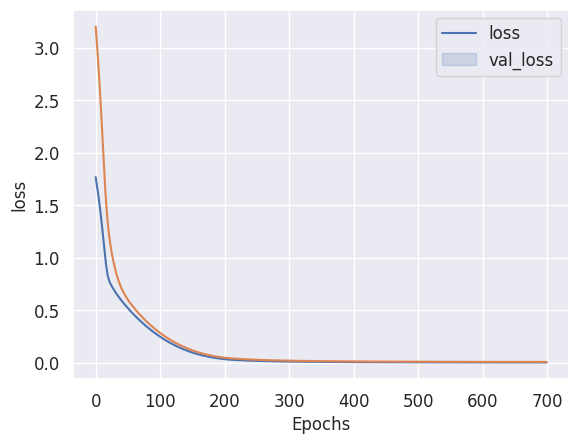

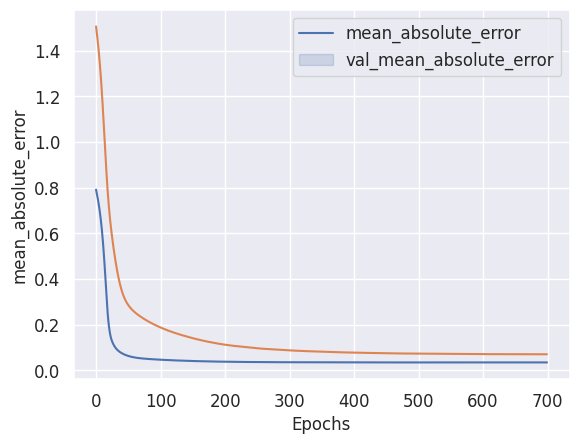

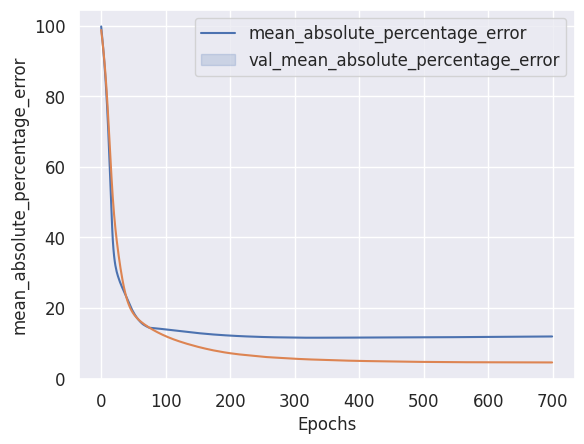

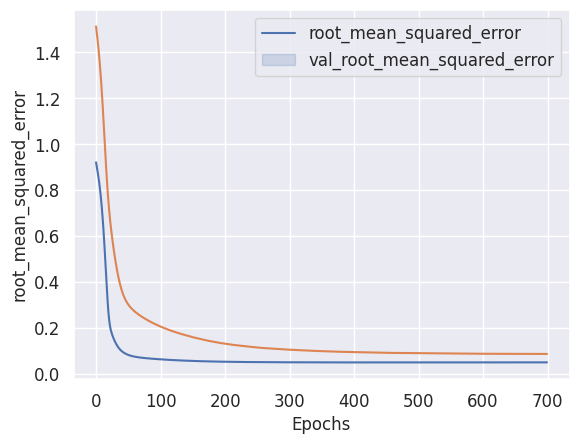

In [7]:
#training dataset
train_loss, train_RMSE, train_MAE, train_MAPE = model.evaluate(x_train, y_train)

print('\n','Evaluation of Training dataset:','\n''\n','train_loss:',round(train_loss,3),'\n','train_RMSE:',round(train_RMSE,3),'\n', 'train_MAE:',round(train_MAE,3),'\n','train_MAPE:',round(train_MAPE,3))


#val dataset
val_loss, val_RMSE, val_MAE, val_MAPE = model.evaluate(x_test, y_test)
print('\n','Evaluation of Testing dataset:','\n''\n','val_loss:',round(val_loss,3),'\n','val_RMSE:',round(val_RMSE,3),'\n', 'val_MAE:',round(val_MAE,3),'\n','val_MAPE:',round(val_MAPE,3))

# predict on val set



mlflow.log_metric('train_loss',train_loss)
mlflow.log_metric('RMSE', train_RMSE)
mlflow.log_metric('MAE', train_MAE)
mlflow.log_metric('MAPE',train_MAPE)

mlflow.log_metric('val_loss',val_loss)
mlflow.log_metric('val_RMSE', val_RMSE)
mlflow.log_metric('val_MAE', val_MAE)
mlflow.log_metric('val_MAPE',val_MAPE)

mlflow.keras.save_model(model, path =path_model+'/')

path_metrics+'/'+'data.csv'
df = pd.read_csv(path_metrics+'/'+'data.csv')

metricplot(df, 'epoch', 'loss','val_loss', path_metrics)
metricplot(df, 'epoch', 'mean_absolute_error','val_mean_absolute_error', path_metrics)
metricplot(df, 'epoch', 'mean_absolute_percentage_error','val_mean_absolute_percentage_error', path_metrics)
metricplot(df, 'epoch', 'root_mean_squared_error','val_root_mean_squared_error', path_metrics)

In [8]:

y_test_pred = model.predict(x_test)
MAPE_pred = tf.keras.losses.MeanAbsolutePercentageError()
print("The MAPE on the test data is:",round(MAPE_pred(y_test, y_test_pred).numpy(),3))

18/18 [==============================] - 1s 3ms/step
The MAPE on the test data is: 4.572


In [9]:
model.save(path_model+'/'+model_name)   
#model_name = 'lstm_128.h5'
#path_model_tr ="../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model" 
model_eval = load_model(path_model+'/'+model_name, compile=False)

# get future dates and predict the future close price!
future_days = 30

startdate = list(df_datetime['date'])[-1]
startdate = pd.to_datetime(startdate) + pd.DateOffset(days=1)
enddate = pd.to_datetime(startdate) + pd.DateOffset(days=future_days+1)
forecasting_dates= pd.bdate_range(start=startdate, end=enddate, freq = 'B')
number_of_days = len(forecasting_dates)
forecast = model_eval.predict(train_data_X[-len(forecasting_dates):])
forecast_copies = np.repeat(forecast, df_data.shape[1], axis = -1 )
y_pred_fut = scaler.inverse_transform(forecast_copies)[:,0]
forecast_close = {'dates':forecasting_dates ,'close': y_pred_fut, 'close_orig':data['close'].iloc[-number_of_days:] }
forecasting_df = pd.DataFrame(data = forecast_close)
forecasting_df.to_csv(path_forecast +'/'+ 'forecast.csv')
print('The forecast for the future',number_of_days,'days is:','\n',forecasting_df)

1/1 [==============================] - 1s 610ms/step
The forecast for the future 22 days is: 
           dates        close  close_orig
6413 2022-08-01  1811.288940     1817.80
6414 2022-08-02  1807.937622     1807.12
6415 2022-08-03  1804.961304     1808.94
6417 2022-08-04  1804.597290     1764.58
6418 2022-08-05  1798.967529     1739.08
6419 2022-08-08  1792.918823     1740.09
6420 2022-08-09  1781.620728     1742.45
6421 2022-08-10  1765.555908     1734.02
6422 2022-08-11  1747.022339     1726.09
6423 2022-08-12  1727.803223     1735.56
6424 2022-08-15  1722.433472     1709.72
6425 2022-08-16  1720.485596     1707.32
6426 2022-08-17  1715.698975     1708.99
6427 2022-08-18  1710.083008     1711.56
6428 2022-08-19  1704.839966     1696.53
6429 2022-08-22  1697.704712     1718.22
6430 2022-08-23  1693.127075     1727.38
6431 2022-08-24  1693.891235     1719.64
6432 2022-08-25  1692.892700     1717.20
6433 2022-08-26  1691.385254     1734.33
6434 2022-08-29  1696.865234     1755.83
643

In [10]:
#y_test_pred = model.predict(x_test)
MAPE_pred = tf.keras.losses.MeanAbsolutePercentageError()
print("The MAPE on the test data is:",round(MAPE_pred(forecasting_df['close'], forecasting_df['close_orig']).numpy(),3),"%")

The MAPE on the test data is: 1.495 %


<AxesSubplot: xlabel='dates', ylabel='close'>

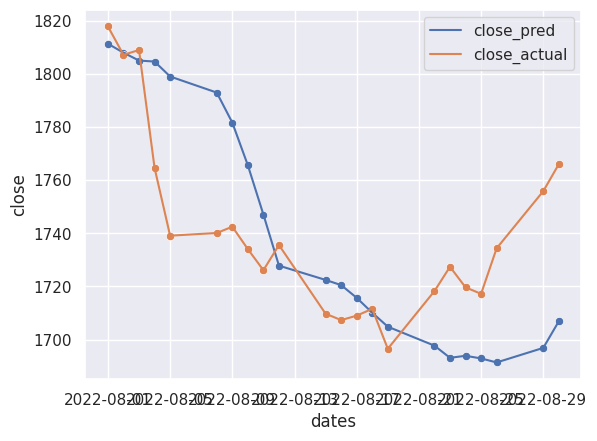

In [11]:
#forecasting_df



sns.lineplot(data = forecasting_df, x  = forecasting_df['dates'], y = forecasting_df['close'], label='close_pred')
sns.scatterplot(data = forecasting_df, x  = forecasting_df['dates'], y = forecasting_df['close'])

sns.lineplot(data = forecasting_df, x = forecasting_df['dates'], y = forecasting_df['close_orig'],label='close_actual')
sns.scatterplot(data = forecasting_df, x = forecasting_df['dates'], y = forecasting_df['close_orig'])

In [12]:
import pickle
with open('scaler_std.bin', 'wb') as f_out:
    pickle.dump((scaler), f_out)